In [3]:
import re, gensim, pickle, operator
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [4]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
trend_folder = '../data/trends/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
df_competition = pd.read_csv(data_folder + 'competitors.csv')
df_category = pd.read_csv(data_folder + 'category_groups.csv')
df_investors = pd.read_csv(data_folder + 'investors.csv')

In [5]:
# 각 카테고리에 속하는 회사들의 펀딩 찍어보기
# 회사-카테고리 매핑
df_category = df_organizations[['uuid','category_list']]
print(df_category.head())

                                   uuid  \
0  1e4f199c-363b-451b-a164-f94571075ee5   
1  6681b1b0-0cea-6a4a-820d-60b15793fa66   
2  fd80725f-53fc-7009-9878-aeecf1e9ffbb   
3  10a3b2fd-b142-046b-7d8f-3b1aa4877aca   
4  1d410d6c-13ce-3d53-4e3f-be70dd5ffd54   

                                       category_list  
0  hardware|manufacturing|product design|semicond...  
1                                  hardware|software  
2  cloud computing|collaboration|developer tools|...  
3           hardware|information technology|software  
4               computer|government|service industry  


In [6]:
# 카테고리 리스트를 개별 카테고리로 나눠서 dataframe 으로 만든다
df2 = df_category['category_list'].str.split('|').apply(pd.Series, 1).stack()
df2.index = df2.index.droplevel(-1)
df2.name = 'category_list'
del df_category['category_list']
df_category = df_category.join(df2)
df_category.columns = ['uuid', 'category']
df_category.head()

uuid        category
0  1e4f199c-363b-451b-a164-f94571075ee5        hardware
0  1e4f199c-363b-451b-a164-f94571075ee5   manufacturing
0  1e4f199c-363b-451b-a164-f94571075ee5  product design
0  1e4f199c-363b-451b-a164-f94571075ee5   semiconductor
1  6681b1b0-0cea-6a4a-820d-60b15793fa66        hardware

In [7]:
# 각 회사의 투자 정보를 불러온다
df_funding = df_funding_rounds[['company_uuid', 'funding_round_uuid', 'announced_on', 'funding_round_type', 'funding_round_code']]
df_funding = df_funding.merge(df_category, left_on = 'company_uuid', right_on = 'uuid', how = 'inner')
df_funding = df_funding.drop('uuid', axis = 1)
df_funding.columns = ['company_uuid', 'funding_round_uuid', 'date',  'funding_round_type', 'funding_round_code', 'category']
df_funding['year-month'] = df_funding['date'].str[:7]
df_funding.head()

company_uuid                    funding_round_uuid  \
0  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
1  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
2  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
3  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
4  bb971d77-d7b8-a3c3-6925-c418077e5d3c  828b3a89-451e-cd0a-6d57-e31dd6a46124   

         date funding_round_type funding_round_code            category  \
0  2017-07-04            venture                  B  financial services   
1  2017-07-04            venture                  B             fintech   
2  2016-03-15            venture                  A  financial services   
3  2016-03-15            venture                  A             fintech   
4  2017-07-04            venture                  A  financial services   

  year-month  
0    2017-07  
1    2017-07  
2    2016-03  
3    2016-03  
4    2017-07

In [8]:
# 각 회사에 투자한 투자사들의 정보를 합친다
df_investment = pd.DataFrame(df_investments[['funding_round_uuid', 'investor_uuid']].groupby('funding_round_uuid')['investor_uuid'].apply(list)).reset_index()
df_funding = df_funding.merge(df_investment, on = 'funding_round_uuid')
df_funding.head()

company_uuid                    funding_round_uuid  \
0  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
1  4f503d57-bf03-4010-6fcc-036fab95b39c  d17ab961-d739-410e-e904-4cb78057cbe1   
2  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
3  4f503d57-bf03-4010-6fcc-036fab95b39c  2dd15d97-767c-4eb4-6053-c7a7ce203801   
4  bb971d77-d7b8-a3c3-6925-c418077e5d3c  828b3a89-451e-cd0a-6d57-e31dd6a46124   

         date funding_round_type funding_round_code            category  \
0  2017-07-04            venture                  B  financial services   
1  2017-07-04            venture                  B             fintech   
2  2016-03-15            venture                  A  financial services   
3  2016-03-15            venture                  A             fintech   
4  2017-07-04            venture                  A  financial services   

  year-month                                      investor_uuid  
0    2017-07  [1d91db1b-8aa3-3a98-aca1-b375b327235b, 307c51d...  
1    2017-07  [1d91db1b-8aa3-3a98-aca1-b375b327235b, 307c51d...  
2    2016-03  [307c51d2-b1f2-315a-9dcc-87643466bb87, 8ea4648...  
3    2016-03  [307c51d2-b1f2-315a-9dcc-87643466bb87, 8ea4648...  
4    2017-07  [4ede174d-3254-8602-e977-d9c0bfe34433, 94c2fe4...

In [9]:
# 가장 많이 사용된 탑 10 카테고리
df_category_count = pd.read_csv('../data/others/category_count.csv')
print(df_category_count.head(20))

# # csv 파일이 없을 시 다음의 코드로 저장할 수 있다
# df_funding.groupby('category').size().rename('count').reset_index().sort_values('count', ascending = False).to_csv('../data/others/category_count.csv', index = False)

                  category  count
0                 software  15892
1                   mobile  12275
2              health care  10972
3      enterprise software   9600
4               e-commerce   9173
5                 internet   8314
6            biotechnology   7931
7   information technology   6659
8                     saas   6240
9                analytics   5959
10             advertising   4872
11           manufacturing   4829
12                 medical   4767
13                    apps   4493
14            social media   4357
15               education   3717
16                 finance   3650
17                big data   3482
18                 fintech   3348
19                hardware   3257


In [10]:
# crunchbase 의 카테고리 정보로 빠른 투자자들 찾기
def get_early_investors_by_categories(categories, investment_criteria = ['seed'], early_investment_percent = 10, top_k = 30,verbose = True, norm = False):
    color1 = 'blue'
    if type(categories) == str:
        categories = [categories]

    # 펀딩 정보중 겹치는 데이터를 뺀다
    df = df_funding[df_funding['category'].isin(categories)].drop_duplicates('funding_round_uuid')

    if 'seed' in investment_criteria:
        df = pd.concat([df[df['funding_round_type'] == 'seed'],
                                   df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    else:
        df = pd.concat([df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    

#     print df.shape
    if df.shape[0] == 0:
        if verbose:
            print 'not found in categories'
        return
    
    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        valid_categories = list(set(list(df_funding['category'].unique())).intersection(set(categories)))
        print('Relevant categories: {}'.format(valid_categories))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    try:
        df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
        df2 = df['investor_uuid'].apply(pd.Series, 1).stack()
    except Exception as e:
        return None
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    df2.index = df2.index.droplevel(-1)
    df2.name = 'investor_uuid'
    del df['investor_uuid']
    df = df.join(df2)

    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()
    df3 = df.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    
    score_norm = df.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score_norm = score_norm.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score_norm = score_norm.merge(df3, on = 'investor_uuid')
    
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    if norm:
#         score = score[score['count'] > 10]
        score['count'] /= np.sqrt(score_norm['count'])
        score = score.sort_values(['count'], ascending = False)
        return score
    else:
        return score

In [11]:
# company description 에 있는 단어 기반으로 해당 단어에 관련된 회사들에 빨리 투자한 투자자 찾기
def get_early_investors_by_words(words, investment_criteria = ['seed'], early_investment_percent = 10, top_k = 30, expand = False, verbose = True):
    color1 = 'blue'
    
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

    # 연관 단어도 같이 보고 싶을 시 비슷한 단어를 검색에 포함시킨다
    # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            if word not in model: continue
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    
    # 해당 단어가 있는 회사들을 모은다
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))

    # 펀딩 정보중 필요한 회사들만 취하고, 겹치는 데이터를 뺀다
    df = df_funding[df_funding['company_uuid'].isin(companies)].drop_duplicates('funding_round_uuid')    
    if 'seed' in investment_criteria:
        df = pd.concat([df[df['funding_round_type'] == 'seed'],
                                   df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    else:
        df = pd.concat([df[df['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    
    if df.shape[0] < 10:
        return None
    
    # 그래프를 그리기 위한 전처리
    start_year = min(df['year-month'].values)[:4]
    count = df.groupby('year-month').size().rename('count').reset_index()
    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.sort_values('year-month')
    count['cum_count'] = count['count'].cumsum()
    if verbose:
        print('Keywords: {}'.format(final_words))

    # 가장 빠른 상위 top_k 퍼센트의 투자만 고른다
    dates = sorted(df['date'].values, reverse = False)
    fast_date = dates[int(float(early_investment_percent) / 100 * len(dates))]
    if verbose:    
        print "Early {} percent investors before {} \n({} early fundings out of {} total)".format(early_investment_percent, fast_date, int(float(early_investment_percent) / 100 * len(dates)), len(dates))
    df_fast = df[df['date'] < fast_date]
    
    # 투자자 리스트를 개별 투자자의 형태로 dataframe 을 변형한다
    try:
        df_fast2 = df_fast['investor_uuid'].apply(pd.Series, 1).stack()
    except Exception as e:
        print 'none'
        return None
        
        
    df_fast2.index = df_fast2.index.droplevel(-1)
    df_fast2.name = 'investor_uuid'
    del df_fast['investor_uuid']
    df_fast = df_fast.join(df_fast2)
    
    # 첫 투자 날을 기억해
    df_fast3 = df_fast.groupby('investor_uuid')['year-month'].min().rename('date').reset_index()

    # 가장 많은 투자를 한 투자자 순으로 출력한다
    score = df_fast.groupby('investor_uuid').size().rename('count').reset_index().sort_values('count', ascending = False)
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', left_on = 'investor_uuid', right_on = 'uuid')
    score = score.merge(df_fast3, on = 'investor_uuid')
    score2 = score.drop(['investor_uuid', 'uuid'], axis = 1)
    if verbose:        
        print score2.head(top_k)
        print score2.shape
        count[['year-month', 'cum_count']].plot(x = count['year'], linestyle = '-', color = [color1], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['funding count'])
    return score

In [12]:
def get_early_investors(words, investment_criteria = ['seed'], early_investment_percent = 10, top_k = 30):
    get_early_investors_by_categories(words, investment_criteria, early_investment_percent, top_k)
    get_early_investors_by_words(words, investment_criteria, early_investment_percent, top_k)

In [13]:
# 모든 카테고리에 대해서 빠른 회사들 찾아서 저장
# 모든 단어에 대해서 빠른 회사들 찾아서 저장
category_min = 10
word_min = 10
save_category = False
save_word = False
investment_criteria = ['seed']
# investment_criteria = ['seed', 'A', 'B', 'C', 'D', 'E']

if save_category:
    df_category_count = pd.read_csv('../data/others/category_count.csv')
    category2investor = {}
    investor2category = {}

    df_category_count = df_category_count[df_category_count['count'] >= category_min]
    categories = df_category_count['category'].values
    for index, category in enumerate(categories):
        if index % (len(categories) // 10) == 0:
            print index, len(categories)
        if type(category) != str: continue
        score = get_early_investors_by_categories(category, investment_criteria = investment_criteria, \
                                                  early_investment_percent = 10, top_k = 30, verbose = False, norm = False)
        if score is None:
            continue
#         print score['investor_name'].head(10)
        investors = score['investor_uuid'].values
        category2investor[category] = investors
        for investor in investors:
            if investor not in investor2category:
                investor2category[investor] = []
            investor2category[investor].append(category)

    with open('../data/others/category2early_investor_{}.pickle'.format('_'.join(investment_criteria)), 'w') as f:
        pickle.dump(category2investor, f)
    with open('../data/others/early_investor2category_{}.pickle'.format('_'.join(investment_criteria)), 'w') as f:
        pickle.dump(investor2category, f)

    for category, investors in category2investor.items():
        print category
        print investors
        break
    
if save_word:
    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'company2word' not in globals():
        print('loading company2word')
        global company2word
        company2word = pickle.load(open(util_folder + 'company2word.pickle'))

    word2investor = {}
    investor2word = {}

    words = word2company.keys()
    for index, word in enumerate(words):
        if index % (len(words) // 100) == 0:
            print index, len(words)
        if len(word2company[word]) < word_min: continue            
            
        score = get_early_investors_by_words([word], early_investment_percent = 10, top_k = 30, verbose = False)
        if score is None: continue
        investors = score['investor_uuid'].values
        word2investor[word] = investors
        for investor in investors:
            if investor not in investor2word:
                investor2word[investor] = []
            investor2word[investor].append(word)
    with open('../data/others/word2investor.pickle', 'w') as f:
        pickle.dump(word2investor, f)
    with open('../data/others/investor2word.pickle', 'w') as f:
        pickle.dump(investor2word, f)

    for word, investors in word2investor.items():
        print word
        print investors
        break

In [14]:
save = False
begin_from = 0 # 처음부터 학습하고 싶으면 0 으로 설정
investment_criteria = ['seed']
# investment_criteria = ['seed', 'A', 'B', 'C', 'D', 'E']
norm = False

if save:
    category_weight = df_category_count.set_index('category')['count'].to_dict()
    if norm:
        category2investor = pickle.load(open('../data/others/category2early_investor_norm_{}.pickle'.\
                                            format('_'.join(investment_criteria))))
    else:
        category2investor = pickle.load(open('../data/others/category2early_investor_{}.pickle'.\
                                            format('_'.join(investment_criteria))))


#     weight_schemes = ['log', 'sqrt', 'simple']
    weight_schemes = ['sqrt']
    for weight_scheme in weight_schemes:
#         for index, _category in enumerate(df_category_count['category']):
        for index, _category in enumerate(['all']):
            if index < begin_from: continue
            score = {}
            for category, investors in category2investor.items():
                if category == _category: continue
                for investor in investors:
                    score[investor] = 0
            all_investors = score.keys()
            num_max = len(all_investors)

            print 'target category', _category, index, len(category2investor.keys())
            weight_sum = 0
            for category, investors in category2investor.items():
                if category == _category: continue
                if weight_scheme == 'simple': weight_sum += 1
                if weight_scheme == 'sqrt': weight_sum += np.sqrt(category_weight[category])
                if weight_scheme == 'log': weight_sum += np.log(category_weight[category])

                default_rank = (num_max + len(investors)) / 2.0
                default_rank = 1.0 / default_rank

                for rank, investor in enumerate(investors):
                    rank = 1.0 / (rank + 1)
                    if weight_scheme == 'simple': score[investor] += rank
                    if weight_scheme == 'sqrt': score[investor] += (np.sqrt(category_weight[category]) * rank)
                    if weight_scheme == 'log': score[investor] += (np.log(category_weight[category]) * rank)

                for investor in all_investors:
                    if investor not in investors:
                        if weight_scheme == 'simple': score[investor] += default_rank
                        if weight_scheme == 'sqrt': score[investor] += (np.sqrt(category_weight[category]) * default_rank)
                        if weight_scheme == 'log': score[investor] += (np.log(category_weight[category]) * default_rank)

            for investor in all_investors:
                score[investor] = weight_sum / score[investor]

            try:
                if norm:
                    with open('../data/others/early_{}_investor_{}_harmonic_rank_for_{}_norm.pickle'.format('_'.join(investment_criteria), weight_scheme, _category), 'w') as f:
                        pickle.dump(score, f)
                else:
                    with open('../data/others/early_{}_investor_{}_harmonic_rank_for_{}.pickle'.format('_'.join(investment_criteria), weight_scheme, _category), 'w') as f:
                        pickle.dump(score, f)                    
            except Exception as e:
                print e

In [15]:
with open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all.pickle') as f:
    early = pickle.load(f)
early = sorted(early.items(), key = operator.itemgetter(1))
for i, (uuid, score) in enumerate(early[:30]):
    print i + 1, df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], score


1 Y Combinator 3.68178901392
2 SV Angel 11.6198919841
3 High-Tech Gruenderfonds 13.58665782
4 Techstars 13.8337990529
5 ATDC 14.1599282916
6 First Round 14.5960830806
7 500 Startups 20.5127053149
8 Seedcamp 20.5546025193
9 JumpStart Inc. 21.6482020276
10 Ben Franklin Technology Partners of Northeastern Pennsylvania 22.5234578285
11 BioAdvance 25.3499418748
12 Kima Ventures 27.3194549289
13 Dreamit 28.0970457368
14 Fabrice Grinda 32.3707391057
15 Start-Up Chile 32.9841409658
16 Northstar Ventures 33.9967956815
17 Founder Collective 35.9269902711
18 AlphaLab 38.7734679171
19 CIT GAP Funds 39.1264733904
20 HV Holtzbrinck Ventures 40.0684188295
21 SOSV 42.1428482485
22 LocalGlobe 46.2019373865
23 True Ventures 47.6723524284
24 MaRS Investment Accelerator Fund 48.1581930461
25 FLOODGATE 50.6527326121
26 Innovation Works 53.8706022887
27 Felicis Ventures 55.2723899041
28 Lerer Hippeau Ventures 69.3804518011
29 LaunchBox Digital 71.0198886366
30 LaunchCapital 73.083285688


In [16]:
with open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all_norm.pickle') as f:
    early = pickle.load(f)
early = sorted(early.items(), key = operator.itemgetter(1))
for i, (uuid, score) in enumerate(early[:30]):
    print i + 1, df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], score


1 Y Combinator 4.27862119146
2 Techstars 13.4645675181
3 ATDC 14.4774932284
4 SV Angel 15.9028636319
5 High-Tech Gruenderfonds 18.7761156165
6 500 Startups 21.1335177492
7 BioAdvance 24.276569254
8 First Round 25.1775664988
9 Founder Collective 25.3057539478
10 Ben Franklin Technology Partners of Northeastern Pennsylvania 28.218493622
11 HV Holtzbrinck Ventures 28.5597477656
12 Northstar Ventures 29.1413730894
13 JumpStart Inc. 31.9605753225
14 Seedcamp 32.864710866
15 Dreamit 33.342767431
16 Fabrice Grinda 35.3864235011
17 Kima Ventures 43.7618468955
18 Felicis Ventures 44.751306289
19 AlphaLab 46.0824114668
20 CIT GAP Funds 47.6134723378
21 SOSV 51.3377029459
22 LocalGlobe 54.4123982871
23 Innovation Works 55.7357089856
24 True Ventures 61.4636723973
25 Start-Up Chile 65.5348492703
26 General Catalyst 65.8685542928
27 LaunchCapital 66.4186721729
28 Khosla Ventures 83.2023175285
29 Enterprise Ireland 89.0612030255
30 Ronald Conway 90.4664687592


In [17]:
# 단어가 주어졌을때 연관 단어를 배출하는 helper function
def related_words(words):
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')
        
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if word not in model: continue
        _words = model.most_similar(word)
        _words = [str(_word) for _word, sim in _words if _word not in words]
        final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))
    print final_words
    return final_words

In [18]:
save = False
THRESHOLD = 0.7
TOP_K = 20
if save:
    # # TOP VC 들에 대해서 그들이 빨리 투자하는 카테고리, 단어 클러스터 찾기
    category2investor = pickle.load(open('../data/others/category2investor.pickle'))
    investor2category = pickle.load(open('../data/others/investor2category.pickle'))

    word2investor = pickle.load(open('../data/others/word2investor.pickle'))
    investor2word = pickle.load(open('../data/others/investor2word.pickle'))

    # central = pickle.load(open(util_folder + 'investor_centrality_degree.pickle'))
    central = pickle.load(open(util_folder + 'investor_centrality_between_one_over_k.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

    category_distribution = {}

    top20 = [uuid for uuid, value in central[:TOP_K]]
    for i, uuid in enumerate(top20):
        print df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], central[i][1]
        categories = investor2category.get(uuid, [])
        words = investor2word.get(uuid, [])
        print "Num Categories:",len(categories), "Num Words:", len(words)
        print categories
        for category in categories:
            category_distribution[category] = category_distribution.get(category, 0) + 1

        word_list = words
        groups = {0 : [word_list[0]]}
        next_index = 1
        for word1 in word_list[1:]:
            found = False
            for index, group in groups.items():
                for word2 in group:
                    if model.similarity(word1, word2) > THRESHOLD:
                        found = True
                        _index = index
                        break
                if found:
                    break
            if found:
                groups[_index].append(word1)
            else:
                groups[next_index] = [word1]
                next_index += 1
        sorted_groups = sorted(groups.items(), key = lambda i: len(i[1]))
        sorted_groups.reverse()
        for index in range(min(next_index, 15)):
            if len(sorted_groups[index][1]) > 1:
                for word in sorted_groups[index][1]:
                    print word,
                print
                print
        print "*"*20
    print
    category_distribution = sorted(category_distribution.items(), key = lambda x: x[1], reverse = True)
    for word, count in category_distribution:
        print word, count, '/' , TOP_K


Relevant categories: ['software']
Early 10 percent investors before 2003-06-30 
(1013 early fundings out of 10134 total)
    count                                  investor_name     date
0      44                                  Intel Capital  1999-04
1      32                                Austin Ventures  1997-06
2      29                      New Enterprise Associates  1997-01
3      28                  Draper Fisher Jurvetson (DFJ)  1998-04
4      27                                 Accel Partners  1997-01
5      23                      Bessemer Venture Partners  1994-12
6      21                              Greylock Partners  1997-04
7      20                                 Sigma Partners  1998-10
8      18  North Bridge Venture Partners & Growth Equity  1997-01
9      18                        Oak Investment Partners  1997-08
10     18                                Sequoia Capital  1999-08
11     17                   Advanced Technology Ventures  1998-07
12     17            

Relevant categories: ['e-commerce']
Early 10 percent investors before 2007-12-01 
(614 early fundings out of 6146 total)
    count                     investor_name     date
0      22                   Sequoia Capital  1999-08
1      14         Bessemer Venture Partners  1999-06
2      14         New Enterprise Associates  1999-03
3      14  Kleiner Perkins Caufield & Byers  1995-07
4      13                     Goldman Sachs  2000-01
5      12    Norwest Venture Partners - NVP  1999-12
6      11                   Austin Ventures  1999-04
7      11              IDG Capital Partners  1998-05
8      10     Draper Fisher Jurvetson (DFJ)  1998-06
9      10      Advanced Technology Ventures  1999-12
10     10                           Venrock  1999-10
11      9                    Index Ventures  2003-09
12      9                       TL Ventures  1999-11
13      9           Oak Investment Partners  2000-03
14      9                  General Catalyst  2000-01
15      9       Lightspeed Vent

Relevant categories: ['analytics']
Early 10 percent investors before 2007-07-23 
(413 early fundings out of 4136 total)
    count                          investor_name     date
0      22                         Accel Partners  1999-09
1      12                        Matrix Partners  1999-12
2      11                       Battery Ventures  2002-03
3      10                           Bay Partners  2000-03
4      10          Draper Fisher Jurvetson (DFJ)  2001-03
5      10                                Venrock  2001-05
6       9                          Atlas Venture  1999-04
7       9                        Sequoia Capital  1990-11
8       9                        Austin Ventures  2002-12
9       9              Bessemer Venture Partners  2002-05
10      9                          Apax Partners  2000-08
11      9                        Carmel Ventures  2001-05
12      8                     Foundation Capital  1999-12
13      8              New Enterprise Associates  1998-07
14      8 

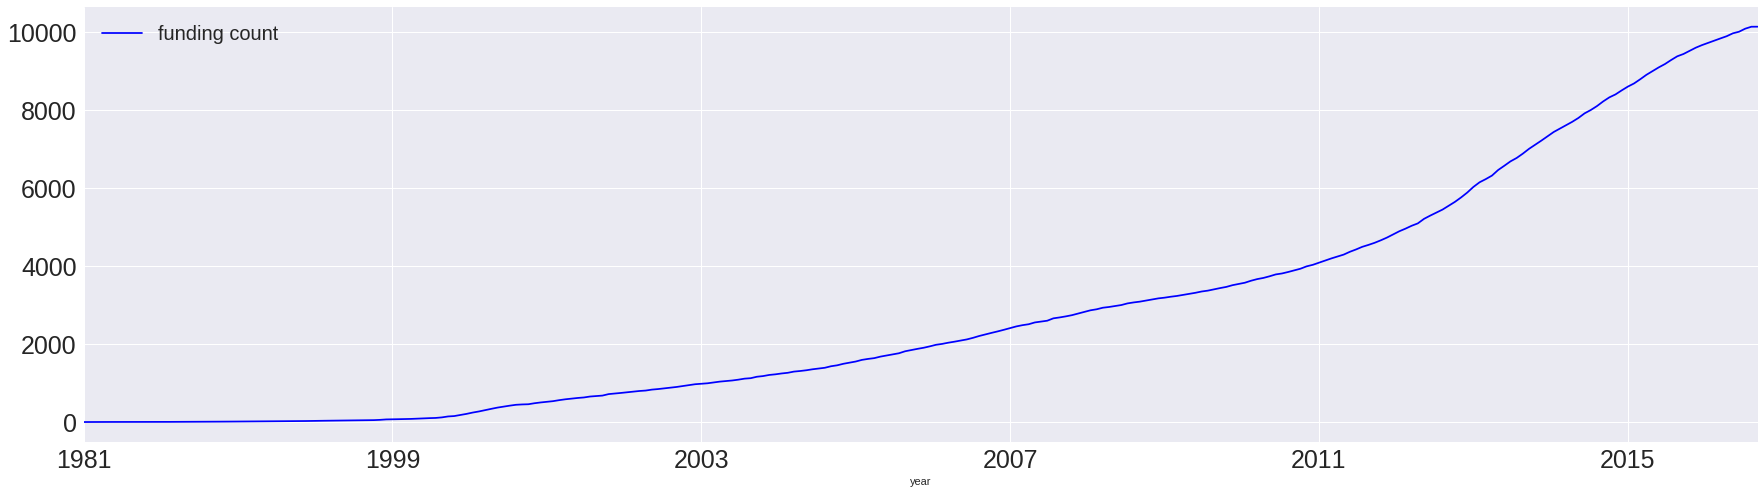

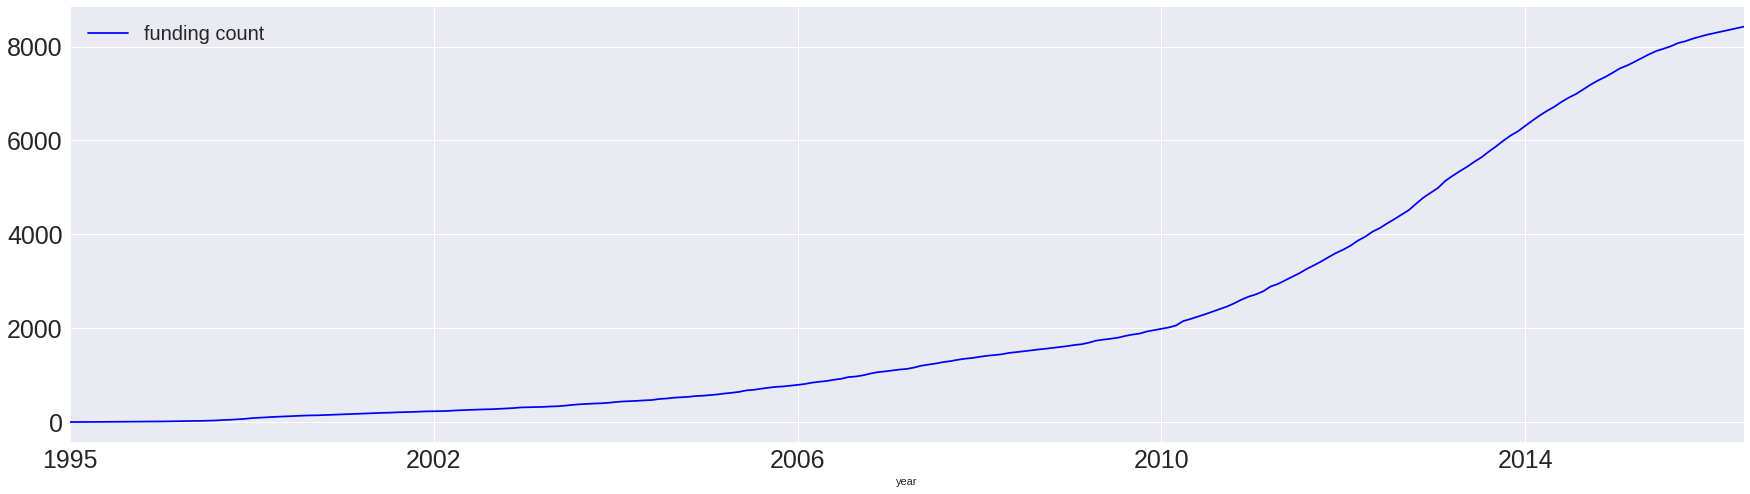

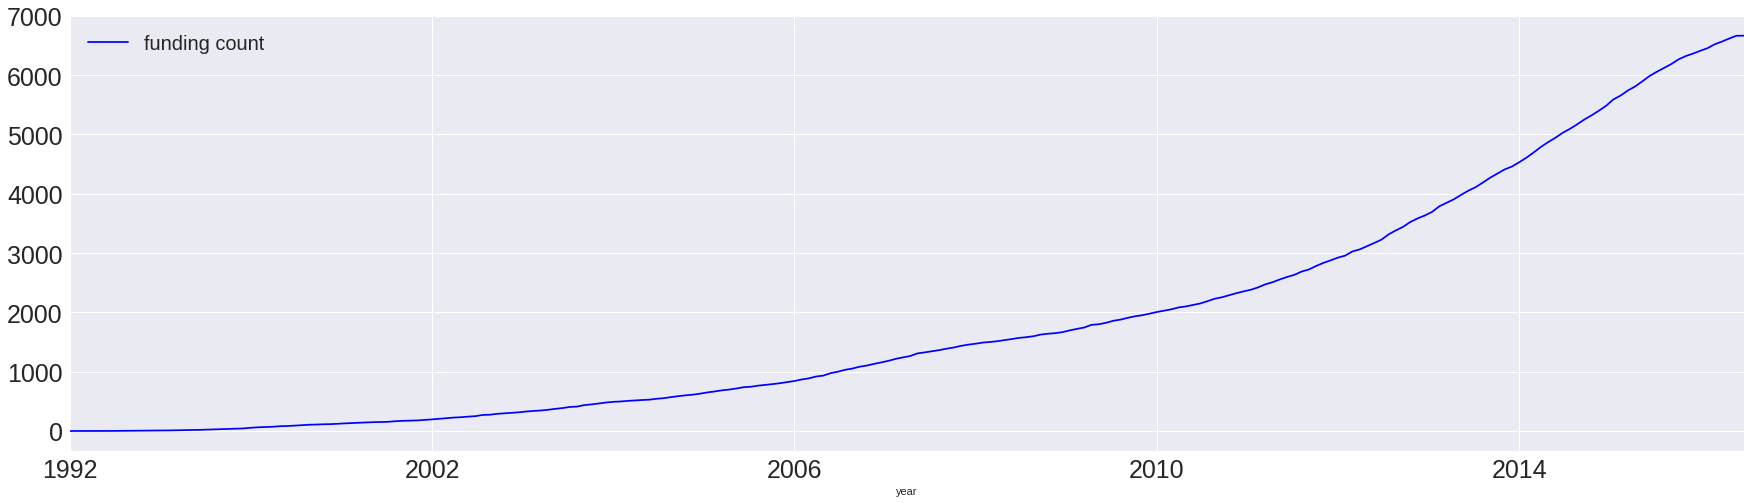

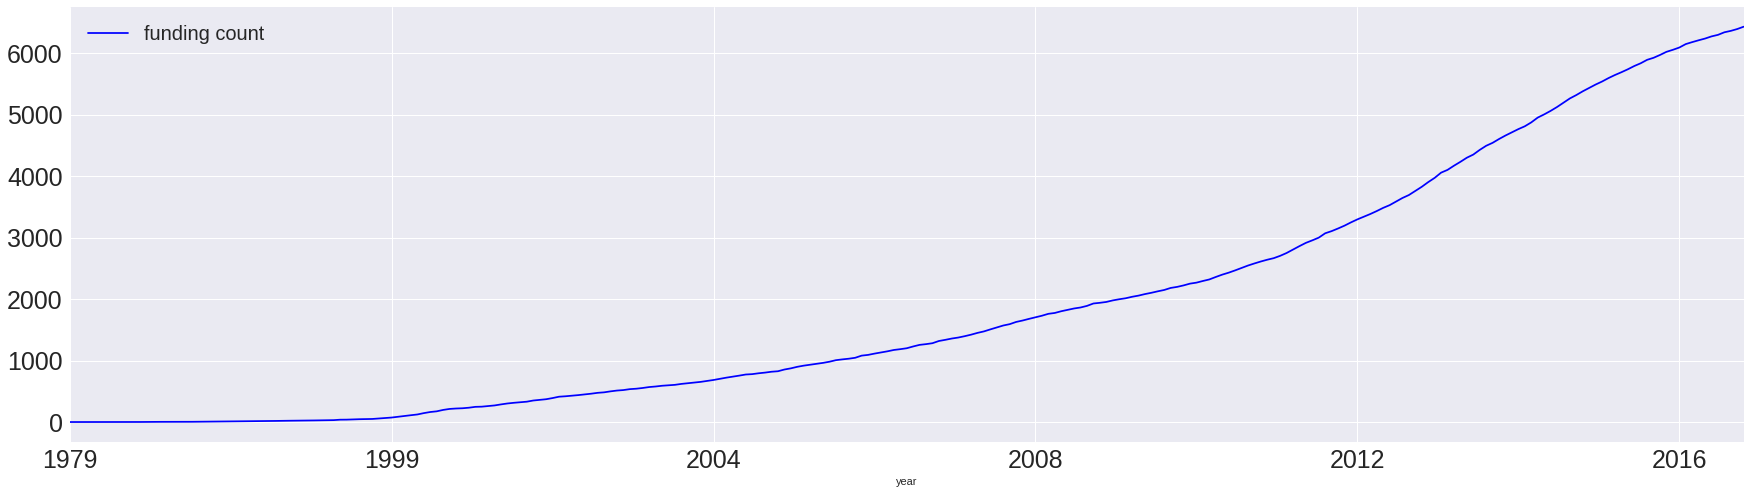

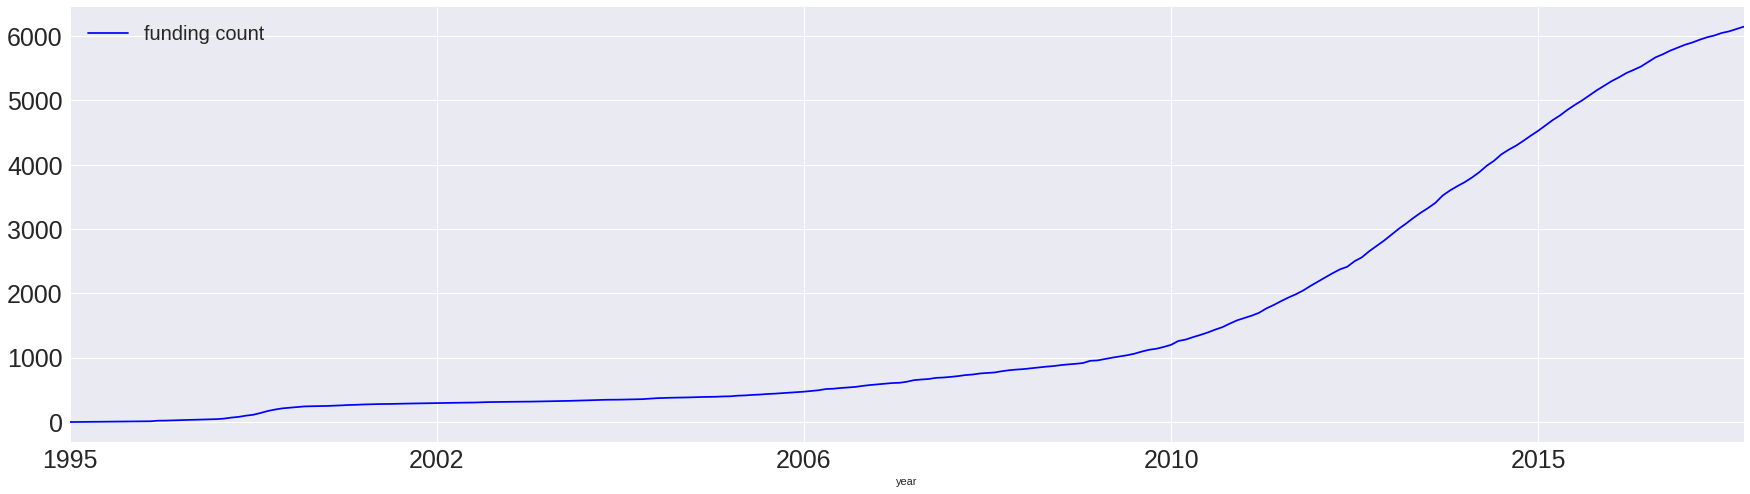

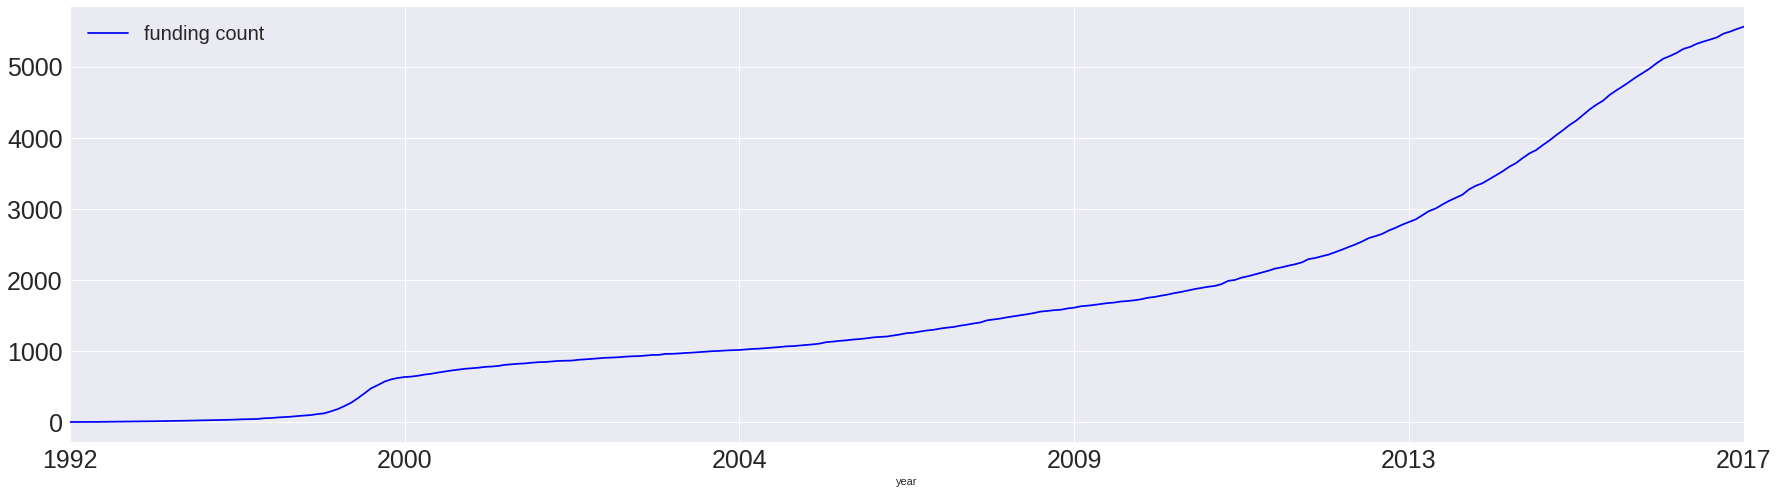

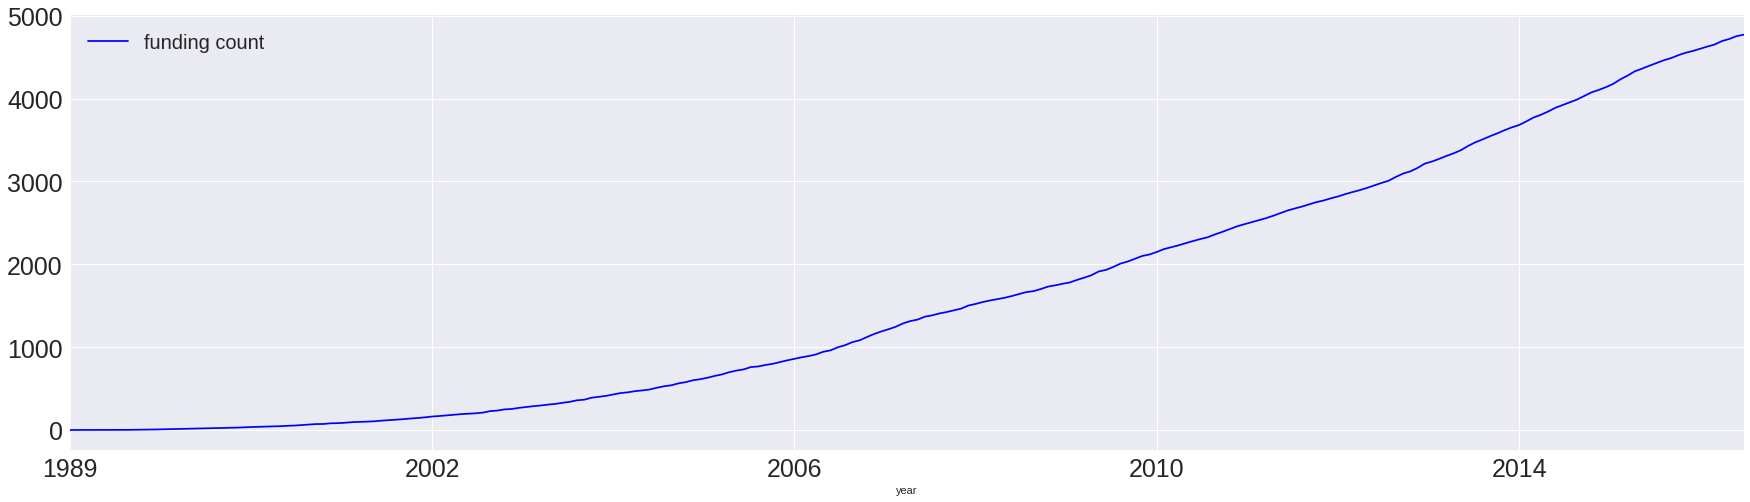

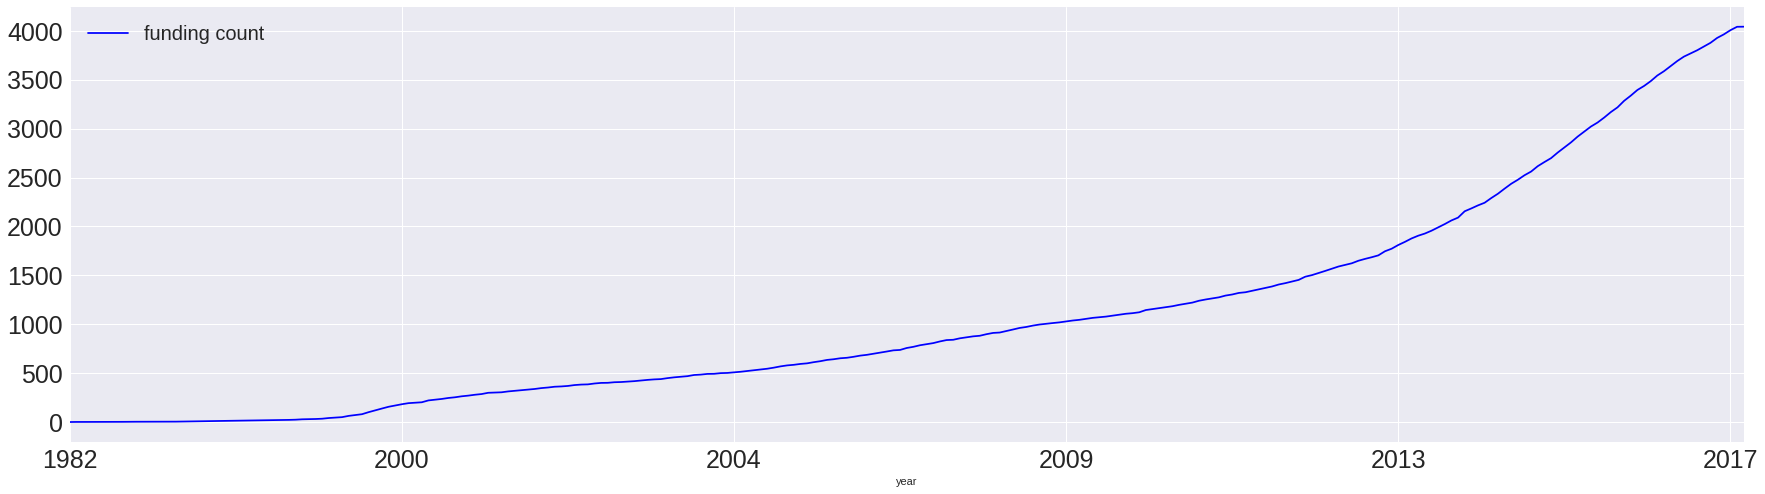

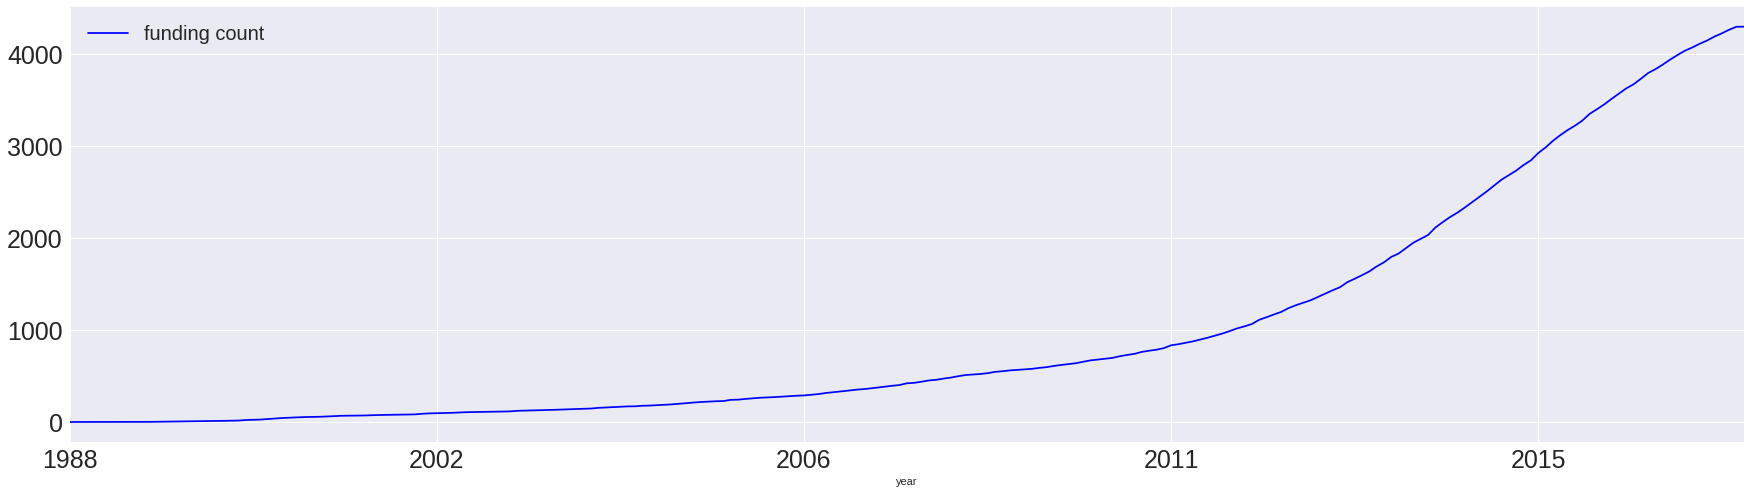

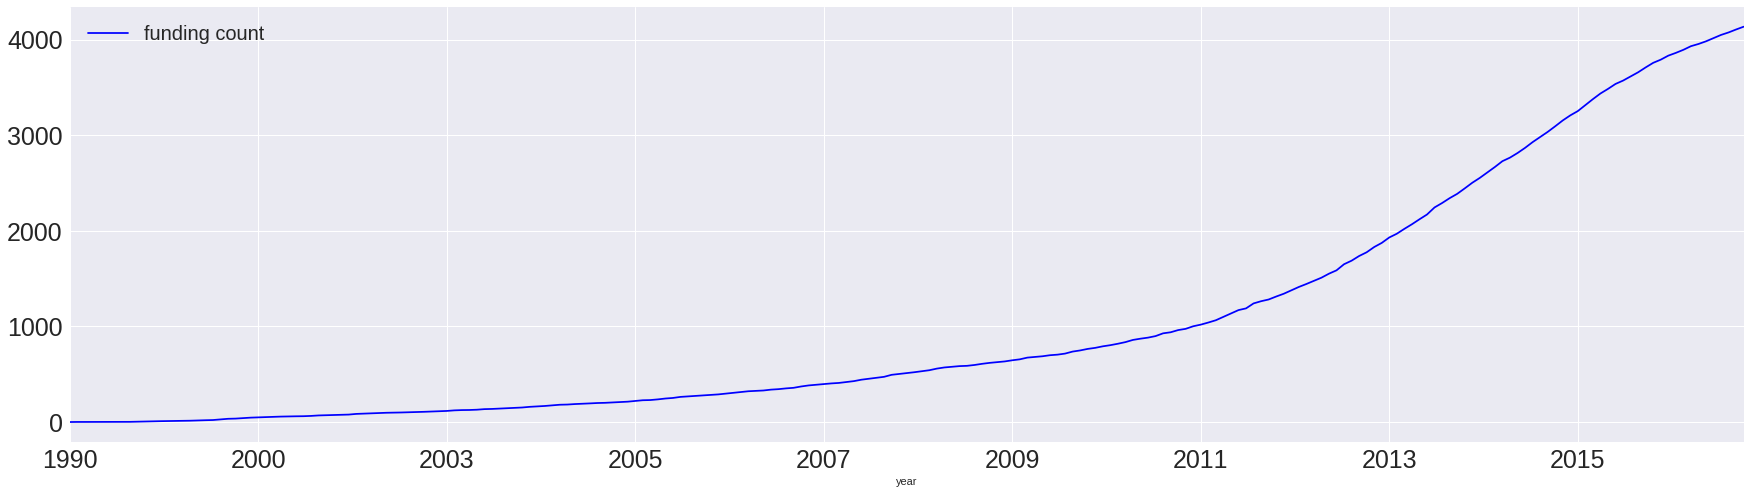

In [22]:
for category in df_category_count['category'].values[:10]:
    get_early_investors_by_categories(category, investment_criteria=['seed', 'A', 'B', 'C', 'D'], early_investment_percent = 10, top_k = 30)

not found in categories
loading word2company
Keywords: ['drone']
Early 10 percent investors before 2014-05-01 
(12 early fundings out of 120 total)
    count                  investor_name     date
0       3                    SK Ventures  2012-11
1       2                  True Ventures  2012-11
2       2                 Start-Up Chile  2012-11
3       2     Oreilly AlphaTech Ventures  2012-11
4       1              Qualcomm Ventures  2013-05
5       1                   Bee Partners  2013-05
6       1          Alchemist Accelerator  2013-07
7       1                  Amino Capital  2013-05
8       1            Andreessen Horowitz  2013-11
9       1                    Legend Star  2013-11
10      1                      Ooga Labs  2013-09
11      1                  Foundry Group  2013-09
12      1                       AngelPad  2013-05
13      1                  SierraMaya360  2013-05
14      1                     Comet Labs  2013-11
15      1             Christopher Michel  2012-11
16

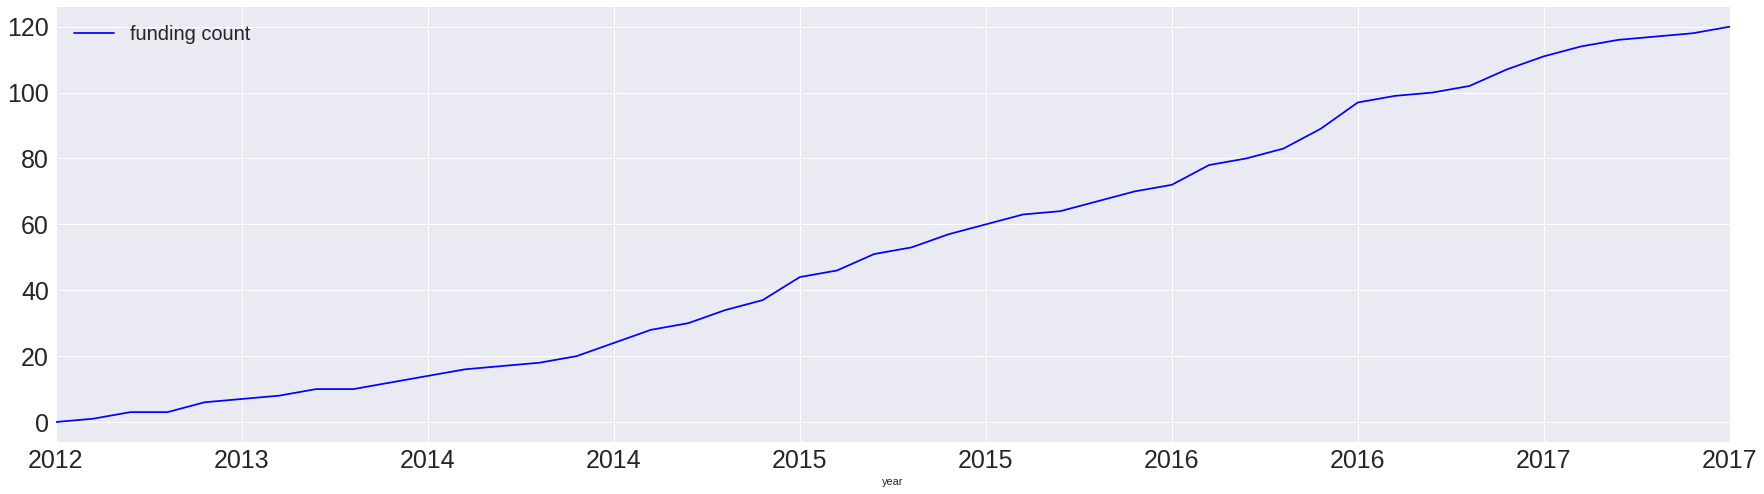

In [31]:
# get_early_investors('drone', investment_criteria=['seed'], early_investment_percent = 10, top_k = 30)
get_early_investors('drone', investment_criteria=['seed', 'A', 'B', 'C', 'D'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['robotics']
Early 10 percent investors before 2012-03-15 
(69 early fundings out of 693 total)
    count                        investor_name     date
0       4                          Giant Eagle  2005-07
1       3                    Bezos Expeditions  2008-08
2       3                             3i Group  2002-04
3       2                 Sutter Hill Ventures  2007-08
4       2                   InterWest Partners  2007-08
5       2                   Cultivian Ventures  2010-01
6       2                     I-Source Gestion  2007-01
7       2              Advent Venture Partners  2003-11
8       2                       Alloy Ventures  2007-08
9       2                                 SOSV  2011-11
10      2                            Techstars  2010-10
11      2               Life Sciences Partners  2010-01
12      2                   Techstars Ventures  2010-10
13      2                        Foundry Group  2010-05
14      2                   Founder Collect

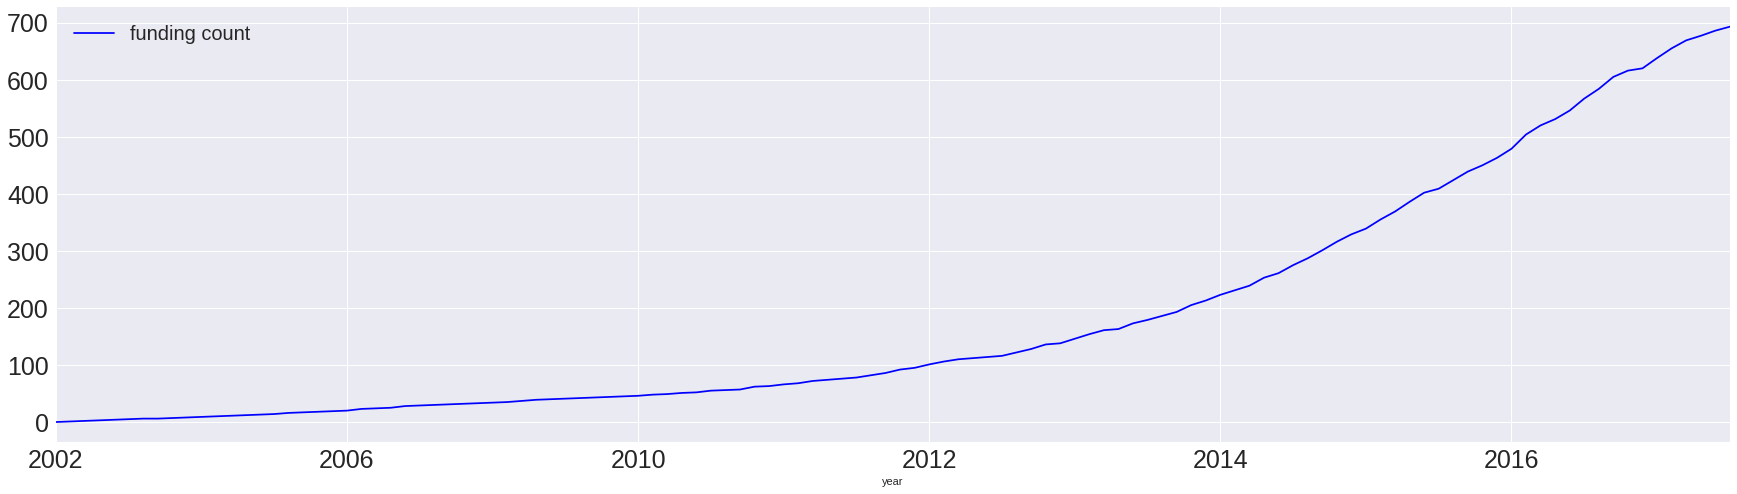

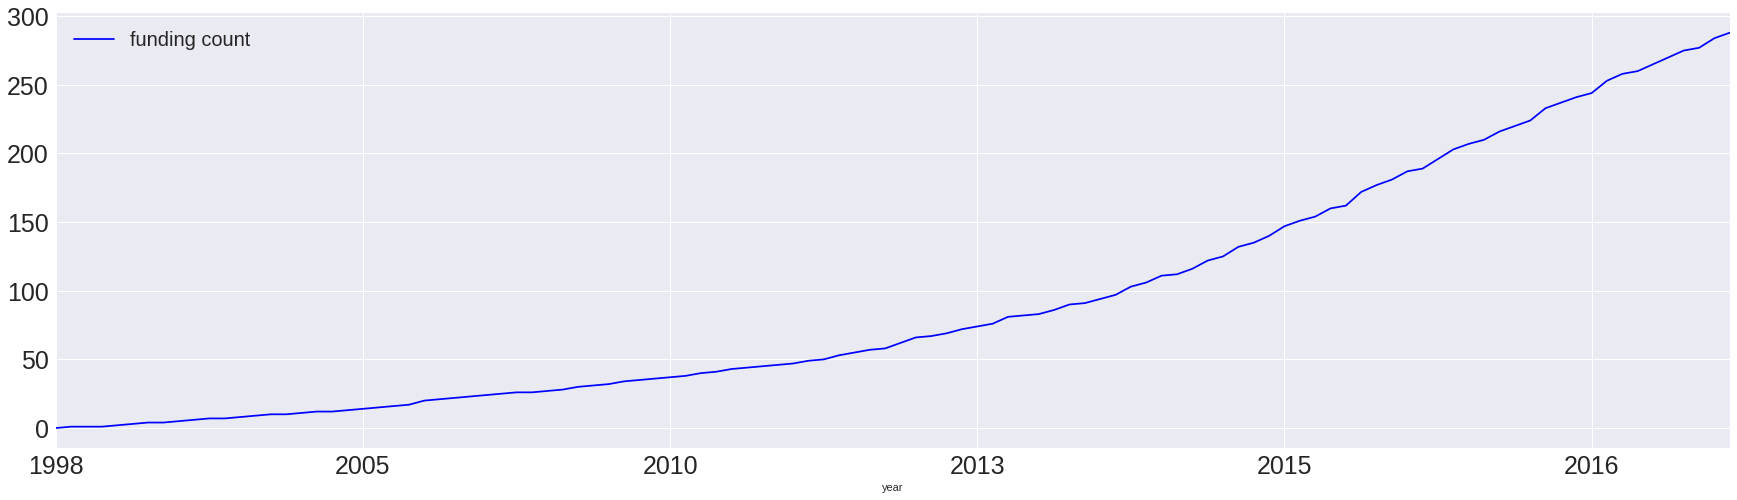

In [36]:
get_early_investors(['robotics'],investment_criteria=['seed', 'A', 'B', 'C', 'D'], early_investment_percent = 10, top_k = 30)

In [33]:
related_words(['robotics'])

['synthetic_biology', 'computer_vision', 'unmanned_systems', 'robotics', 'machine_vision', 'robots', 'mechatronic', 'mechatronics', 'industrial_robots', 'robotic', 'robotic_systems']


['synthetic_biology',
 'computer_vision',
 'unmanned_systems',
 'robotics',
 'machine_vision',
 'robots',
 'mechatronic',
 'mechatronics',
 'industrial_robots',
 'robotic',
 'robotic_systems']

['synthetic_biology', 'computer_vision', 'unmanned_systems', 'robotics', 'machine_vision', 'robots', 'mechatronic', 'mechatronics', 'industrial_robots', 'robotic', 'robotic_systems']
Relevant categories: ['robotics']
Early 10 percent investors before 2012-12-11 
(36 early fundings out of 368 total)
    count               investor_name     date
0       3        RSV Venture Partners  2012-03
1       2     High-Tech Gruenderfonds  2012-11
2       2            Innovation Works  2005-06
3       2                        SOSV  2011-11
4       2                   Techstars  2011-11
5       1                 SK Ventures  2012-09
6       1           Charlie Songhurst  2011-11
7       1          Iron Yard Ventures  2012-08
8       1         Skolkovo Foundation  2012-02
9       1                   Techammer  2012-11
10      1               Mike McCauley  2012-12
11      1                Papillon ZAO  2012-02
12      1                Daniel Debow  2012-12
13      1            Grishin Robotics  201

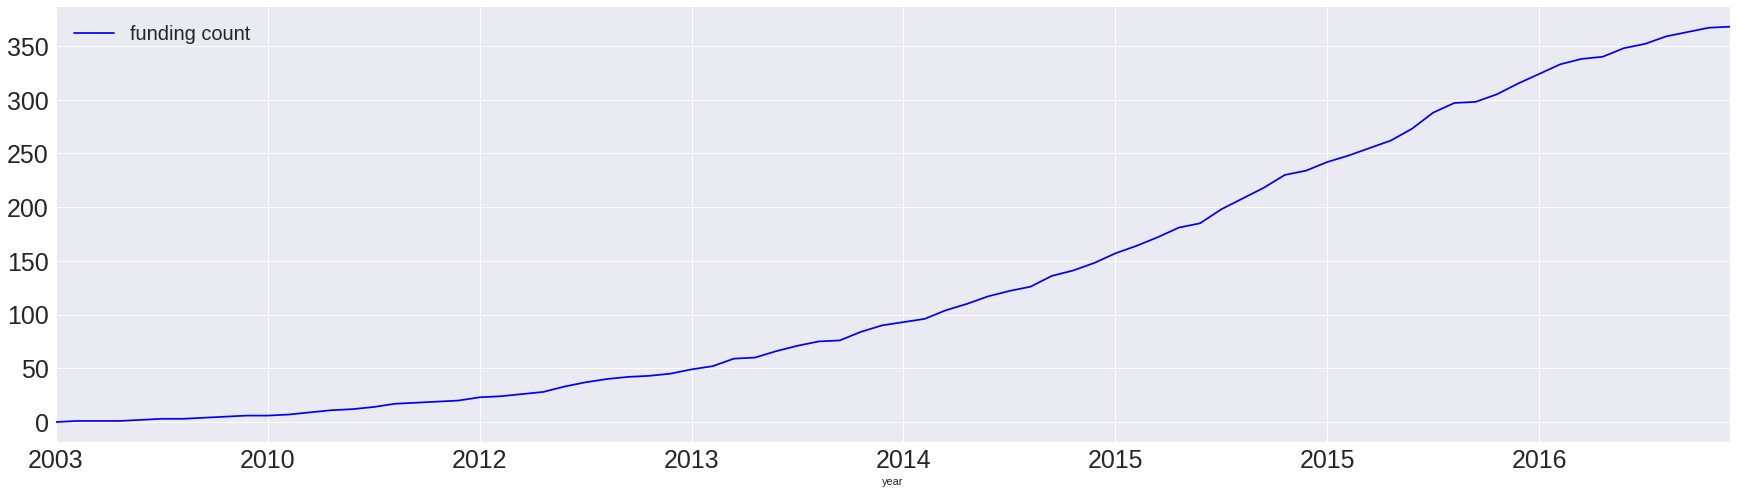

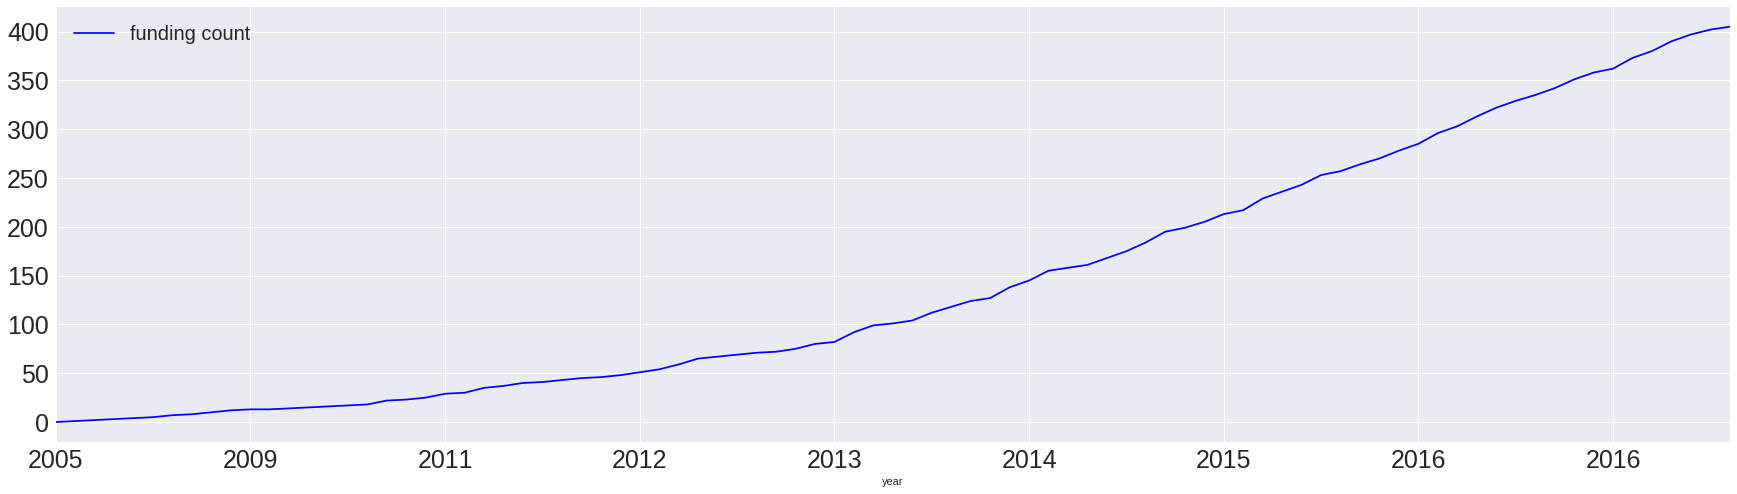

In [34]:
get_early_investors(related_words(['robotics']), early_investment_percent = 10, top_k = 30)

Relevant categories: ['mobile']
Early 10 percent investors before 2007-01-01 
(816 early fundings out of 8162 total)
    count                                  investor_name     date
0      33                                Sequoia Capital  1999-10
1      28                  Draper Fisher Jurvetson (DFJ)  2000-03
2      24                                  Intel Capital  2000-02
3      23                      Bessemer Venture Partners  2000-05
4      22                                       Redpoint  2000-12
5      21                      New Enterprise Associates  1998-07
6      19                   U.S. Venture Partners (USVP)  2000-01
7      19                                  Mayfield Fund  2000-03
8      17                                       3i Group  2000-09
9      17                                  Apax Partners  2000-11
10     15                                 Accel Partners  1999-10
11     15             Motorola Solutions Venture Capital  2003-04
12     14                

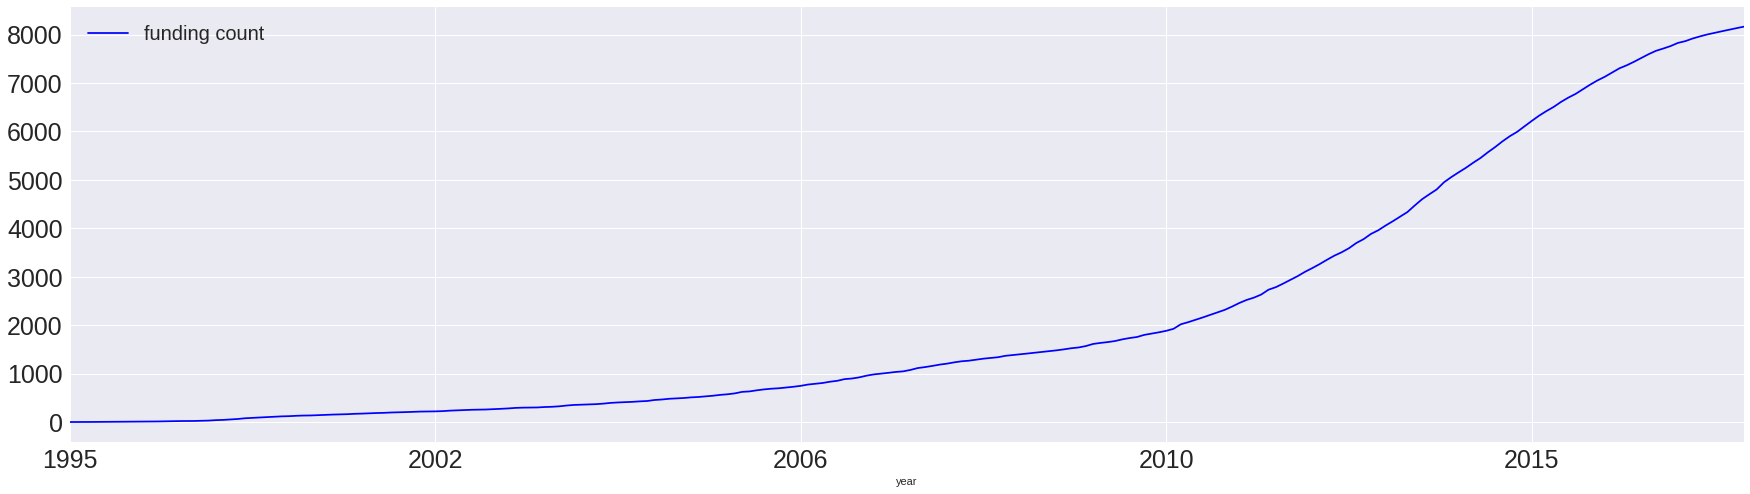

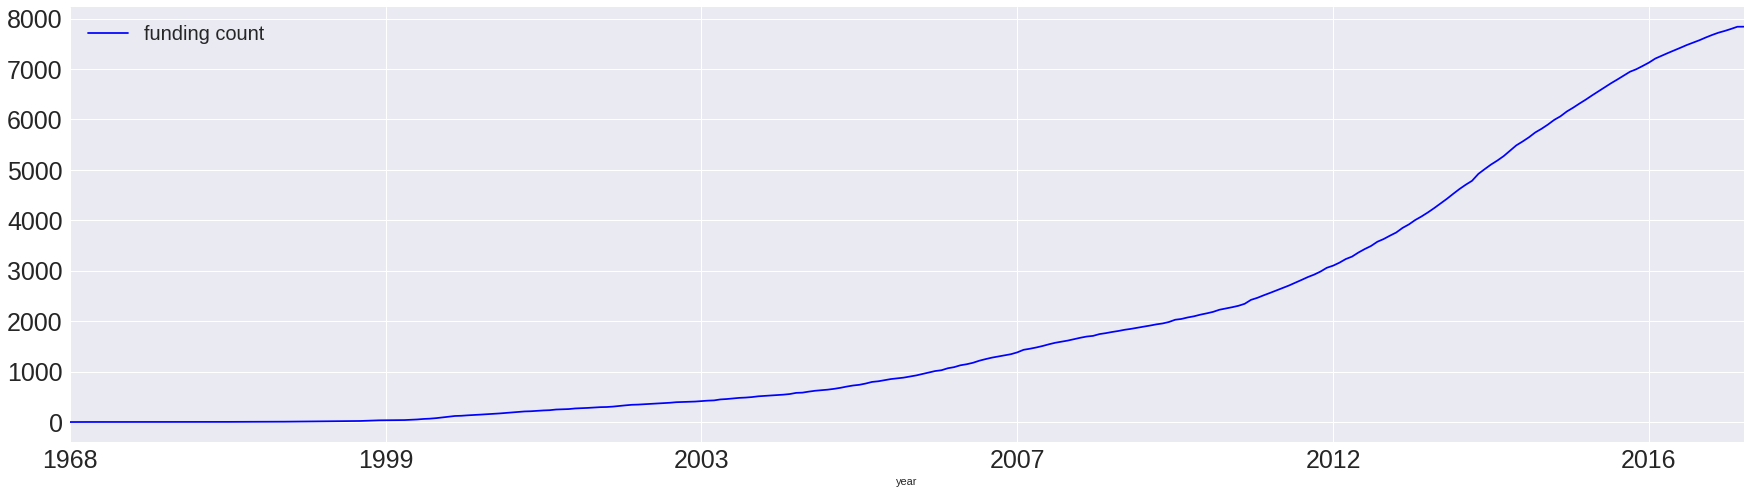

In [38]:
get_early_investors('mobile', investment_criteria=['seed', 'A', 'B', 'C'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['fintech']
Early 10 percent investors before 2010-05-04 
(216 early fundings out of 2163 total)
    count                          investor_name     date
0      16                              Techstars  2007-08
1       9          Draper Fisher Jurvetson (DFJ)  2003-06
2       7                      Greylock Partners  2005-05
3       7                         Accel Partners  1999-10
4       6                          True Ventures  2006-01
5       6                      Fidelity Ventures  2004-04
6       6                              Benchmark  2000-08
7       6         Norwest Venture Partners - NVP  2005-08
8       5                  Morgenthaler Ventures  2006-10
9       5                        Sequoia Capital  1999-10
10      5                          Goldman Sachs  2000-01
11      4                          Icon Ventures  2004-06
12      4            Lightspeed Venture Partners  2007-01
13      4       Kleiner Perkins Caufield & Byers  2006-07
14      4   

    count                       investor_name     date
0       1            Startup Capital Ventures  2009-11
1       1                 Tengelmann Ventures  2012-05
2       1                      Altos Ventures  2009-11
3       1                 Holtzbrinck Digital  2012-05
4       1                            Compound  2009-06
5       1  TPG (formerly Texas Pacific Group)  2000-04
6       1           Villante Capital Partners  2000-04
7       1             Hasso Plattner Ventures  2012-05
8       1                        KPG Ventures  2009-06
9       1                    Imperial Capital  2000-04
10      1             Sequel Venture Partners  2006-03
11      1      Gilbert Global Equity Partners  2000-04
12      1                            Debaeque  2006-03
13      1                       Peter Caswell  2009-11
14      1                     New York Angels  2009-06
15      1    Overseas Private Investment Corp  2012-05
(16, 3)
Relevant categories: ['fintech']
Early 10 percent investo

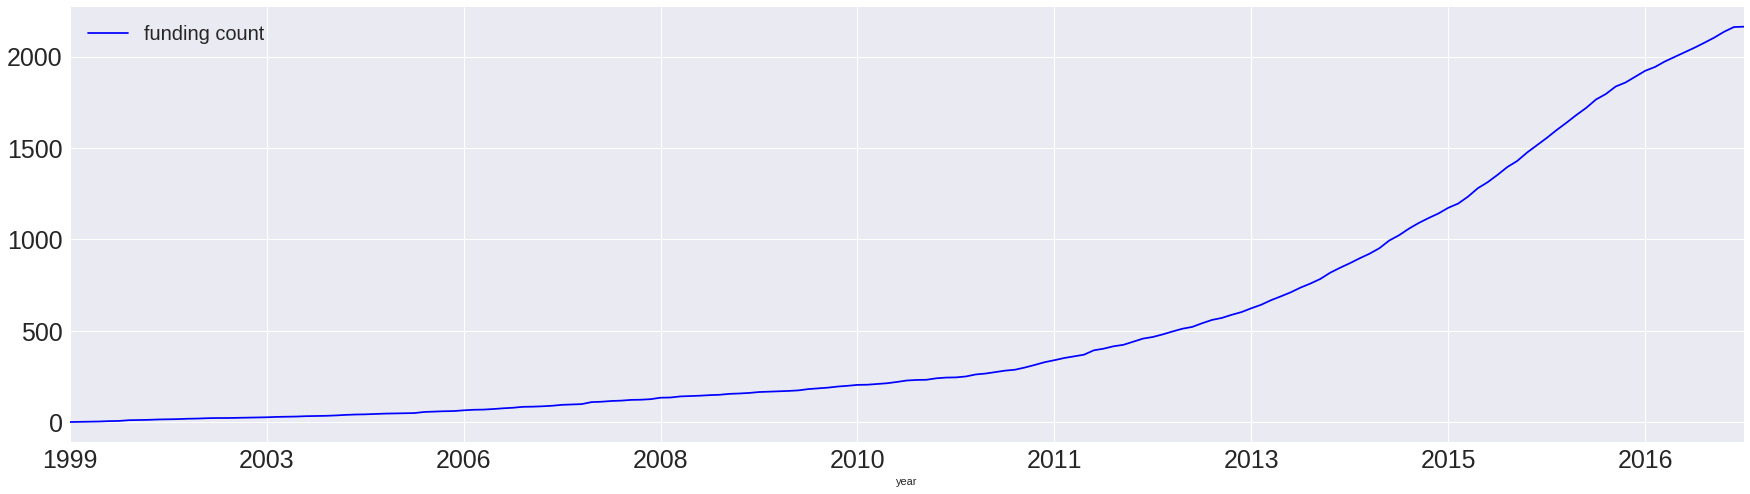

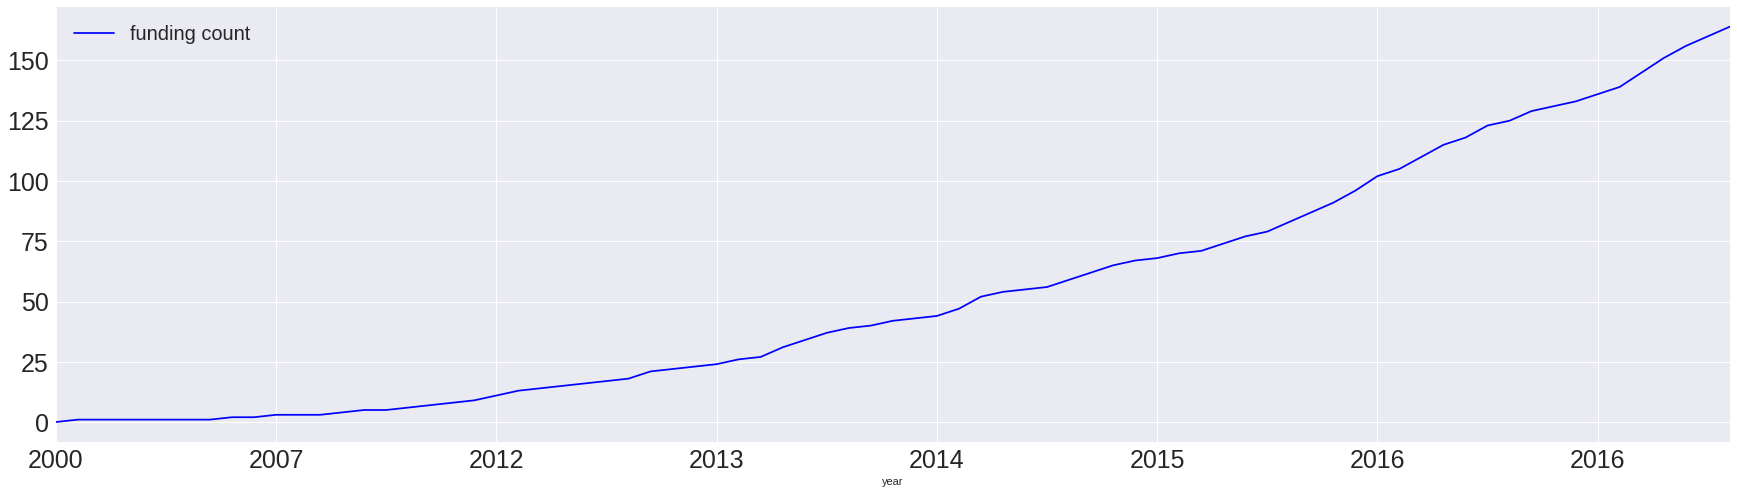

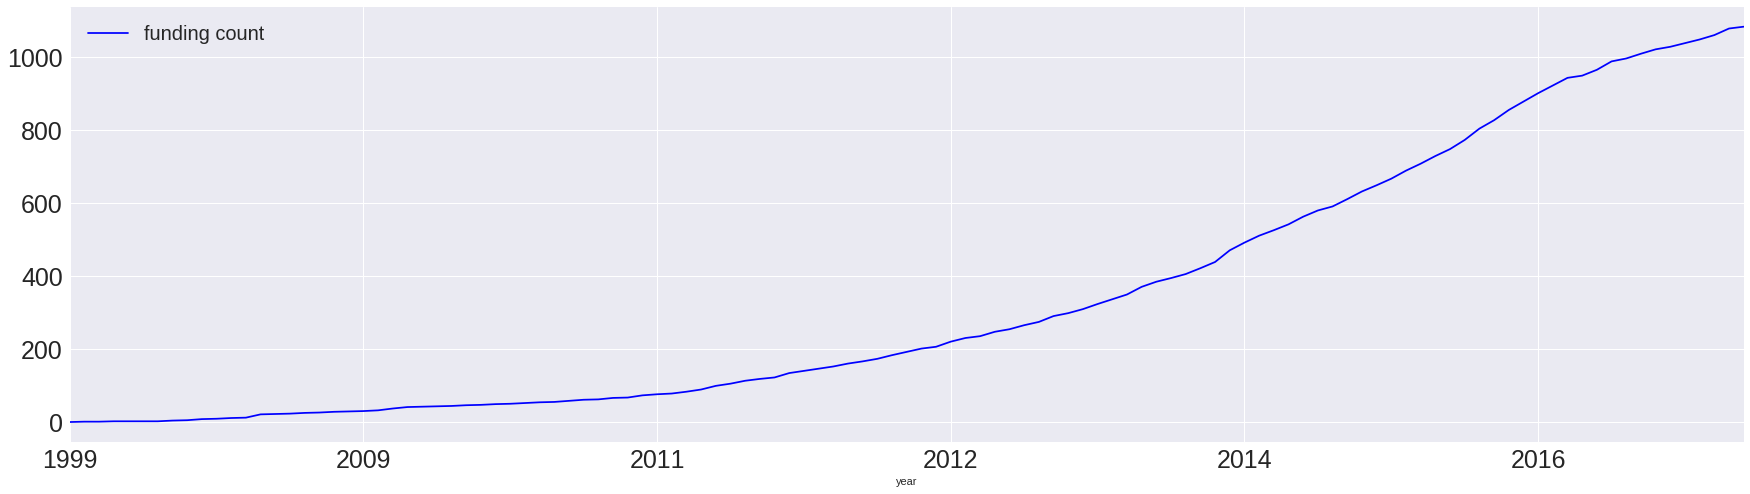

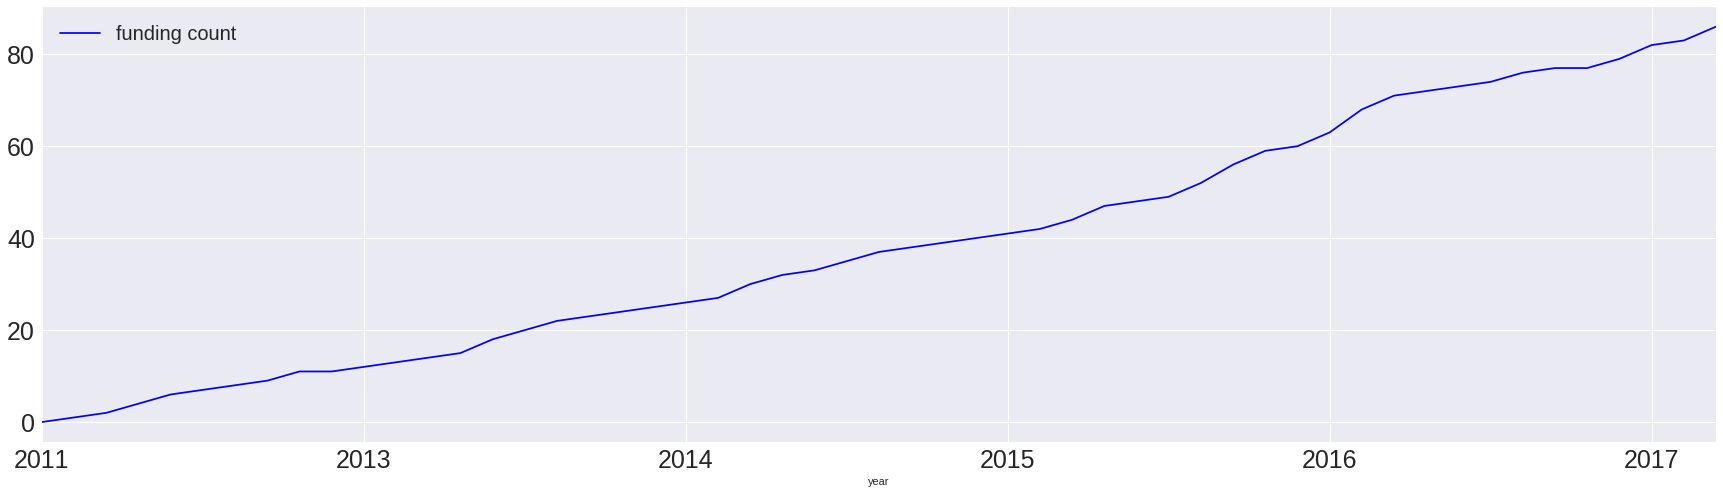

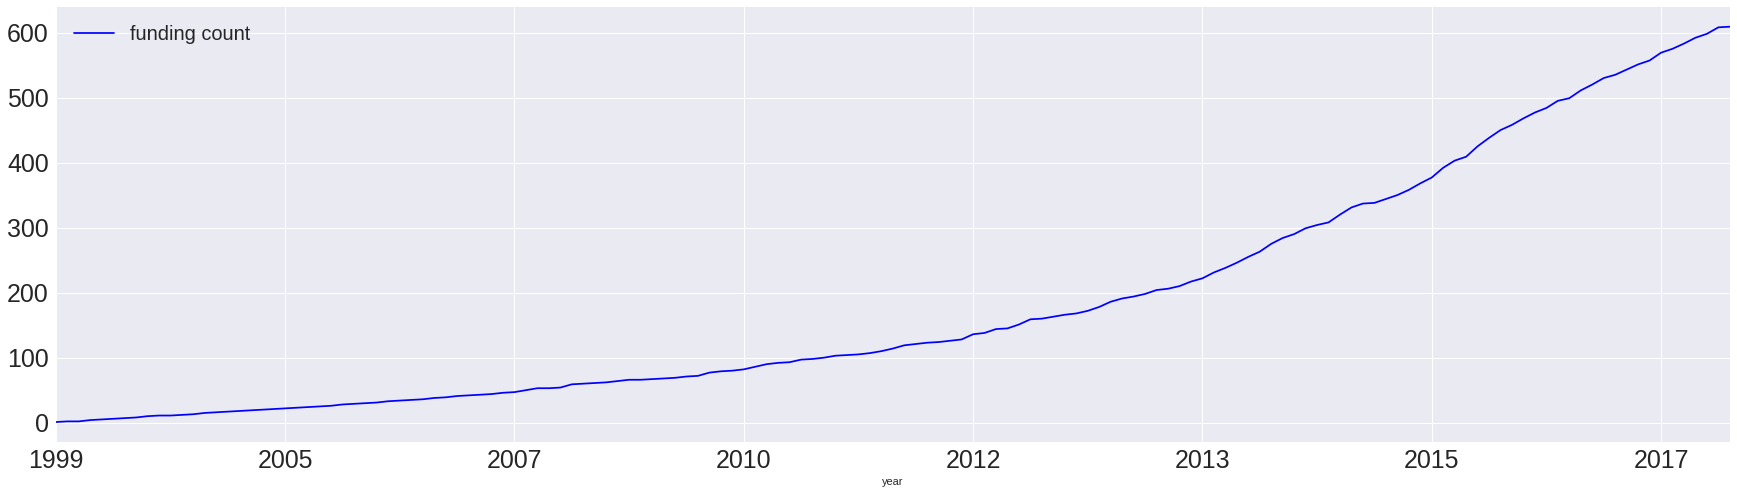

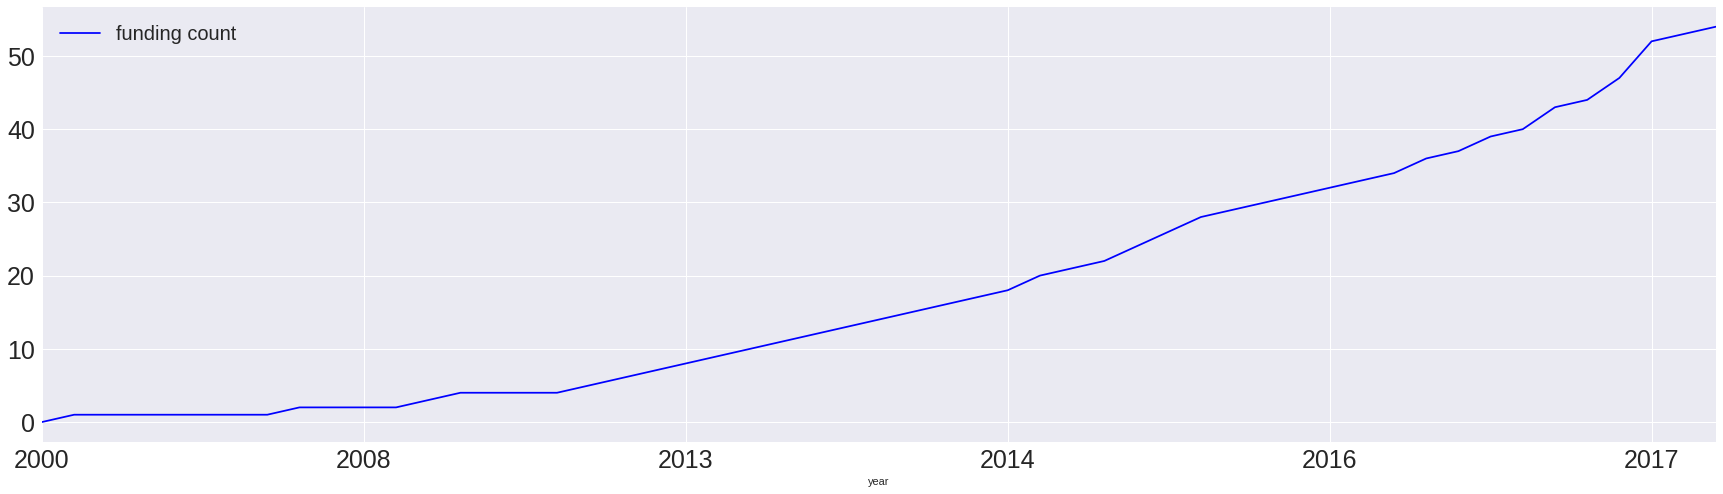

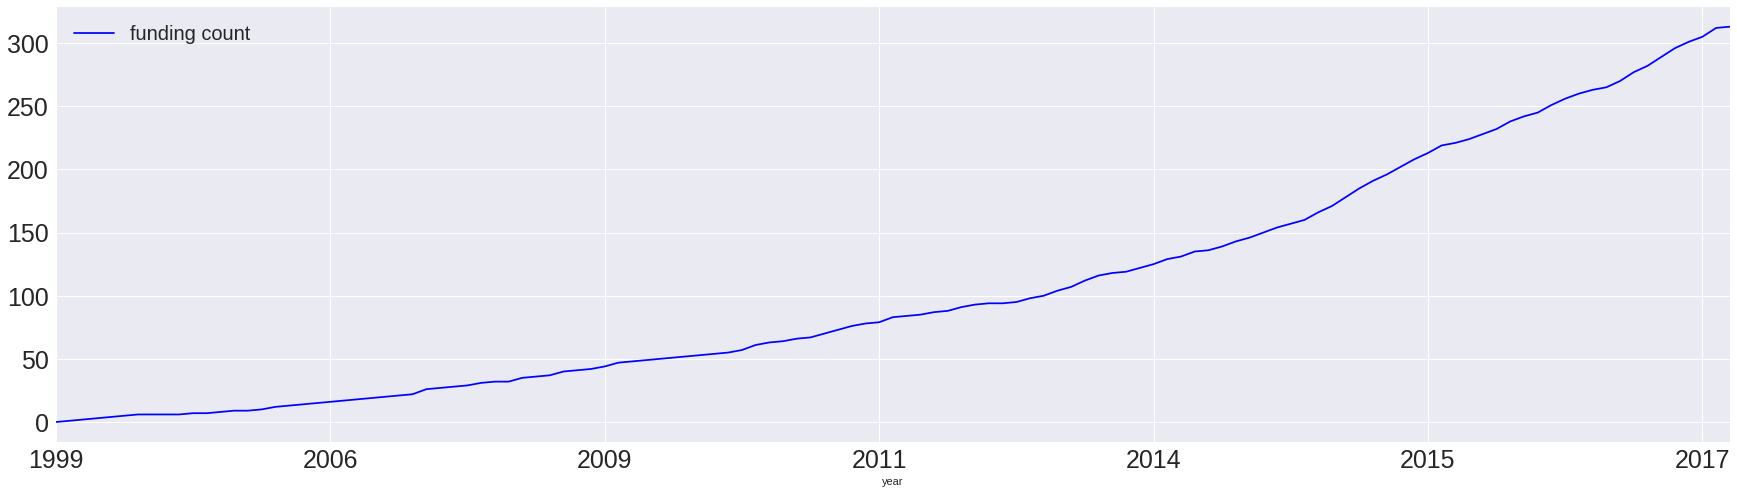

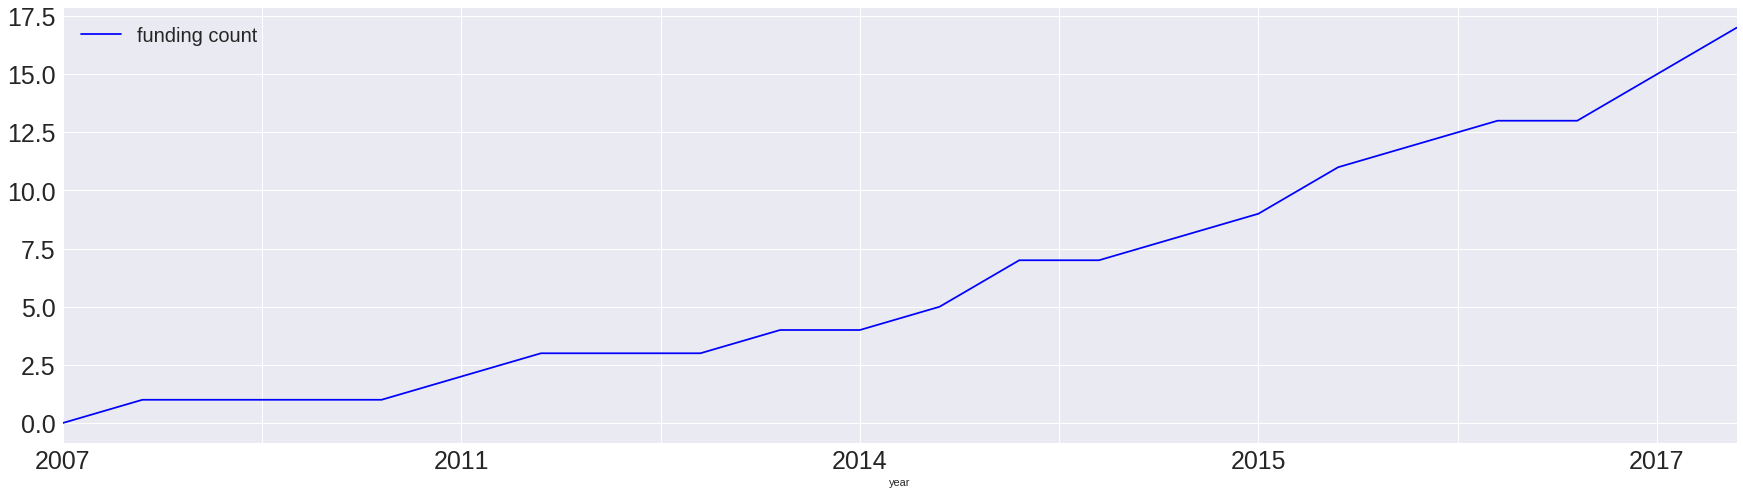

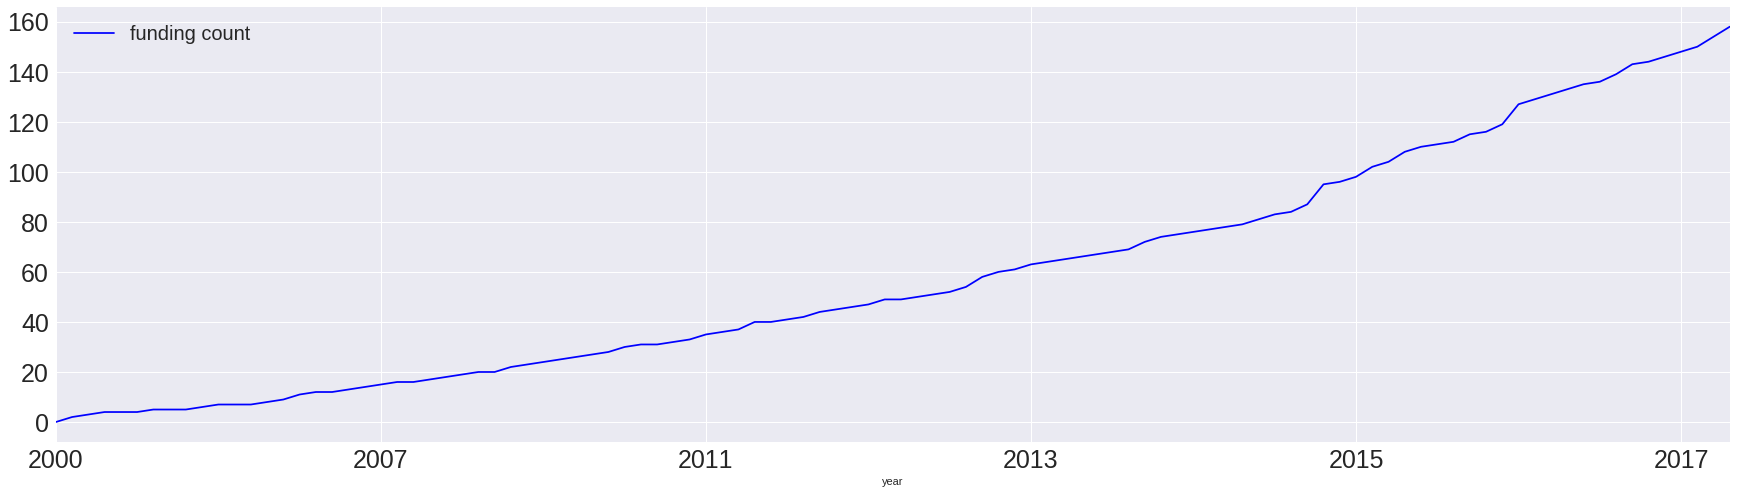

In [39]:
get_early_investors('fintech', investment_criteria=['seed', 'A', 'B', 'C'], early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['seed'], early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['A'], early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['B'], early_investment_percent = 10, top_k = 30)
get_early_investors('fintech', investment_criteria=['C'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['artificial intelligence']
Early 10 percent investors before 2012-05-15 
(101 early fundings out of 1013 total)
    count                                      investor_name     date
0       5                                   Felicis Ventures  2006-05
1       4                              Mohr Davidow Ventures  2006-11
2       3                                    Emertec Gestion  2008-10
3       3                                        HIG Capital  2000-09
4       3                                  Labrador Ventures  2008-07
5       3                                        First Round  2008-07
6       3                                 Foundation Capital  2007-04
7       3                      Celtic House Venture Partners  2008-10
8       3                                  Horizons Ventures  2011-10
9       3  Ben Franklin Technology Partners of Northeaste...  2007-07
10      3                                          Capital-E  2008-10
11      3                 

Relevant categories: ['artificial intelligence']
Early 10 percent investors before 2010-08-01 
(22 early fundings out of 224 total)
    count                     investor_name     date
0       2                       First Round  2008-07
1       2                  Felicis Ventures  2006-05
2       2                   Carmel Ventures  2007-06
3       2         Bessemer Venture Partners  2009-01
4       1                       MHS Capital  2009-01
5       1                  Seraphim Capital  2008-06
6       1                Northwater Capital  2005-09
7       1                   Hewlett-Packard  2005-09
8       1                Enterprise Ireland  2008-10
9       1                          SV Angel  2010-04
10      1                     Bobby Yazdani  2006-05
11      1  Wilson Sonsini Goodrich & Rosati  2008-07
12      1                       Jeff Jordan  2010-04
13      1                    Lorenzo Thione  2010-01
14      1            Quest Venture Partners  2010-01
15      1     Celtic

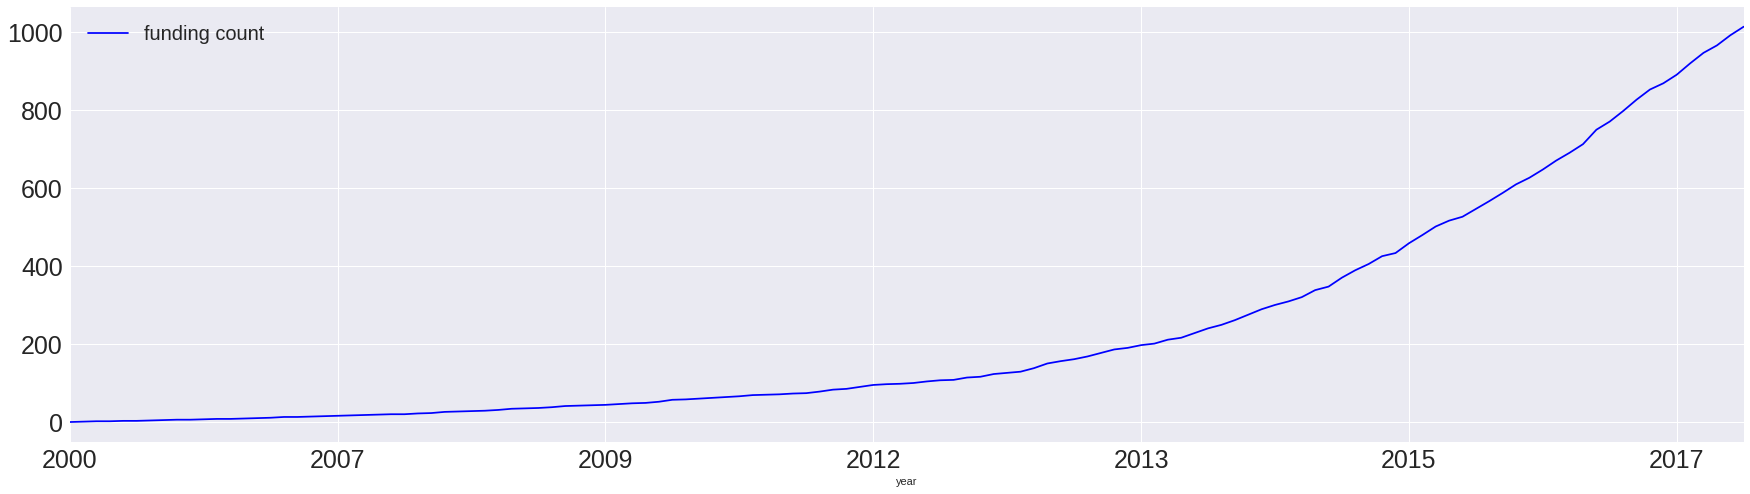

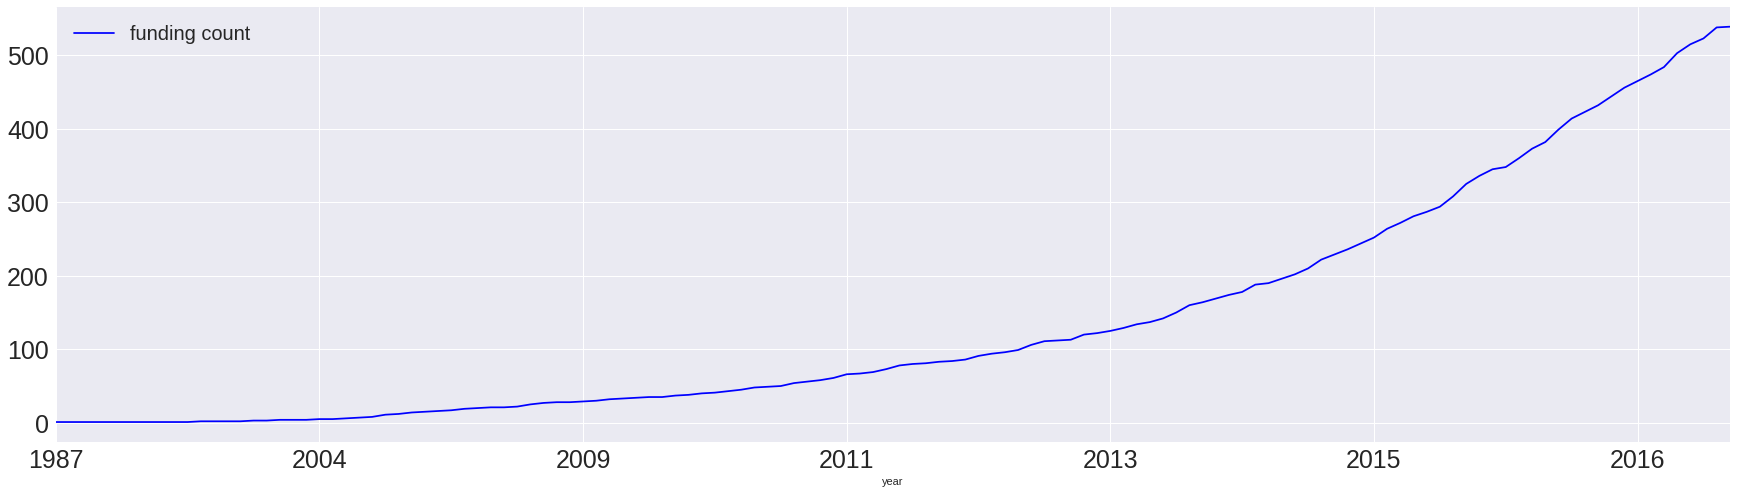

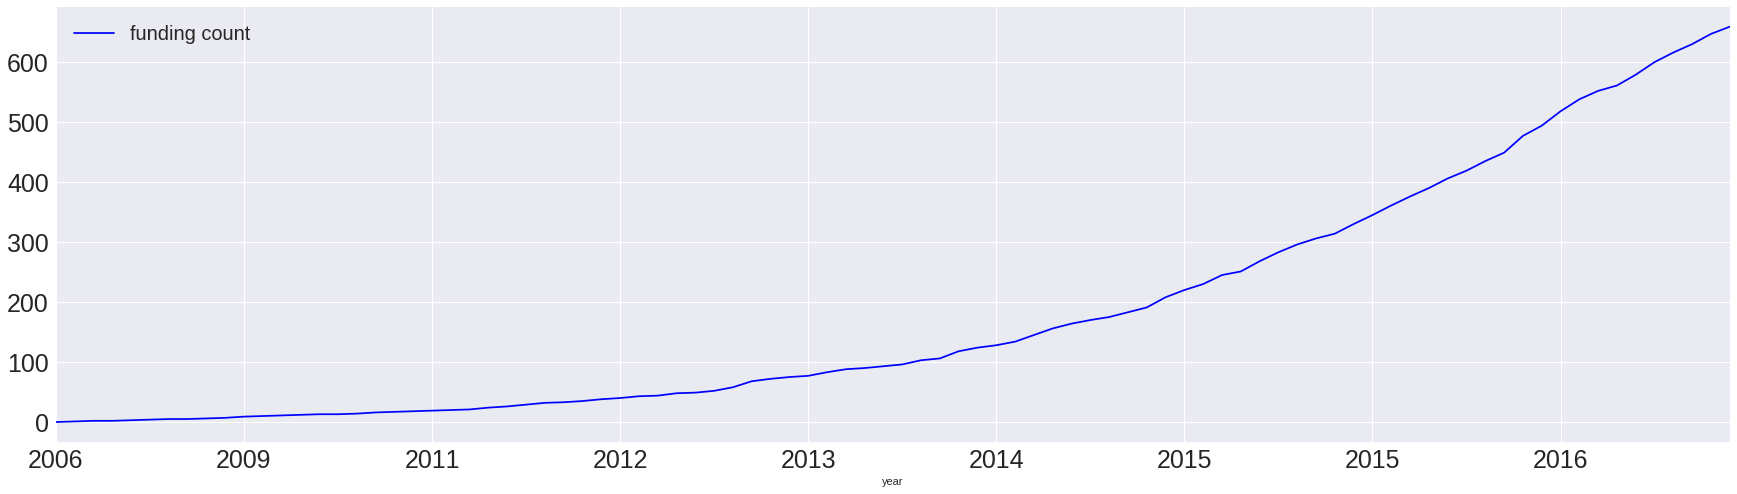

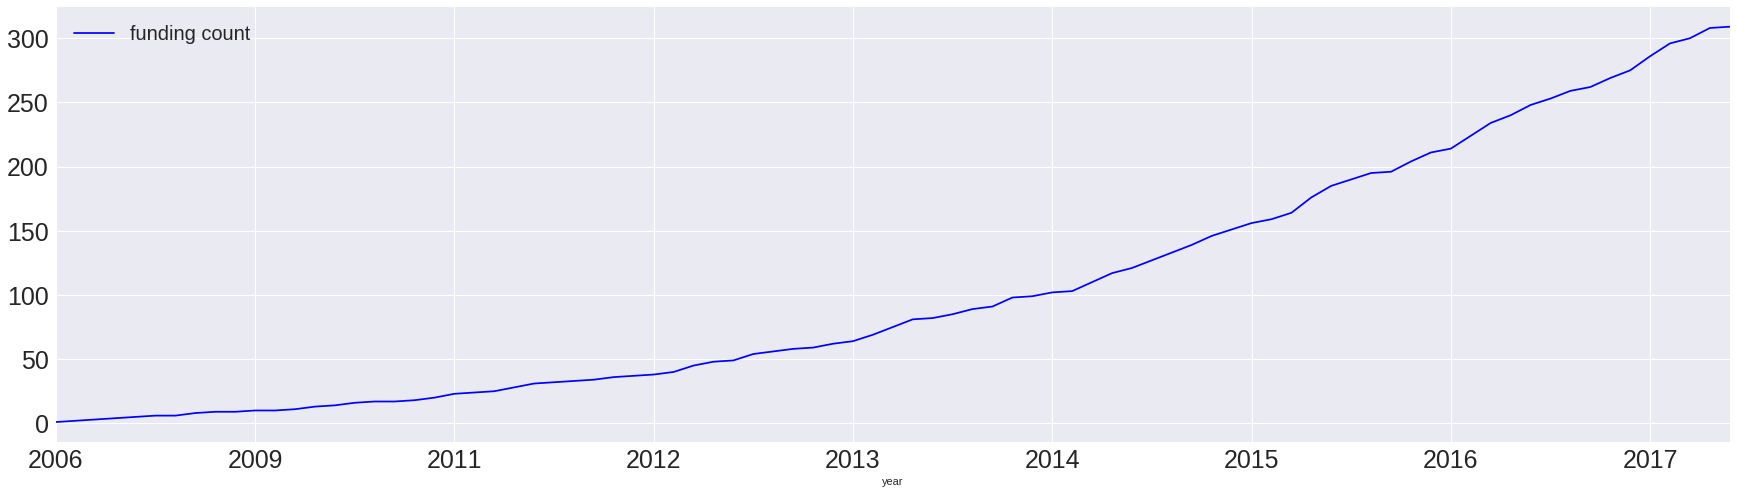

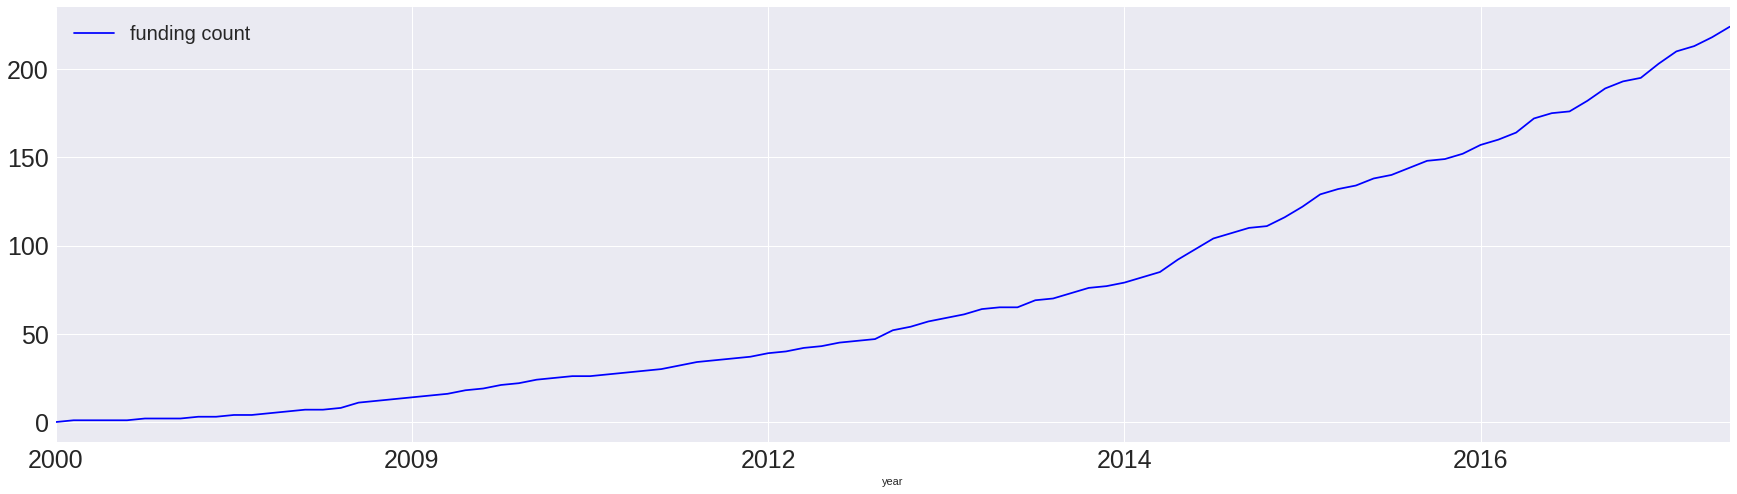

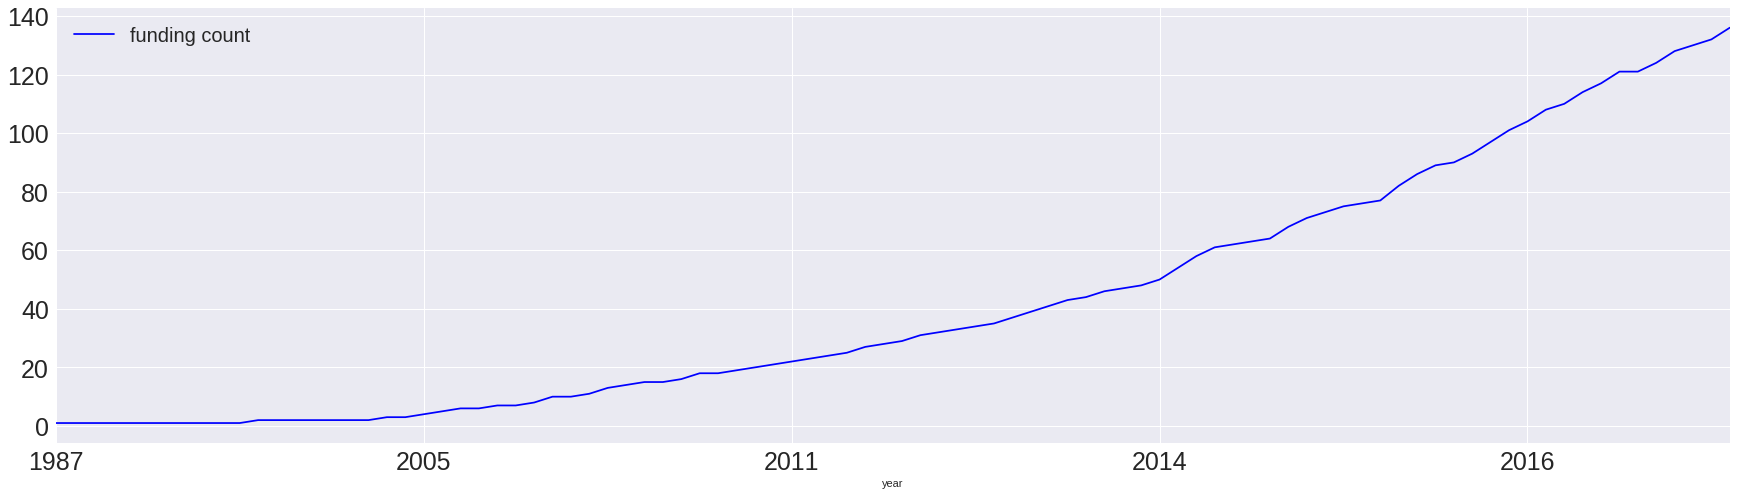

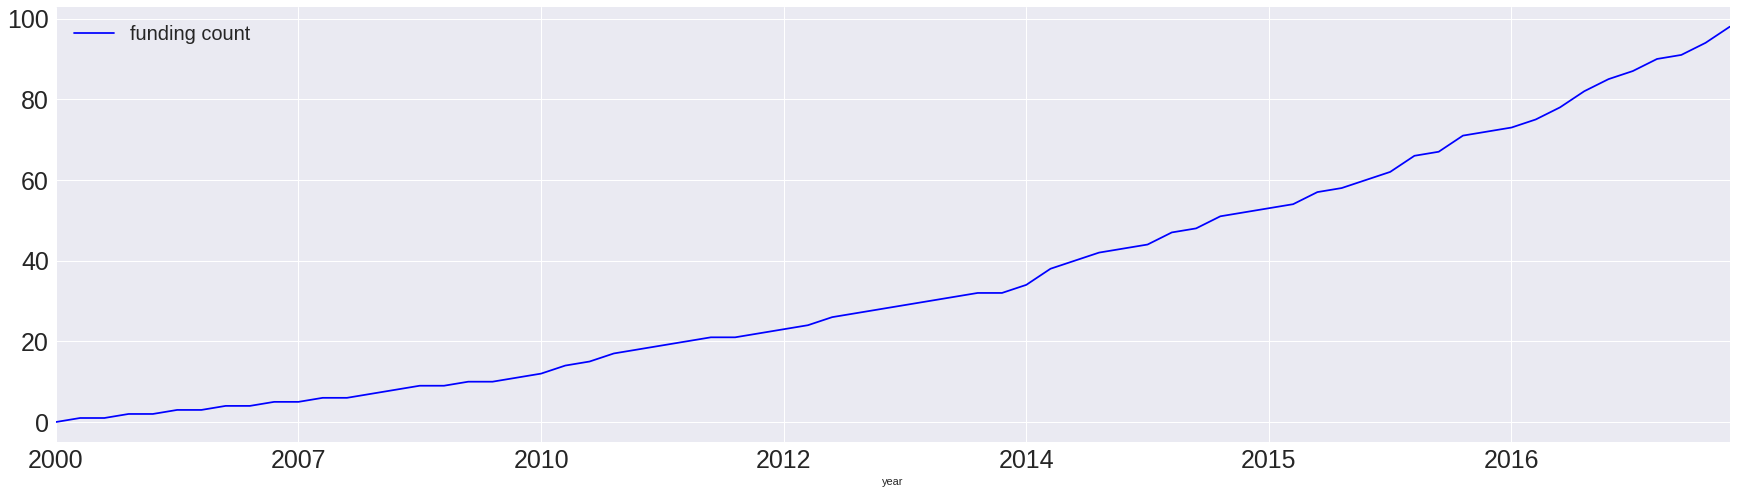

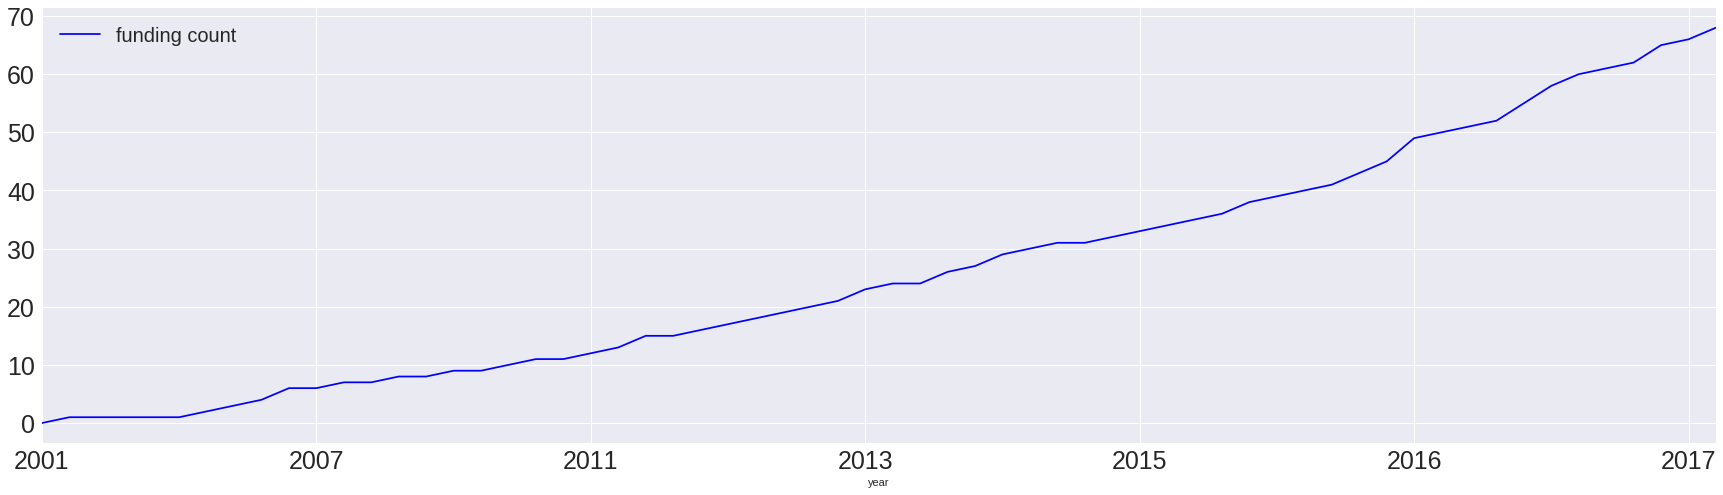

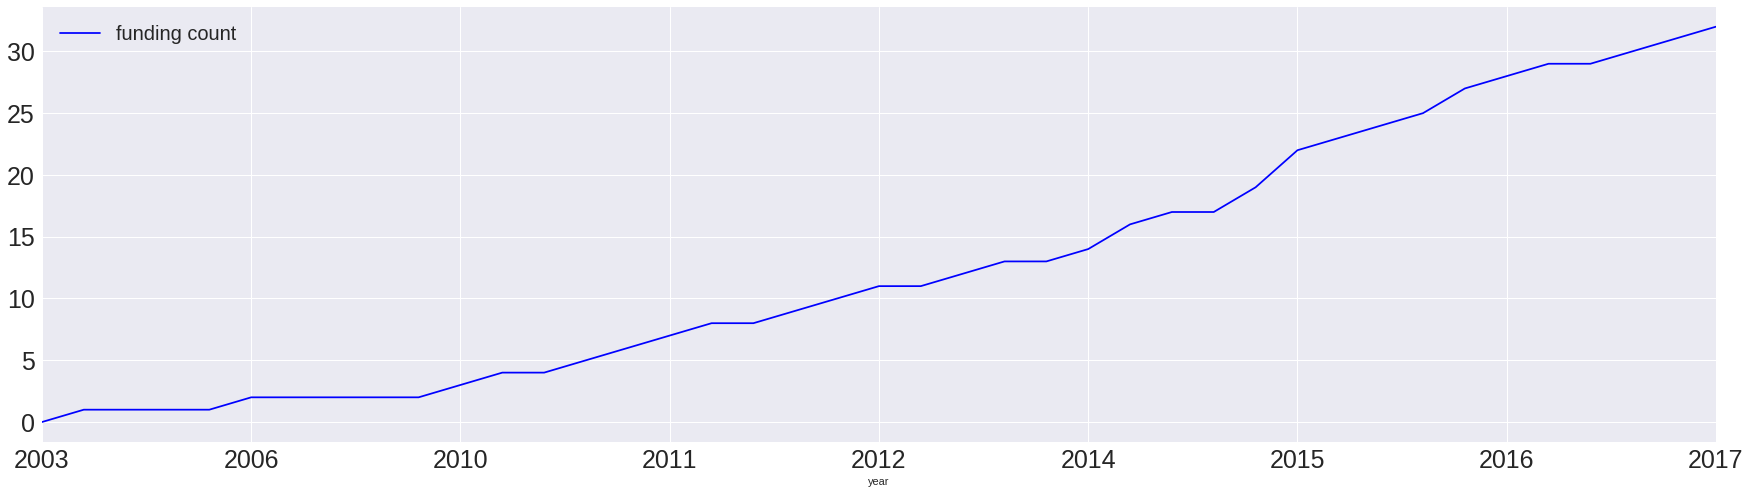

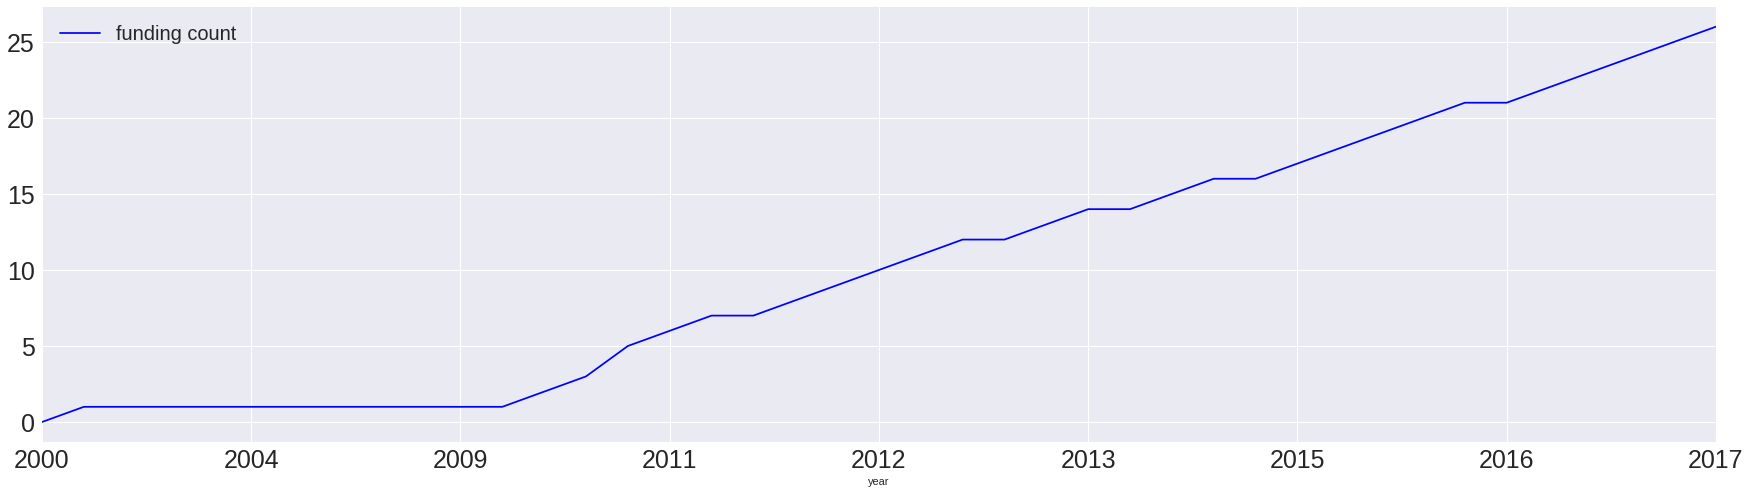

In [40]:
get_early_investors('artificial intelligence', investment_criteria=['seed', 'A', 'B', 'C'], early_investment_percent = 10, top_k = 30)
get_early_investors('artificial intelligence', investment_criteria=['seed'], early_investment_percent = 10, top_k = 30)
get_early_investors('artificial intelligence', investment_criteria=['A'], early_investment_percent = 10, top_k = 30)
get_early_investors('artificial intelligence', investment_criteria=['B'], early_investment_percent = 10, top_k = 30)
get_early_investors('artificial intelligence', investment_criteria=['C'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['consumer']
Early 10 percent investors before 2005-06-23 
(55 early fundings out of 554 total)
    count                     investor_name     date
0       3             CIBC Capital Partners  2002-09
1       3                    August Capital  1999-05
2       3                     Goldman Sachs  1999-12
3       3     VantagePoint Capital Partners  2002-09
4       3                       TransCosmos  1999-11
5       2         Internet Healthcare Group  2000-07
6       2                    J & W Seligman  2000-02
7       2                   Voyager Capital  1999-04
8       2                      SSM Partners  2001-07
9       2                           Ventech  2000-12
10      2  Kleiner Perkins Caufield & Byers  1991-09
11      2            C.E. Unterberg, Towbin  1999-04
12      2        Staenberg Venture Partners  1999-04
13      2                         Benchmark  1999-05
14      2             ARCH Venture Partners  1999-04
15      2                     Intel

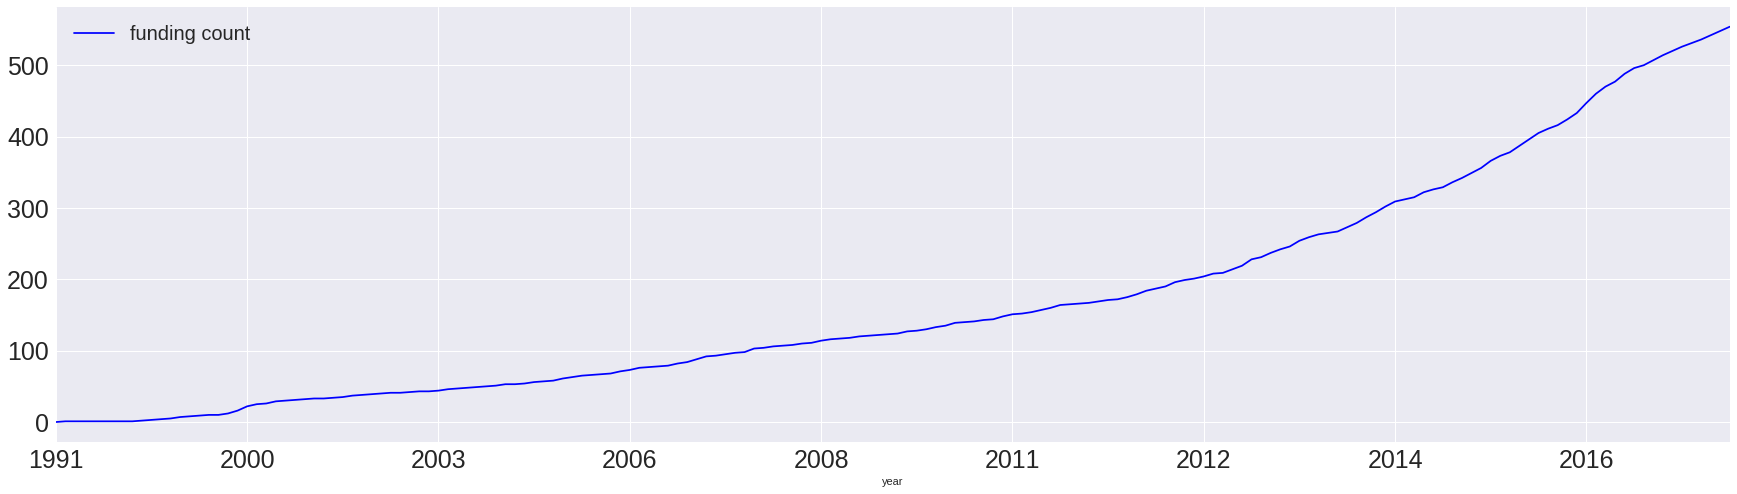

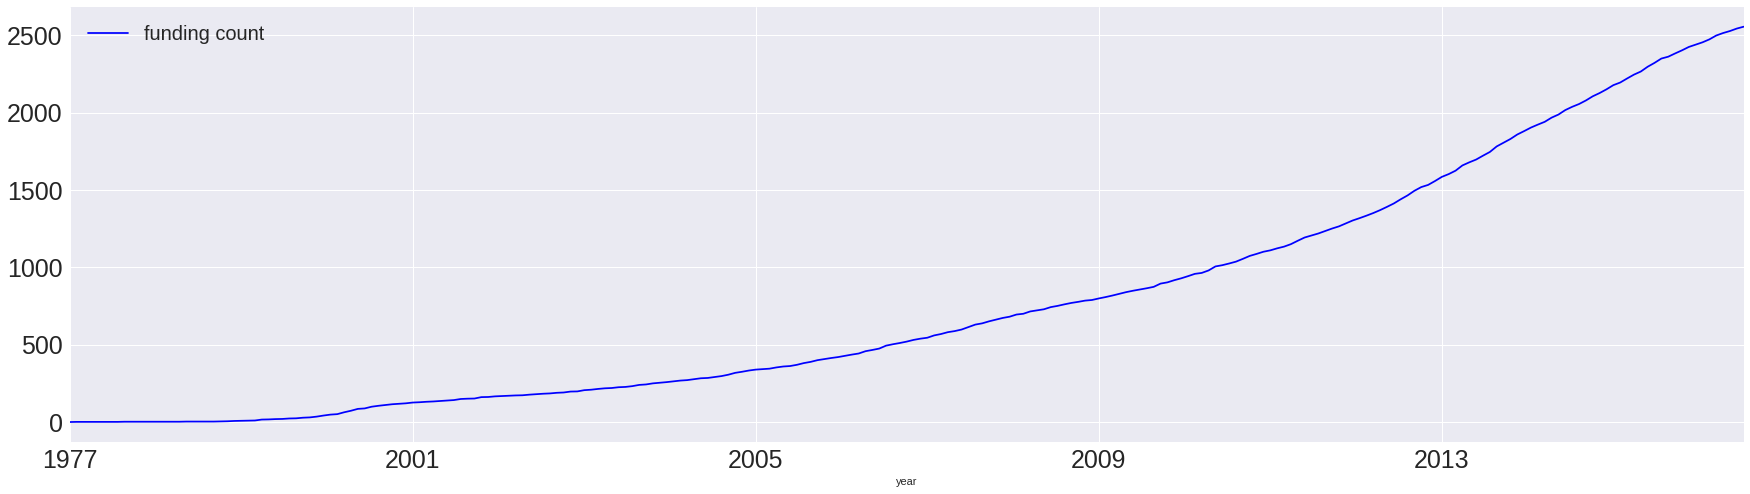

In [41]:
get_early_investors('consumer', investment_criteria=['seed', 'A', 'B', 'C'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['health care']
Early 10 percent investors before 2005-11-07 
(630 early fundings out of 6306 total)
    count                              investor_name     date
0      35                           Versant Ventures  2000-12
1      34                          Domain Associates  1999-02
2      31                  New Enterprise Associates  2000-06
3      23                                MPM Capital  1999-09
4      22                              Alta Partners  2000-04
5      22                        Three Arch Partners  2000-03
6      20                                    Venrock  1999-01
7      20                           Polaris Partners  1997-12
8      19                 Oxford Bioscience Partners  2001-01
9      18                            Canaan Partners  2000-06
10     18                         Sofinnova Ventures  2002-03
11     18                Frazier Healthcare Partners  2000-03
12     17                         InterWest Partners  2000-08
13     17 

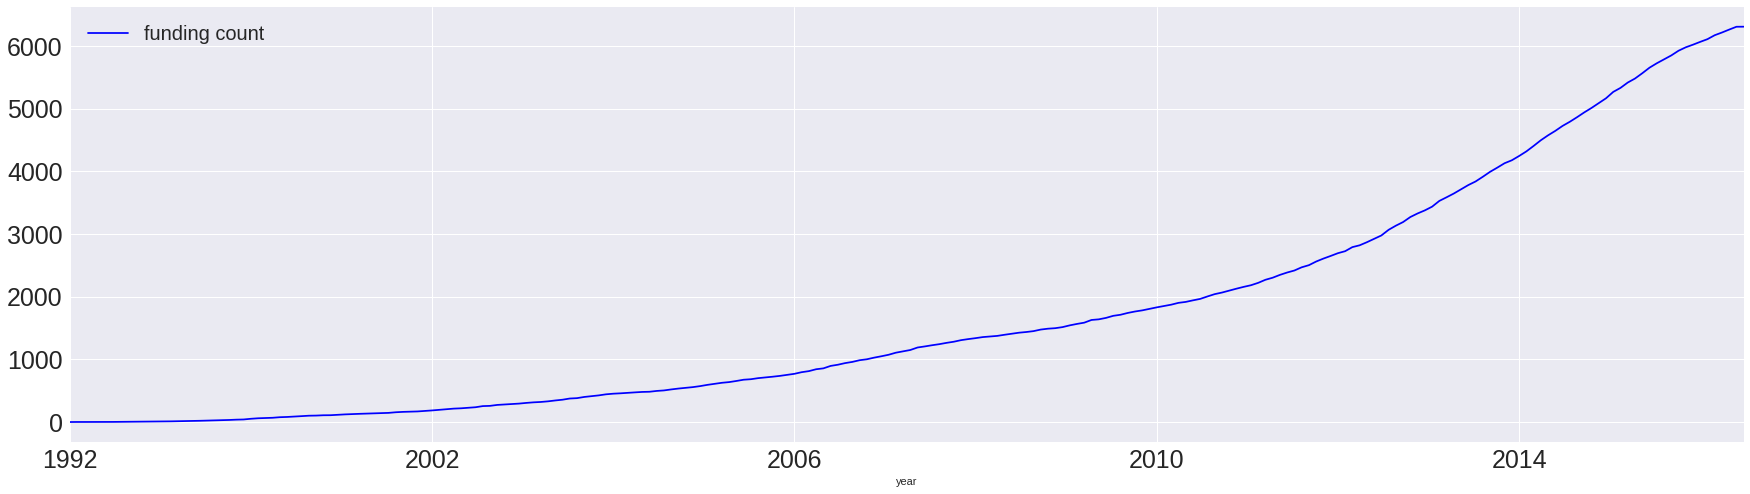

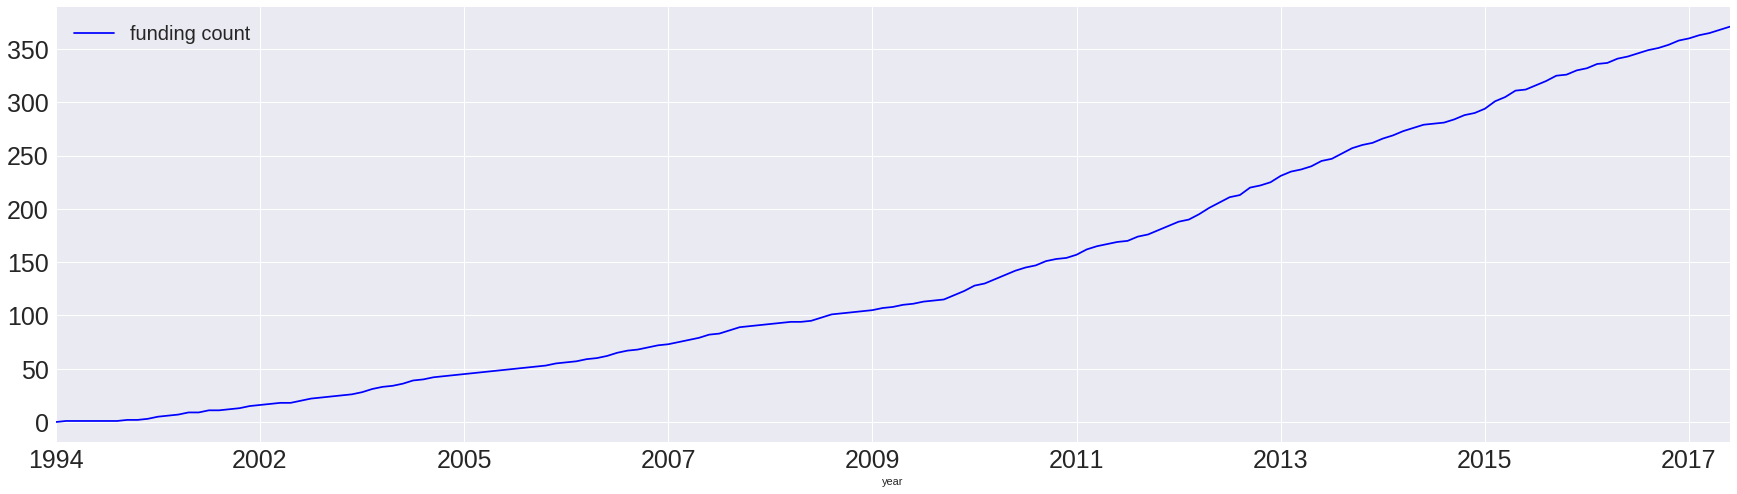

In [42]:
get_early_investors('health care', investment_criteria=['seed', 'A', 'B', 'C'], early_investment_percent = 10, top_k = 30)

Relevant categories: ['craft beer']
Early 10 percent investors before 2012-10-25 
(3 early fundings out of 35 total)
   count   investor_name     date
0      1    The Brandery  2011-08
1      1     PV Ventures  2010-11
2      1  Consor Capital  2006-11
(3, 3)
Keywords: ['craft_beer']
Early 10 percent investors before 2013-03-21 
(1 early fundings out of 11 total)
   count      investor_name     date
0      1  Cavallino Capital  2012-04
(1, 3)


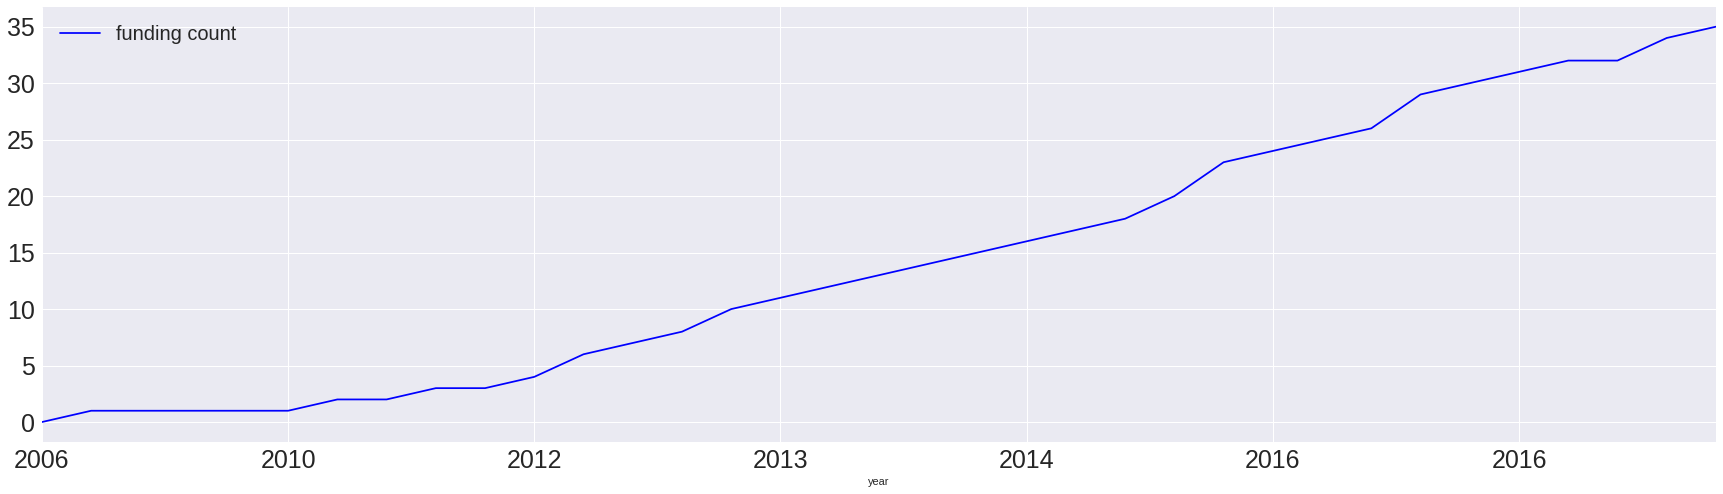

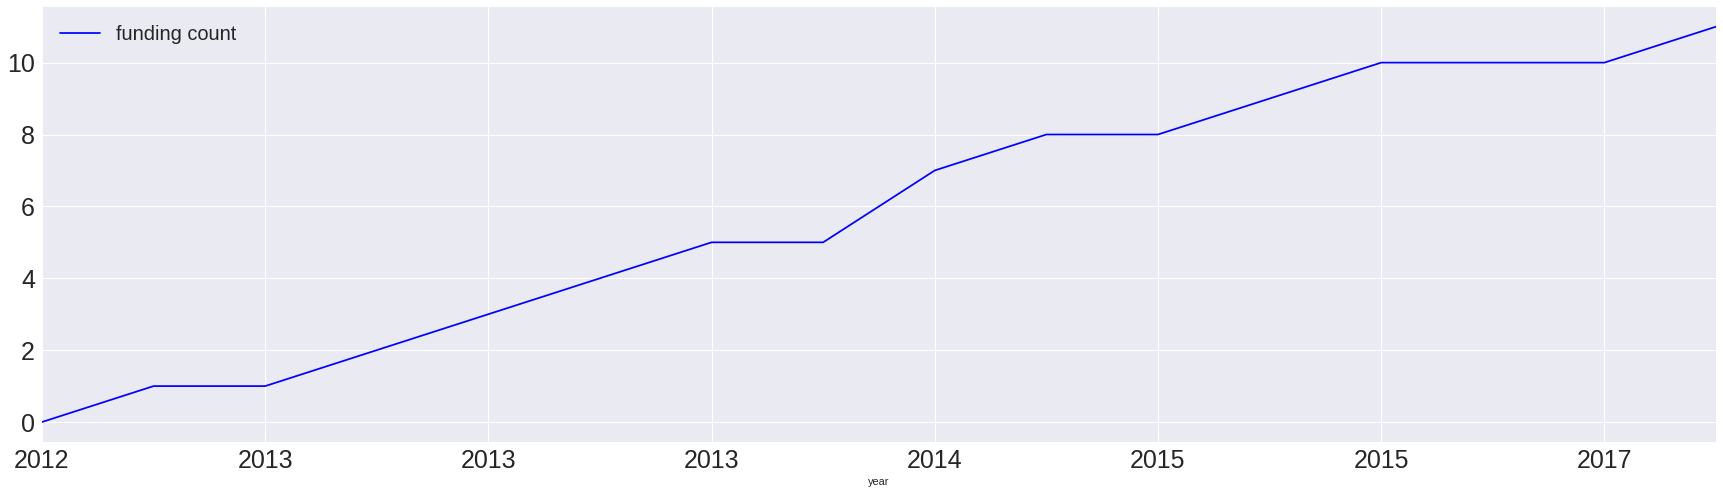

In [43]:
get_early_investors('craft beer', investment_criteria=['seed', 'A', 'B', 'C'], early_investment_percent = 10, top_k = 30)

In [44]:
# crunchbase 의 카테고리 정보로 빠른 투자자 vs 전체 그려보기
def plot_early_investors(category, weight_scheme = 'sqrt', TOP_K = 30, verbose = True, this_is_word = False, expand = False):
    color1 = 'black'
    color2 = 'blue'
    color3 = 'red'
    color4 = 'green'
    color5 = 'pink'
    
    # 일단은 centrality top VC 를 그려보자
    central = pickle.load(open(util_folder + 'investor_centrality_between_one_over_k.pickle'))
    topVC = [uuid for uuid, value in central[:TOP_K]]
    top_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(topVC)]['funding_round_uuid'].unique()
    
    if this_is_word:
        expert = pickle.load(open('../data/others/investor_sqrt_harmonic_rank_for_all.pickle'.format(category)))
        seed_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all.pickle'.format(category)))        
        other_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all_norm.pickle'.format(category)))        
    else:
#         expert = pickle.load(open('../data/others/investor_harmonic_rank_for_{}.pickle'.format(category)))
        expert = pickle.load(open('../data/others/investor_{}_harmonic_rank_for_{}.pickle'.format(weight_scheme, category)))
        seed_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all.pickle'.format(category)))        
        other_expert = pickle.load(open('../data/others/early_seed_investor_sqrt_harmonic_rank_for_all_norm.pickle'.format(category)))        
    expert = sorted(expert.items(), key = operator.itemgetter(1))
    expertVC = [uuid for uuid, value in expert[:TOP_K]]
    expert_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(expertVC)]['funding_round_uuid'].unique()

    seed_expert = sorted(seed_expert.items(), key = operator.itemgetter(1))
    seed_expertVC = [uuid for uuid, value in seed_expert[:TOP_K]]
    seed_expert_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(seed_expertVC)]['funding_round_uuid'].unique()

    other_expert = sorted(other_expert.items(), key = operator.itemgetter(1))
    other_expertVC = [uuid for uuid, value in other_expert[:TOP_K]]
    other_expert_funding_round_uuids = df_investments[df_investments['investor_uuid'].isin(other_expertVC)]['funding_round_uuid'].unique()

    if this_is_word:
        if 'word2company' not in globals():
            print('loading word2company')
            global word2company
            word2company = pickle.load(open(util_folder + 'word2company.pickle'))
        if 'model' not in globals():
            print('loading word2vec model')
            global model
            model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

        words = category
        final_words = []
        if type(words) == str:
            words = [words]
        for word in words:
            if ' ' in word:
                word = word.replace(' ', '_')
            if expand:
                if word not in model: continue
                _words = model.most_similar(word)
                _words = [str(_word) for _word, sim in _words]
                final_words.extend(_words)
            final_words.append(word)
        final_words = list(set(final_words))
        print final_words

        # 해당 단어가 있는 회사들을 모은다
        companies = []
        for word in final_words:
            _companies = word2company.get(word, [])
            companies.extend(_companies)
        companies = list(set(companies))

#         if category not in word2company:
#             print 'word', category, 'is not in dataset'
#             return
        df = df_funding[df_funding['company_uuid'].isin(companies)].drop_duplicates('funding_round_uuid')    
    else:
        df = df_funding[df_funding['category'] == category].drop_duplicates('funding_round_uuid')
    df_top = df[df['funding_round_uuid'].isin(top_funding_round_uuids)]
    df_expert = df[df['funding_round_uuid'].isin(expert_funding_round_uuids)]
    df_seed_expert = df[df['funding_round_uuid'].isin(seed_expert_funding_round_uuids)]
    df_other_expert = df[df['funding_round_uuid'].isin(other_expert_funding_round_uuids)]

#     print "Category:",category
#     print '# investment by all VC', df.shape[0]
#     print '# investment by top VC', df_top.shape[0]
#     print '# investment by expert VC', df_expert.shape[0]
#     print '# investment by seed expert VC', df_seed_expert.shape[0]
# #     print '# investment by other expert VC', df_other_expert.shape[0]
    
    if verbose:
        for vc in expertVC[:TOP_K]:
            print df_investors[df_investors['uuid'] == (vc)]['investor_name'].values[0]
    try:
        start_year = min(df['year-month'].values)[:4]
    except Exception as e:
        print 'no data'
        return
    
    count = df.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count').reset_index()
    count_seed_all = df[df['funding_round_type'] == 'seed'].groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_seed_all').reset_index()
    count_top = df_top.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_top').reset_index()
    count_expert = df_expert.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_expert').reset_index()
    count_seed_expert = df_seed_expert.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_seed_expert').reset_index()
    count_other_expert = df_other_expert.groupby('year-month')['investor_uuid'].apply(lambda x: len(x)).rename('count_other_expert').reset_index()

    for year in range(int(start_year), 2018):
        year = str(year)
        if count[count['year-month'] == '{}-01'.format(year)].shape[0] == 0:
            count.loc[-1] = ['{}-01'.format(year), 0]
            count.index = count.index + 1
    count['year'] = np.where(True, count['year-month'].str[:4], '')
    count = count.merge(count_top, on = 'year-month', how = 'left')
    count = count.merge(count_expert, on = 'year-month', how = 'left')
    count = count.merge(count_seed_expert, on = 'year-month', how = 'left')
    count = count.merge(count_other_expert, on = 'year-month', how = 'left')
    count = count.merge(count_seed_all, on = 'year-month', how = 'left')
    
    count = count.sort_values('year-month')
    count = count.fillna(0)

    count['cum_count'] = count['count'].cumsum()
    count['cum_count'] = count['cum_count'] / max(count['cum_count'])

    count['cum_count_seed_all'] = count['count_seed_all'].cumsum()
    count['cum_count_seed_all'] = count['cum_count_seed_all'] / max(count['cum_count_seed_all'])

    count['cum_count_top'] = count['count_top'].cumsum()
    count['cum_count_top'] = count['cum_count_top'] / max(count['cum_count_top'])

    count['cum_count_expert'] = count['count_expert'].cumsum()
    count['cum_count_expert'] = count['cum_count_expert'] / max(count['cum_count_expert'])
    
    count['cum_count_seed_expert'] = count['count_seed_expert'].cumsum()
    count['cum_count_seed_expert'] = count['cum_count_seed_expert'] / max(count['cum_count_seed_expert'])

    count['cum_count_other_expert'] = count['count_other_expert'].cumsum()
    count['cum_count_other_expert'] = count['cum_count_other_expert'] / max(count['cum_count_other_expert'])

#     count[['year-month', 'cum_count', 'cum_count_top', 'cum_count_expert', 'cum_count_seed_expert', 'cum_count_seed_all']].plot(x = count['year'], linestyle = '-', color = [color1, color2, color3, color4, color5], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['All', 'Top VC (Centrality)', 'Early VC (All)', 'Early VC (Seed)', 'Seed'])%%!
    count[['year-month', 'cum_count', 'cum_count_seed_all', 'cum_count_expert', 'cum_count_seed_expert']].plot(x = count['year'], linestyle = '-', color = [color1, color2, color3, color4], fontsize = 25, figsize = (30, 8)).legend(loc = 2, fontsize = 20, labels = ['All', 'Seed', 'Early VC (All)', 'Early VC (Seed)'])
    plt.title(category, fontsize = 35)
    plt.show()

Category: software
# investment by all VC 15892
# investment by top VC 1405
# investment by expert VC 1254
# investment by seed expert VC 796


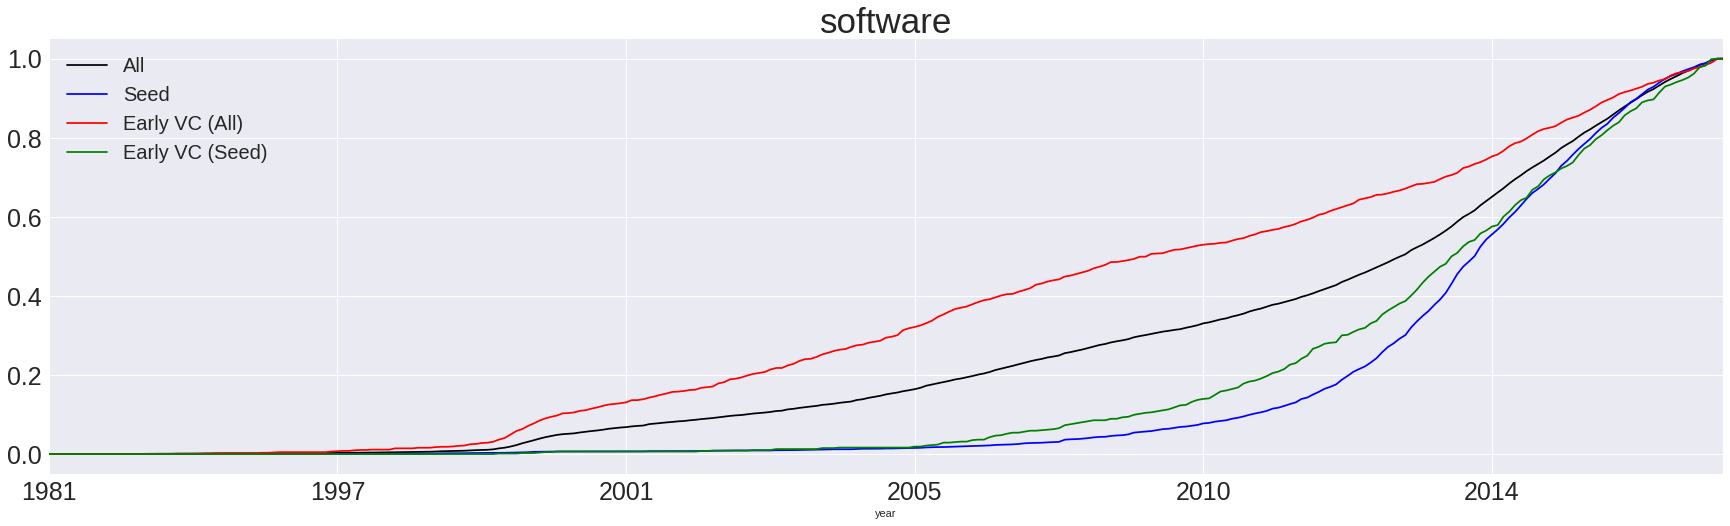

Category: mobile
# investment by all VC 12275
# investment by top VC 1329
# investment by expert VC 945
# investment by seed expert VC 753


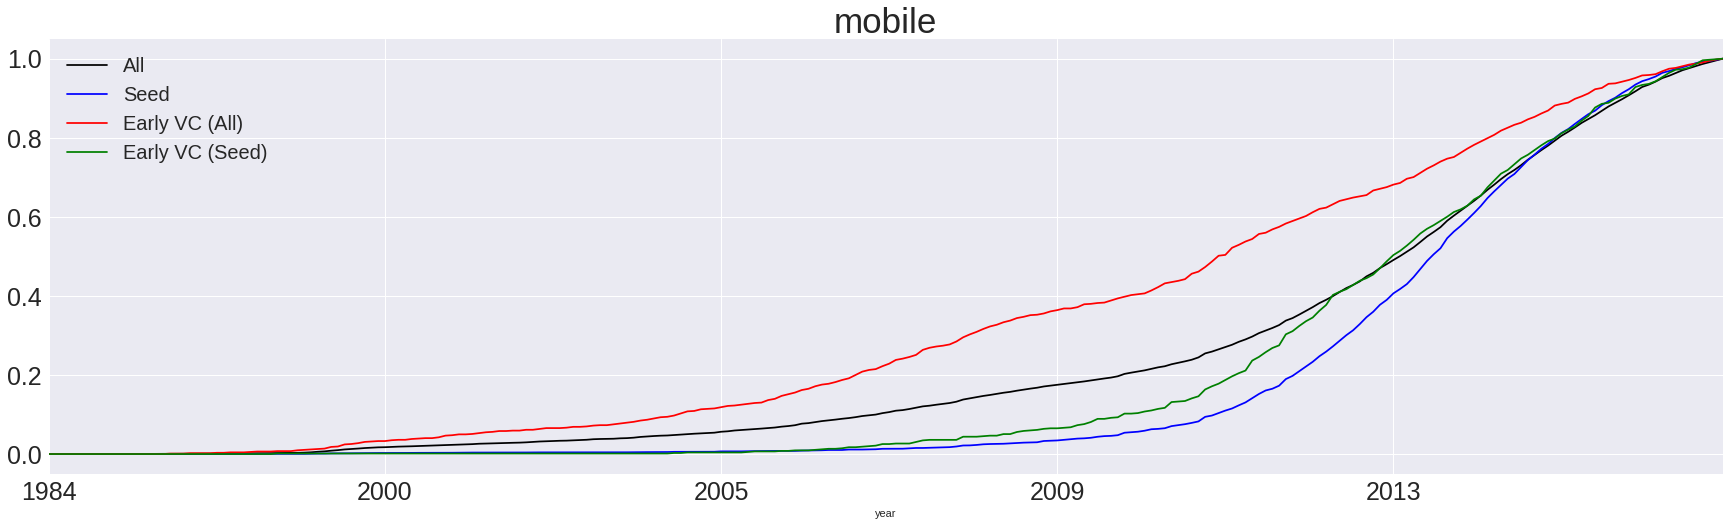

Category: health care
# investment by all VC 10972
# investment by top VC 690
# investment by expert VC 543
# investment by seed expert VC 374


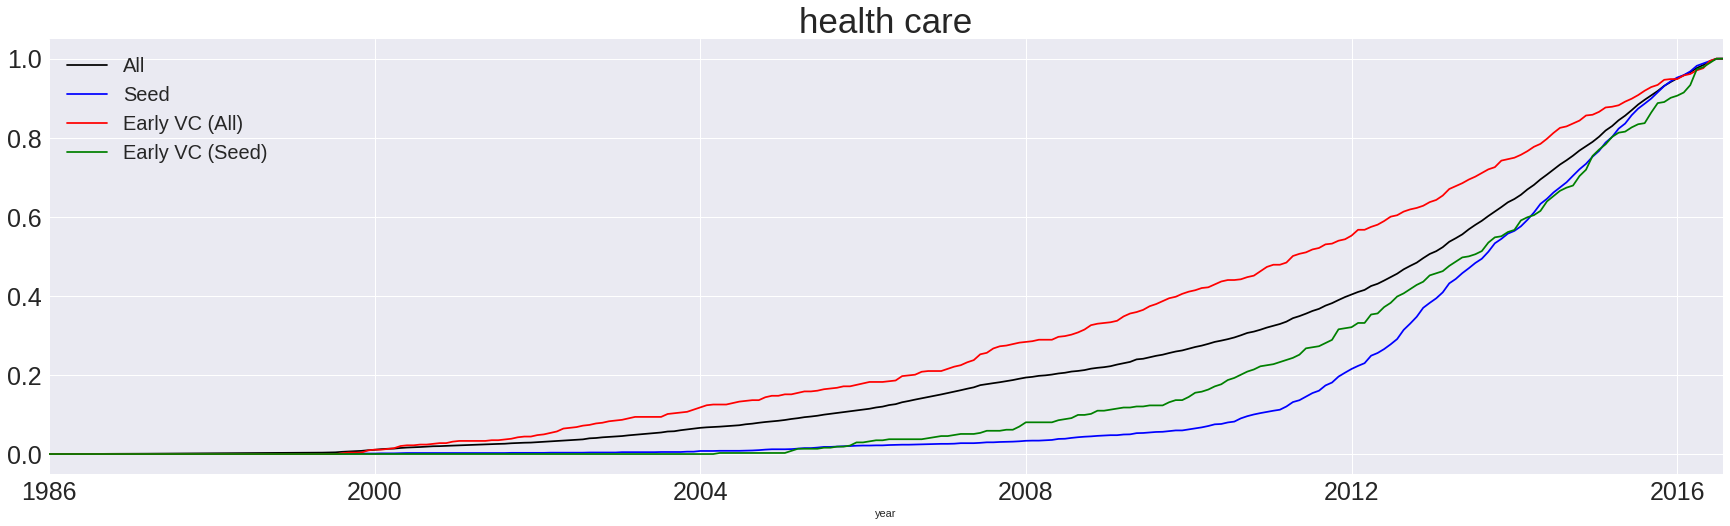

Category: enterprise software
# investment by all VC 9600
# investment by top VC 1163
# investment by expert VC 1019
# investment by seed expert VC 487


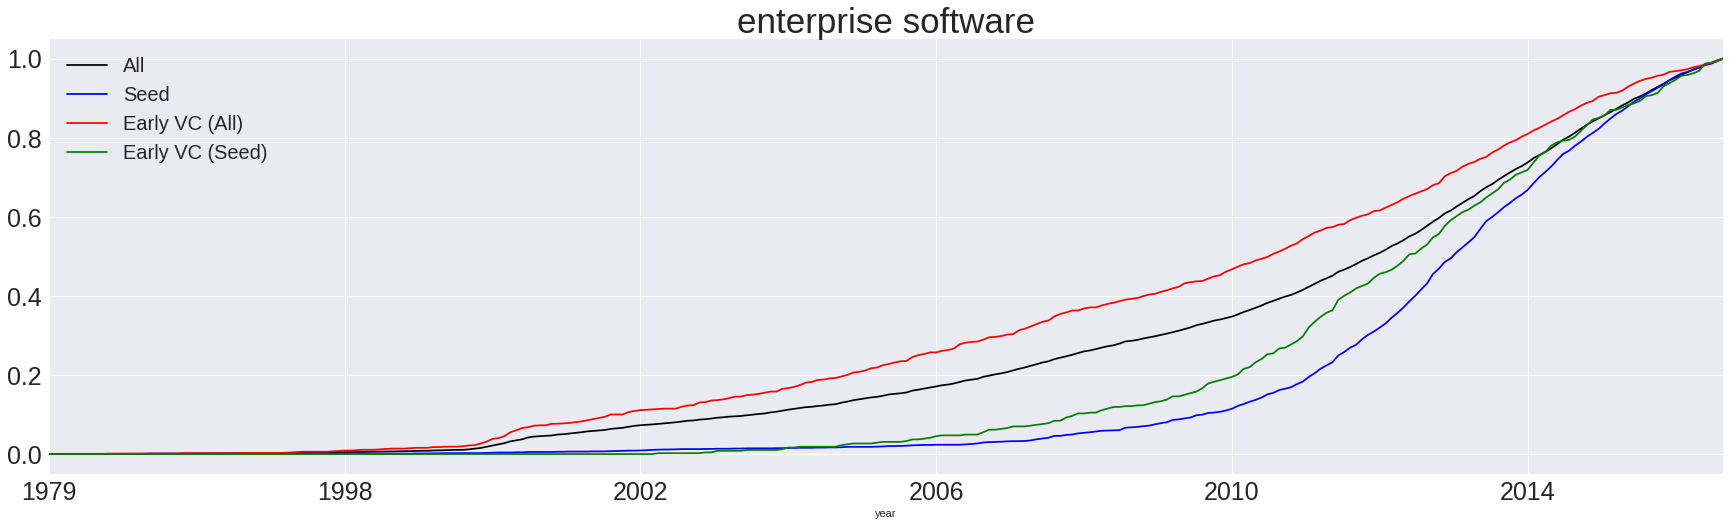

Category: e-commerce
# investment by all VC 9173
# investment by top VC 963
# investment by expert VC 612
# investment by seed expert VC 632


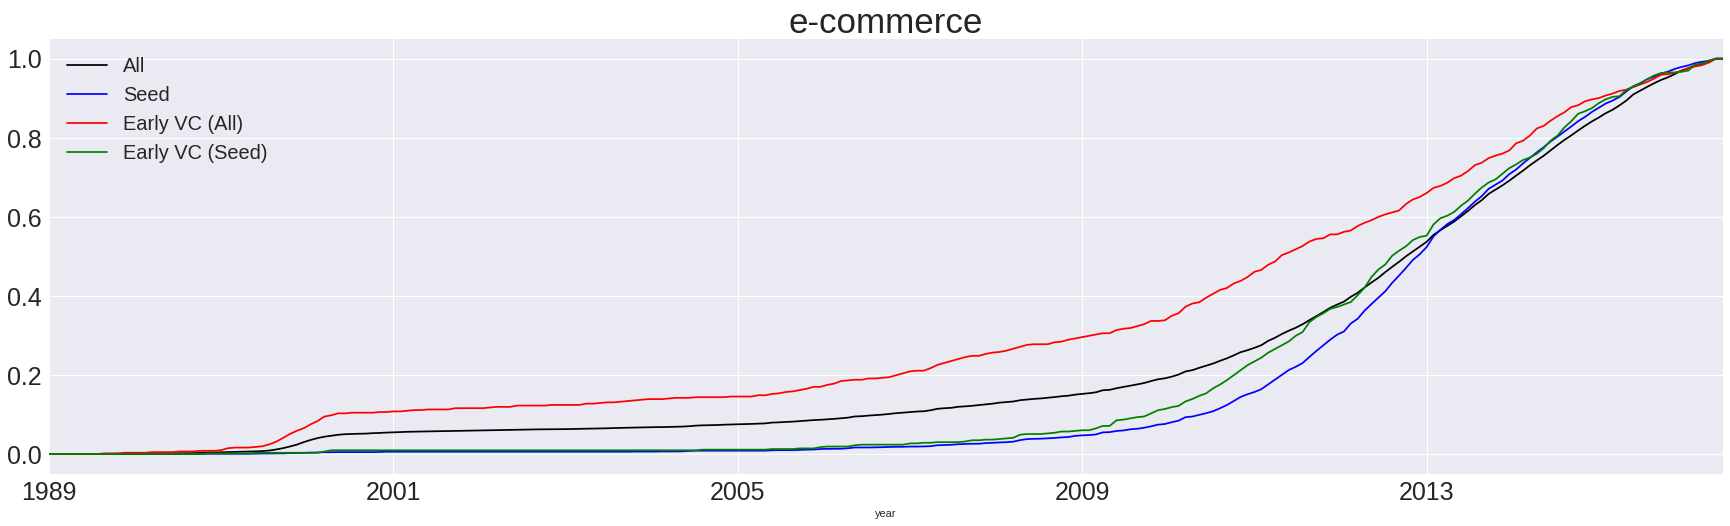

Category: internet
# investment by all VC 8314
# investment by top VC 1037
# investment by expert VC 911
# investment by seed expert VC 396


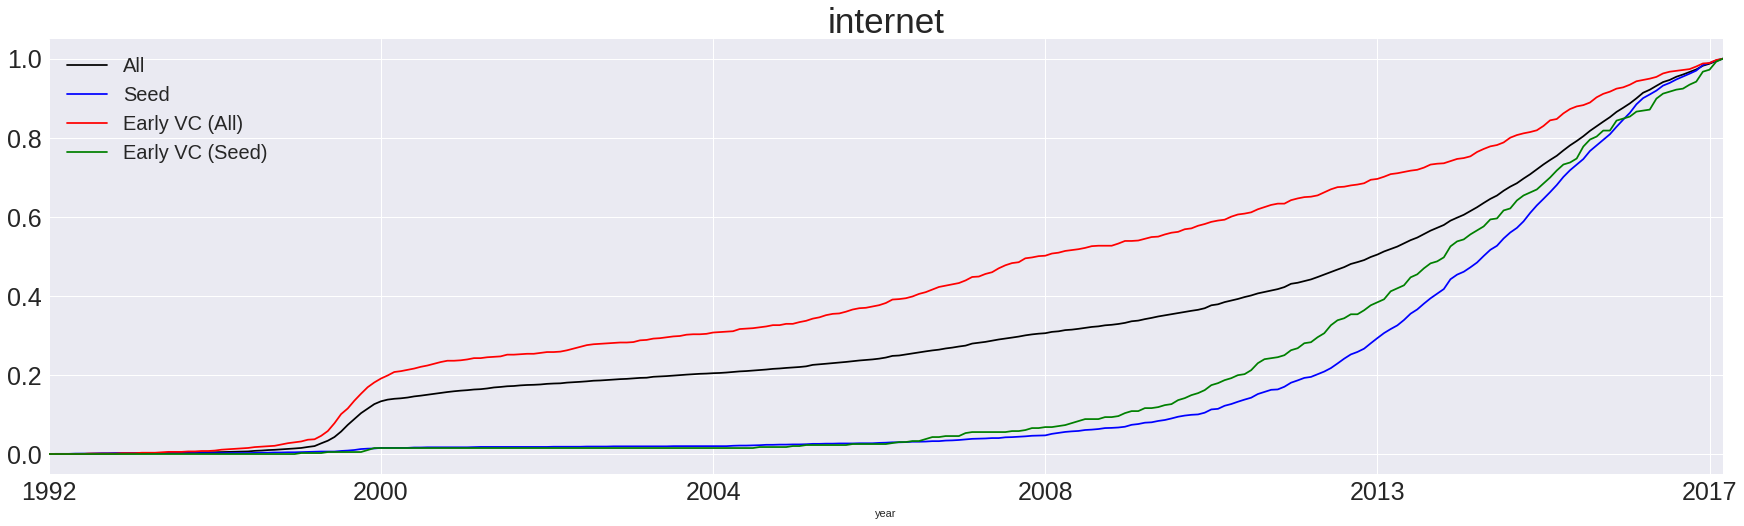

Category: biotechnology
# investment by all VC 7931
# investment by top VC 456
# investment by expert VC 406
# investment by seed expert VC 199


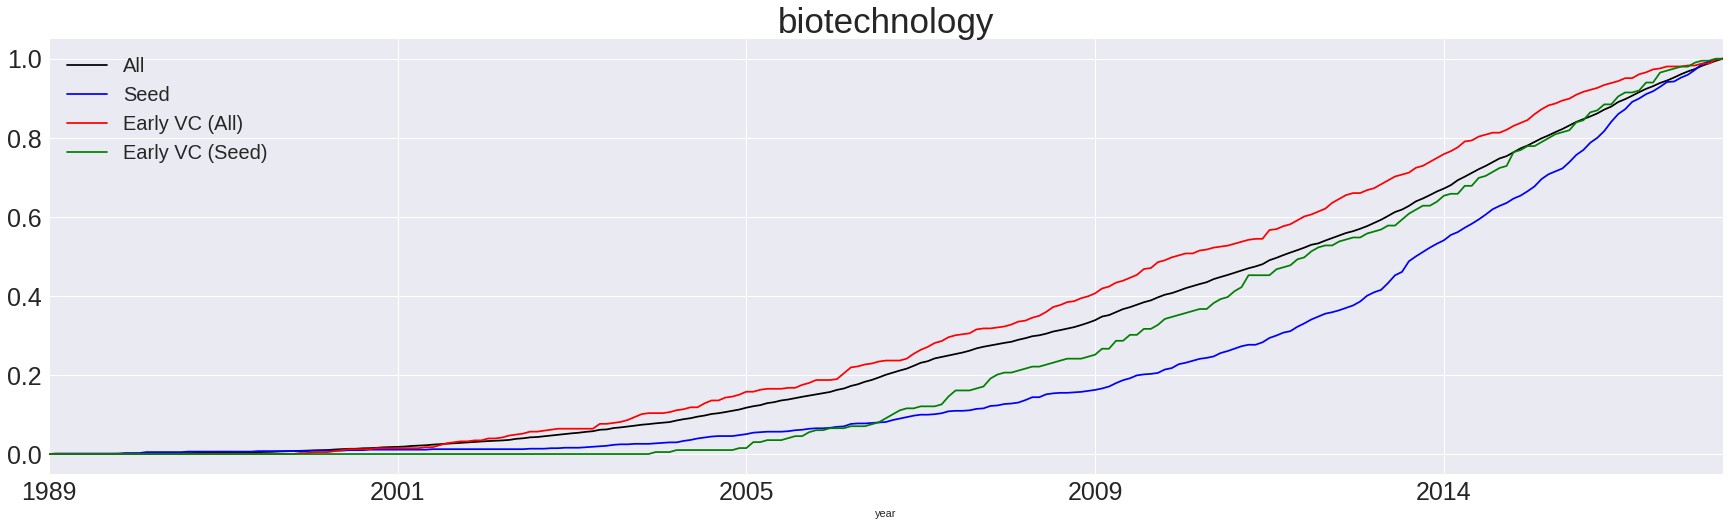

Category: information technology
# investment by all VC 6659
# investment by top VC 495
# investment by expert VC 473
# investment by seed expert VC 232


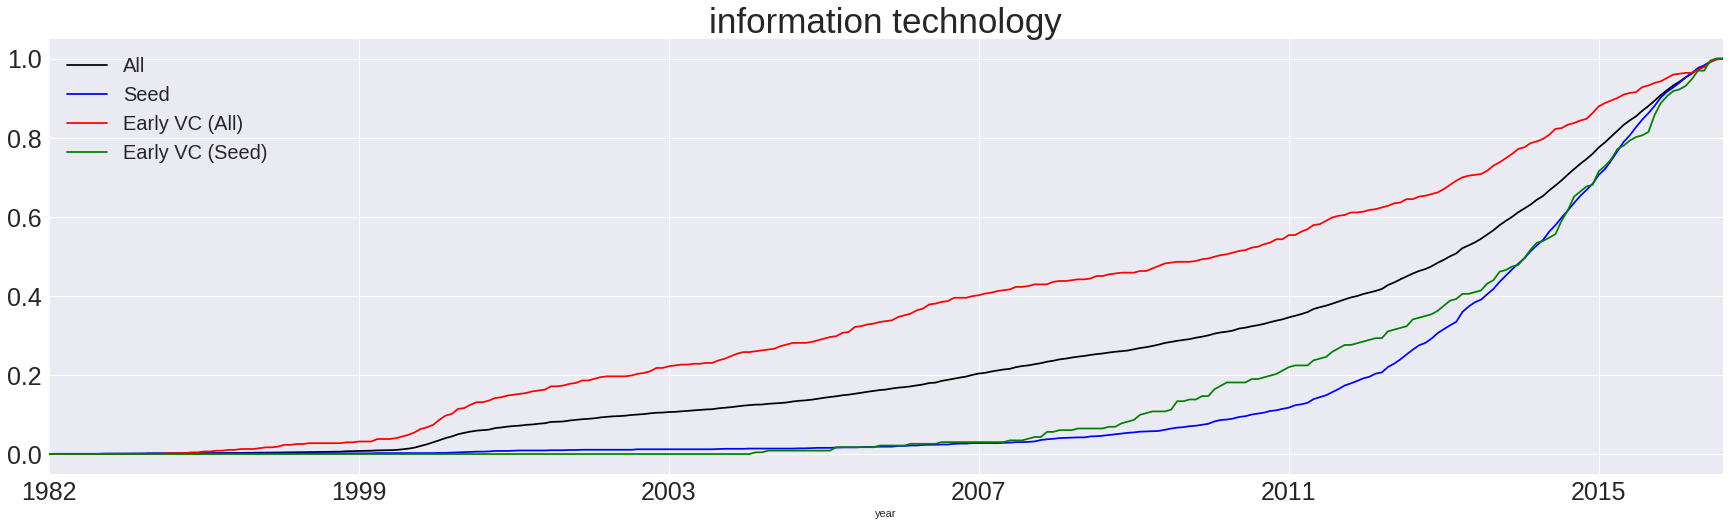

Category: saas
# investment by all VC 6240
# investment by top VC 608
# investment by expert VC 385
# investment by seed expert VC 441


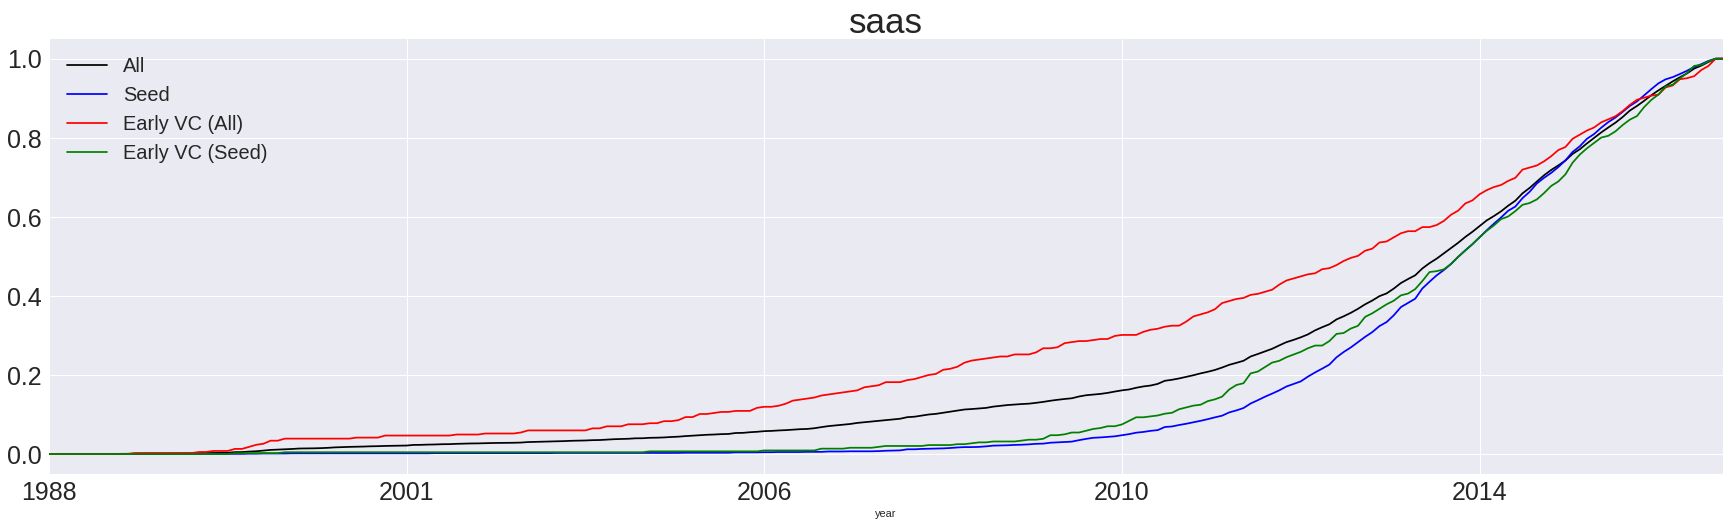

Category: analytics
# investment by all VC 5959
# investment by top VC 654
# investment by expert VC 494
# investment by seed expert VC 404


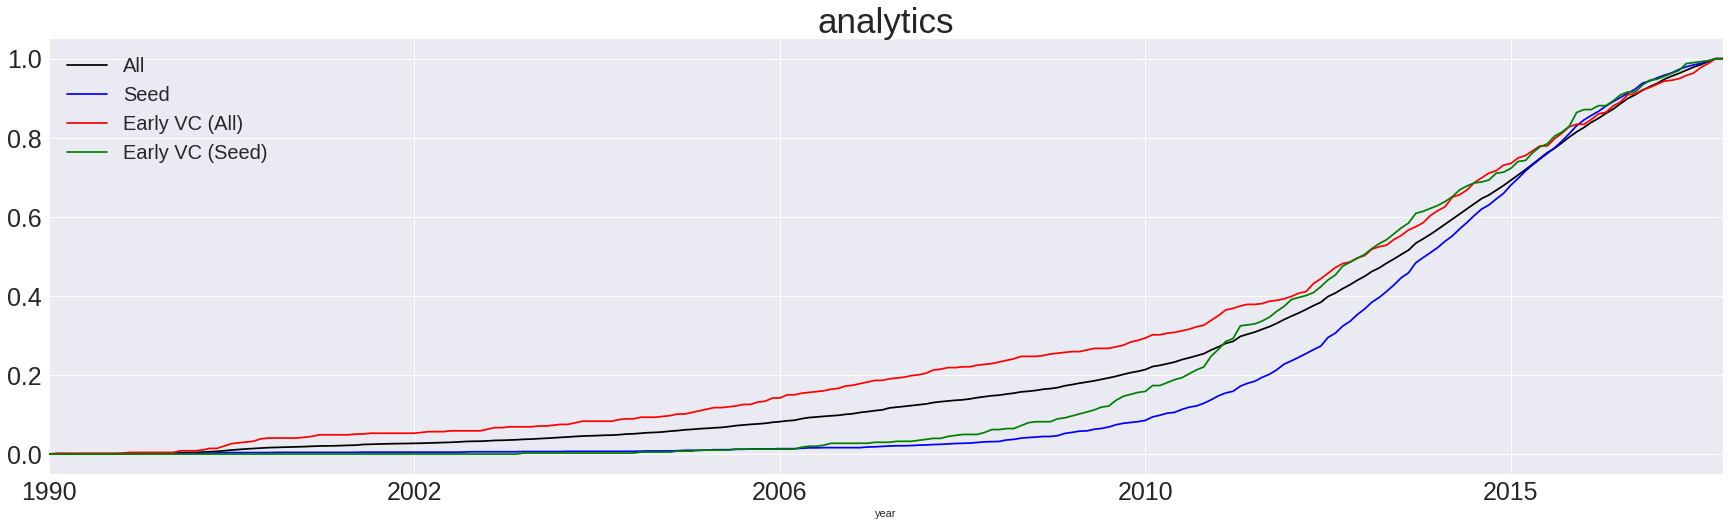

Category: advertising
# investment by all VC 4872
# investment by top VC 407
# investment by expert VC 331
# investment by seed expert VC 307


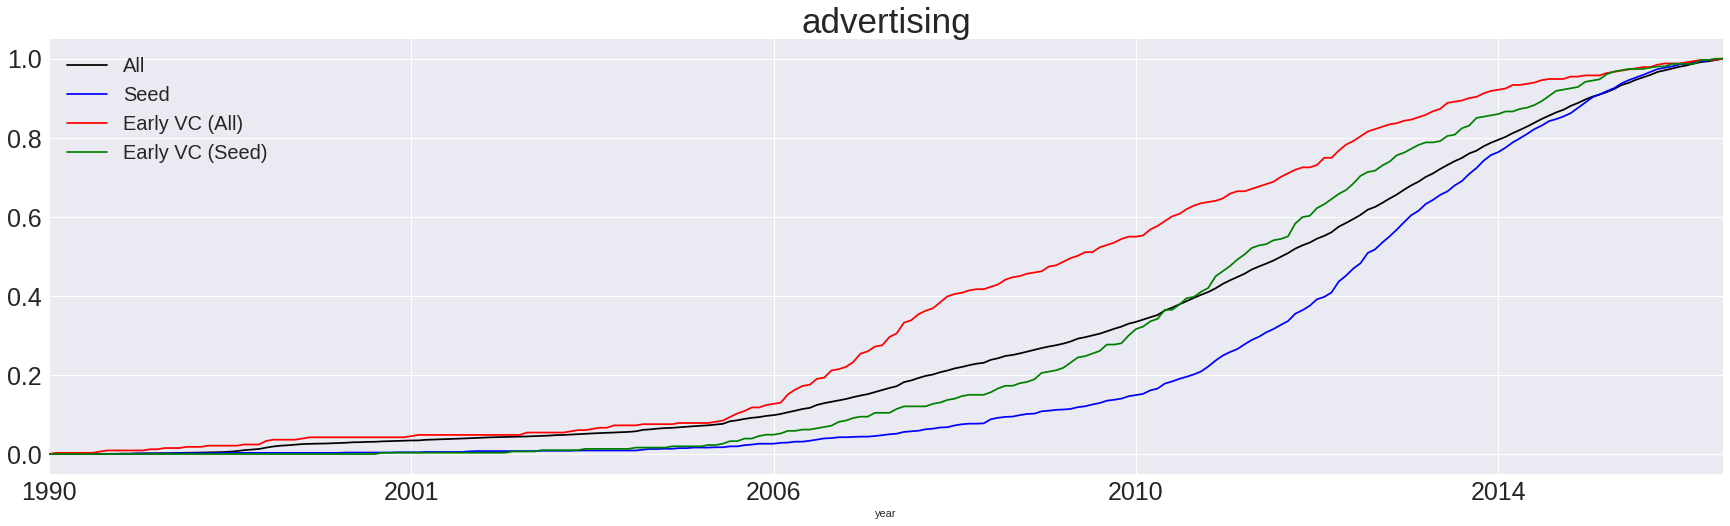

Category: manufacturing
# investment by all VC 4829
# investment by top VC 392
# investment by expert VC 534
# investment by seed expert VC 119


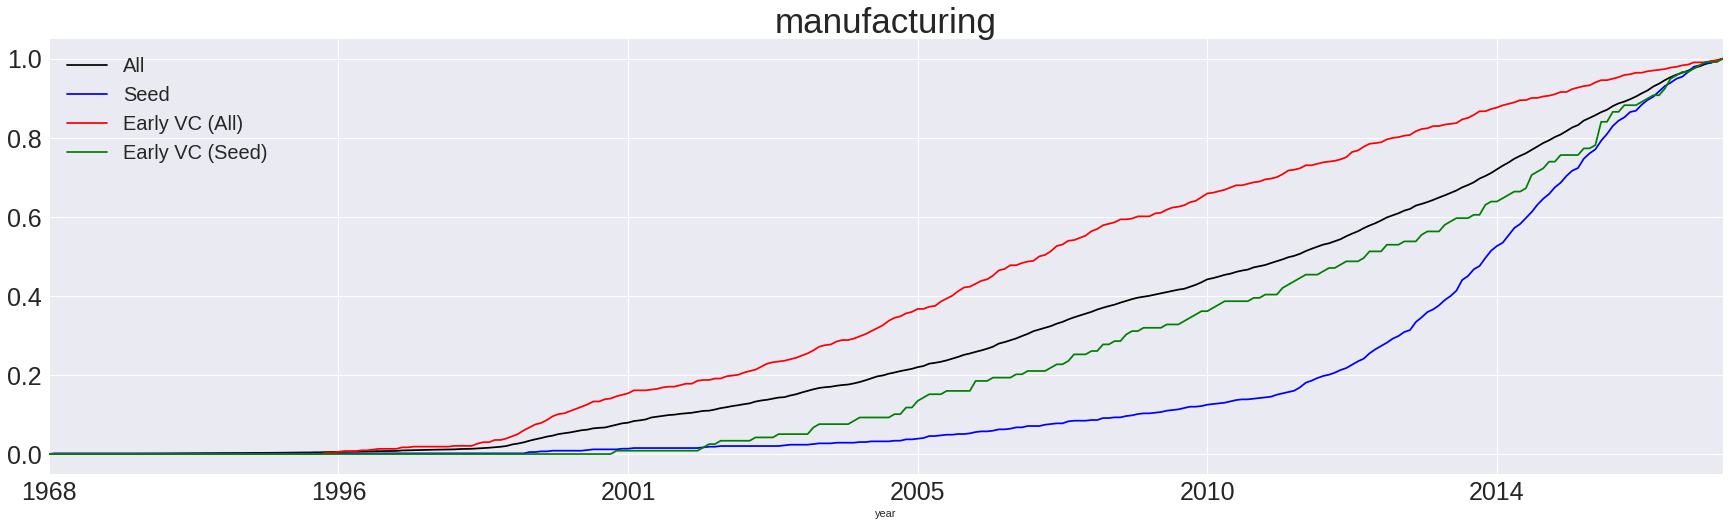

Category: medical
# investment by all VC 4767
# investment by top VC 246
# investment by expert VC 215
# investment by seed expert VC 147


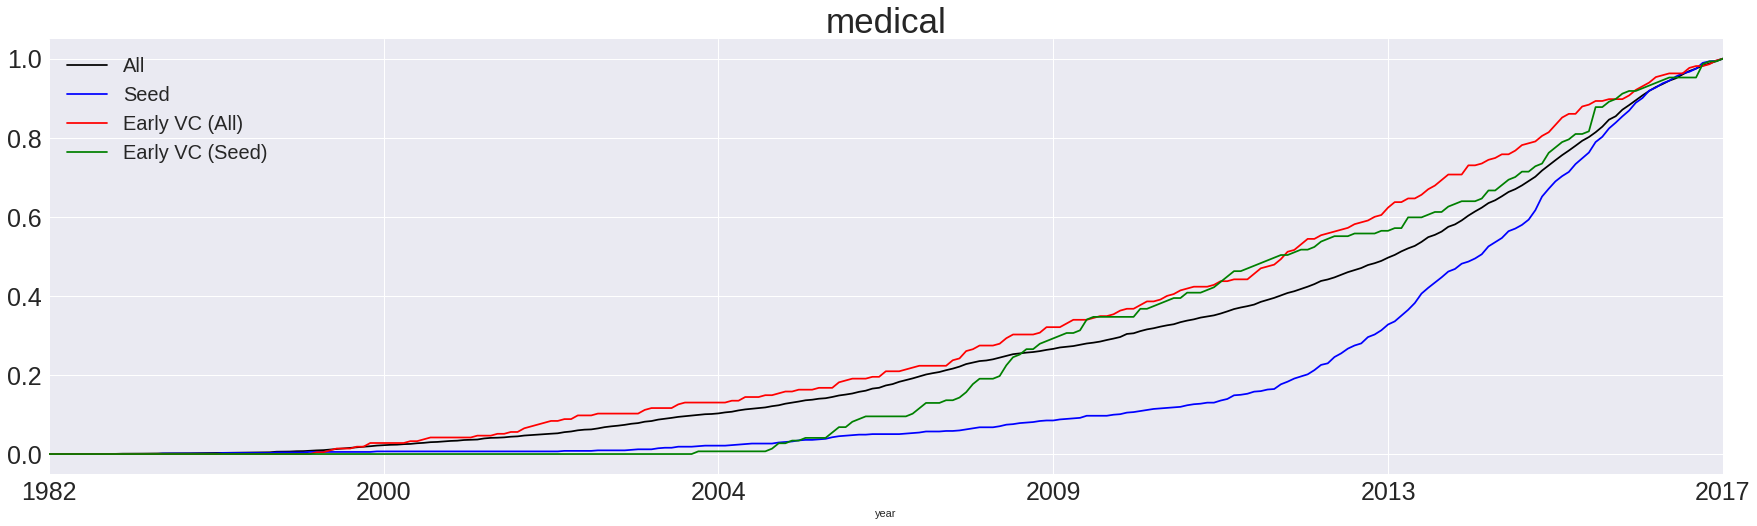

Category: apps
# investment by all VC 4493
# investment by top VC 496
# investment by expert VC 276
# investment by seed expert VC 334


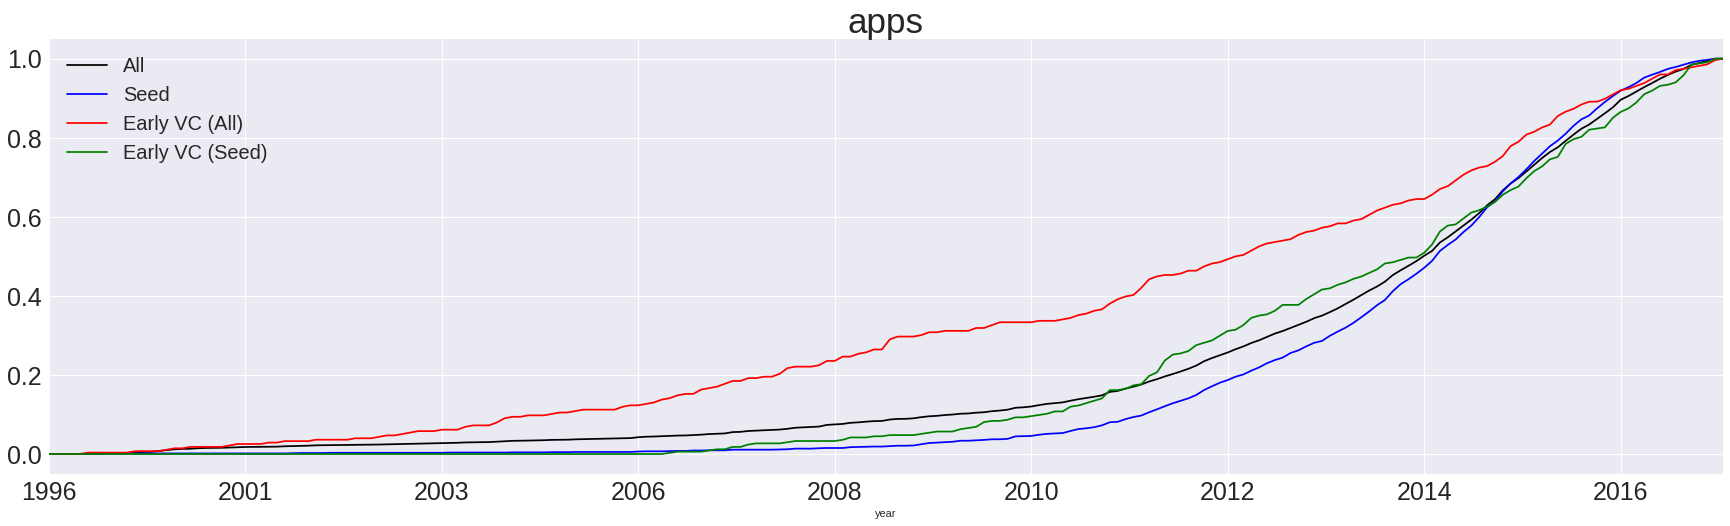

Category: social media
# investment by all VC 4357
# investment by top VC 392
# investment by expert VC 251
# investment by seed expert VC 301


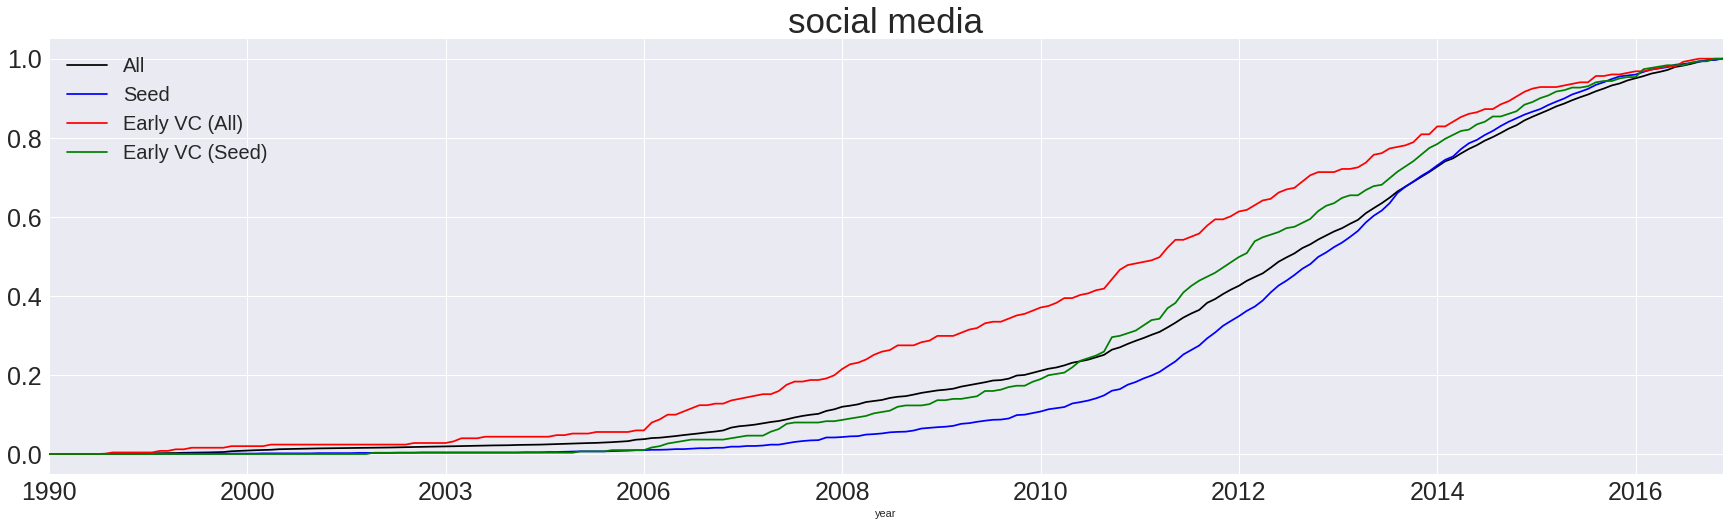

Category: education
# investment by all VC 3717
# investment by top VC 281
# investment by expert VC 147
# investment by seed expert VC 239


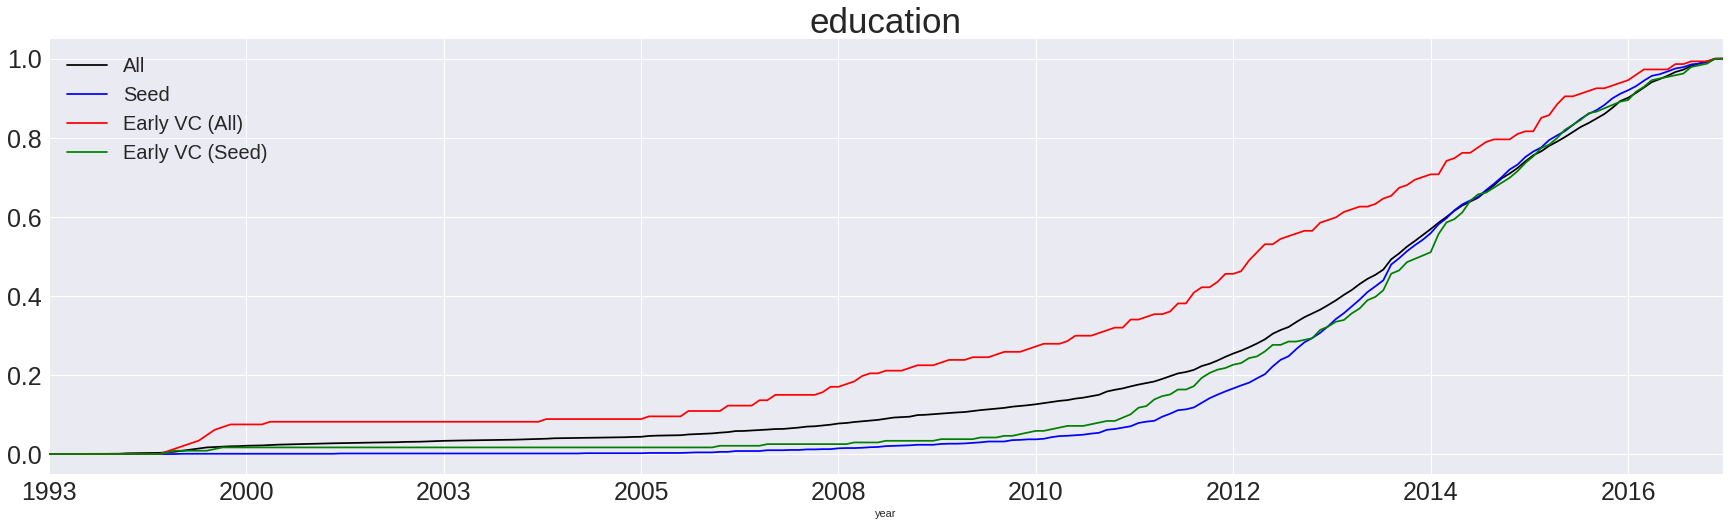

Category: finance
# investment by all VC 3650
# investment by top VC 288
# investment by expert VC 199
# investment by seed expert VC 366


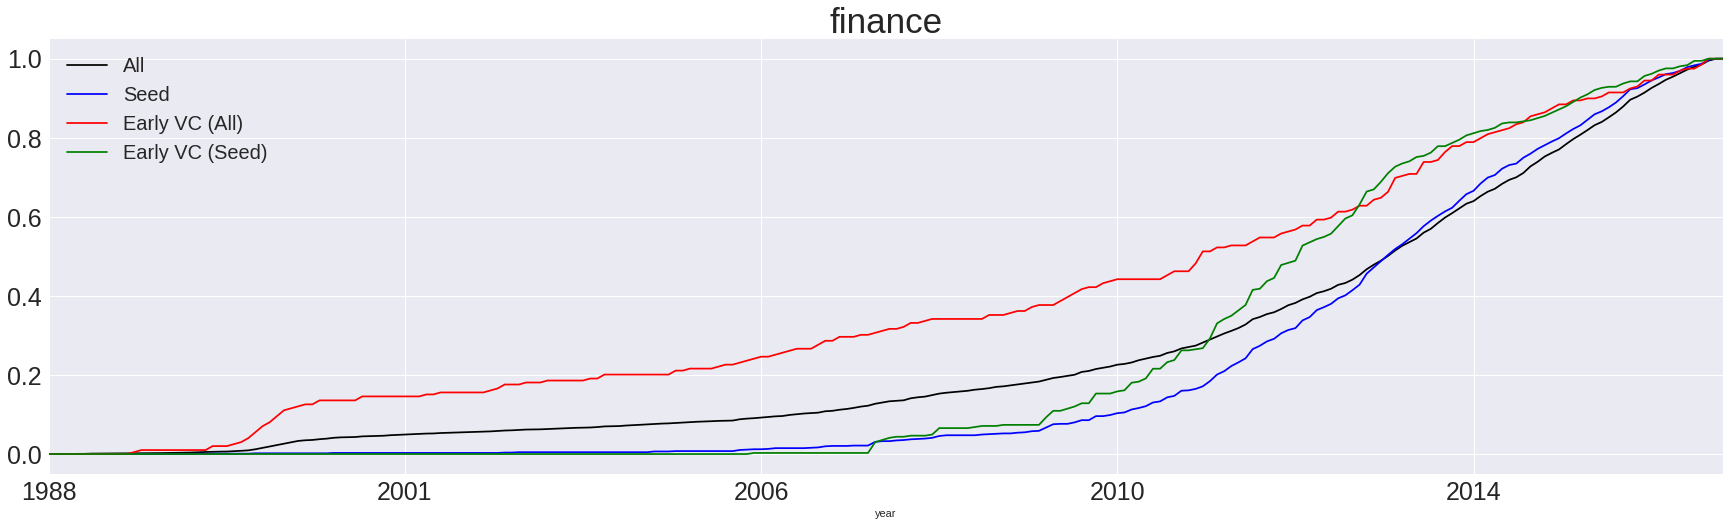

Category: big data
# investment by all VC 3482
# investment by top VC 406
# investment by expert VC 280
# investment by seed expert VC 232


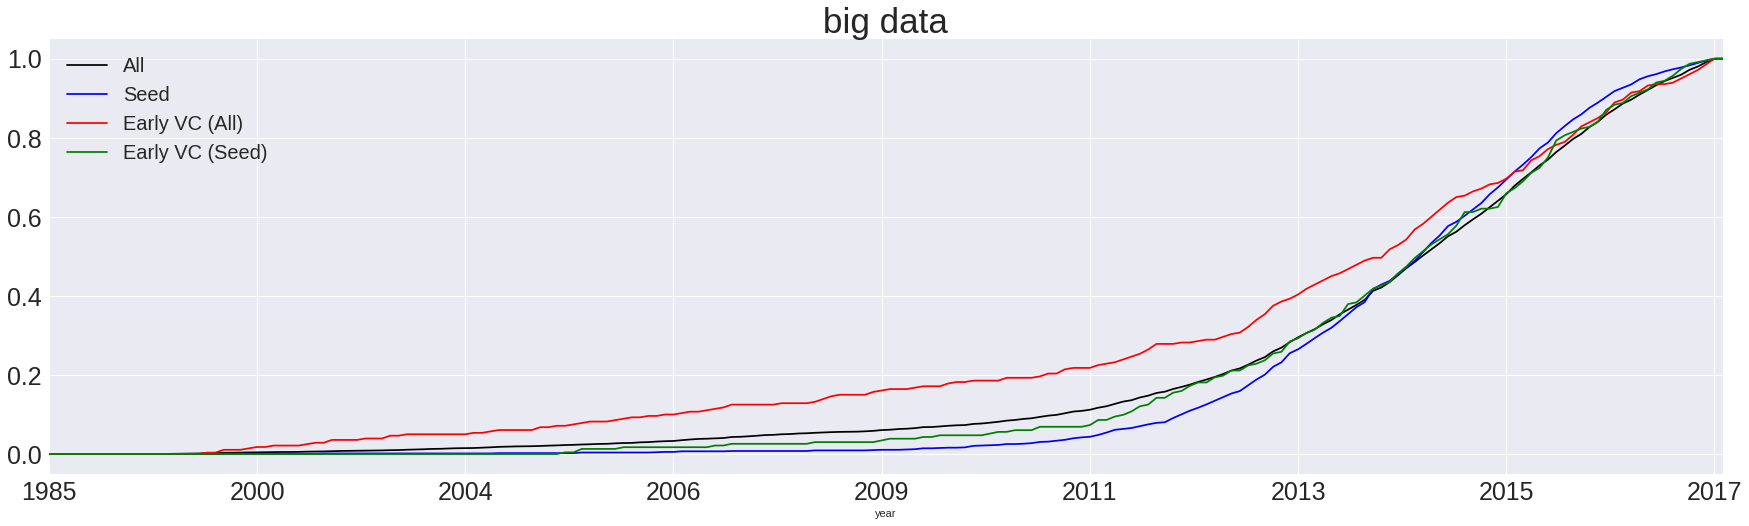

Category: fintech
# investment by all VC 3348
# investment by top VC 332
# investment by expert VC 209
# investment by seed expert VC 272


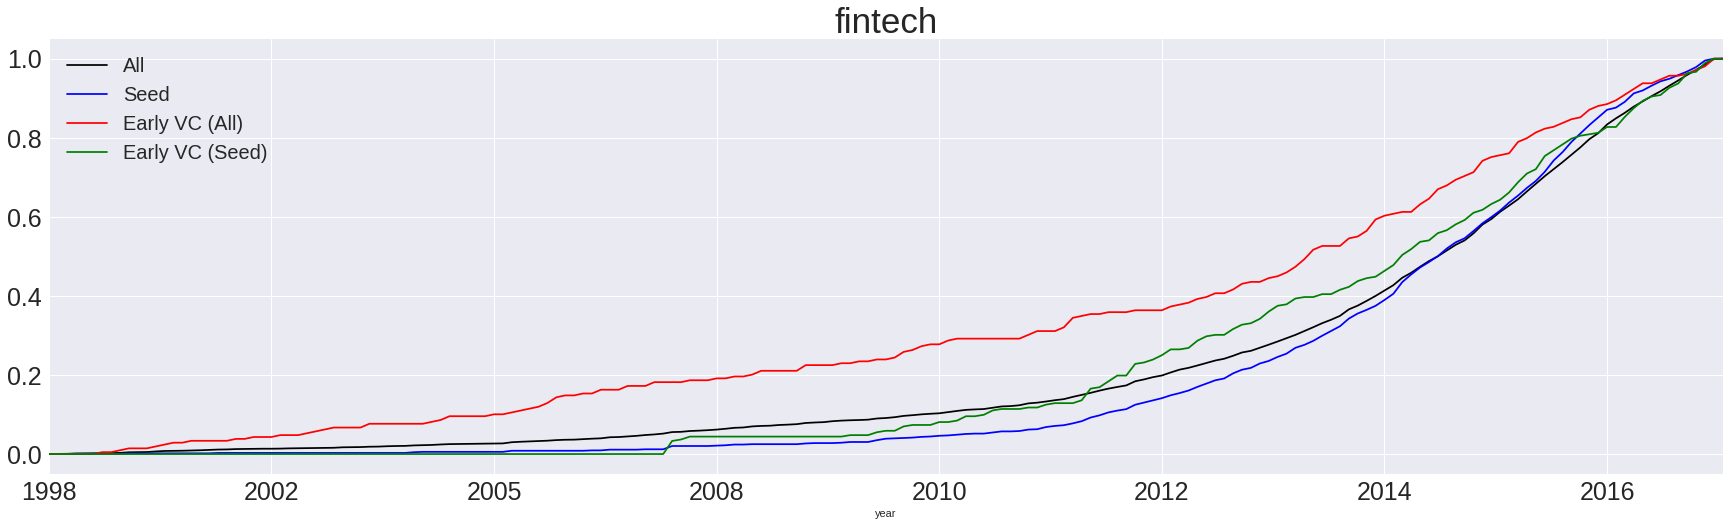

Category: hardware
# investment by all VC 3257
# investment by top VC 305
# investment by expert VC 298
# investment by seed expert VC 177


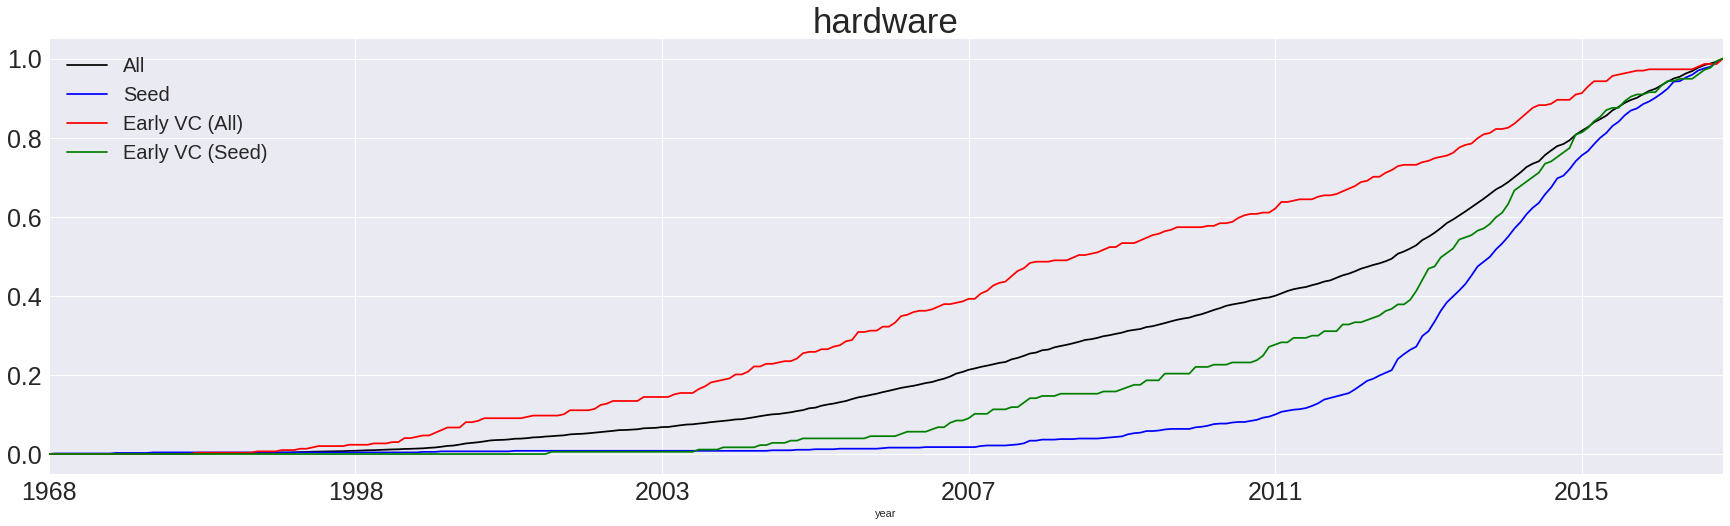

Category: financial services
# investment by all VC 3200
# investment by top VC 276
# investment by expert VC 203
# investment by seed expert VC 167


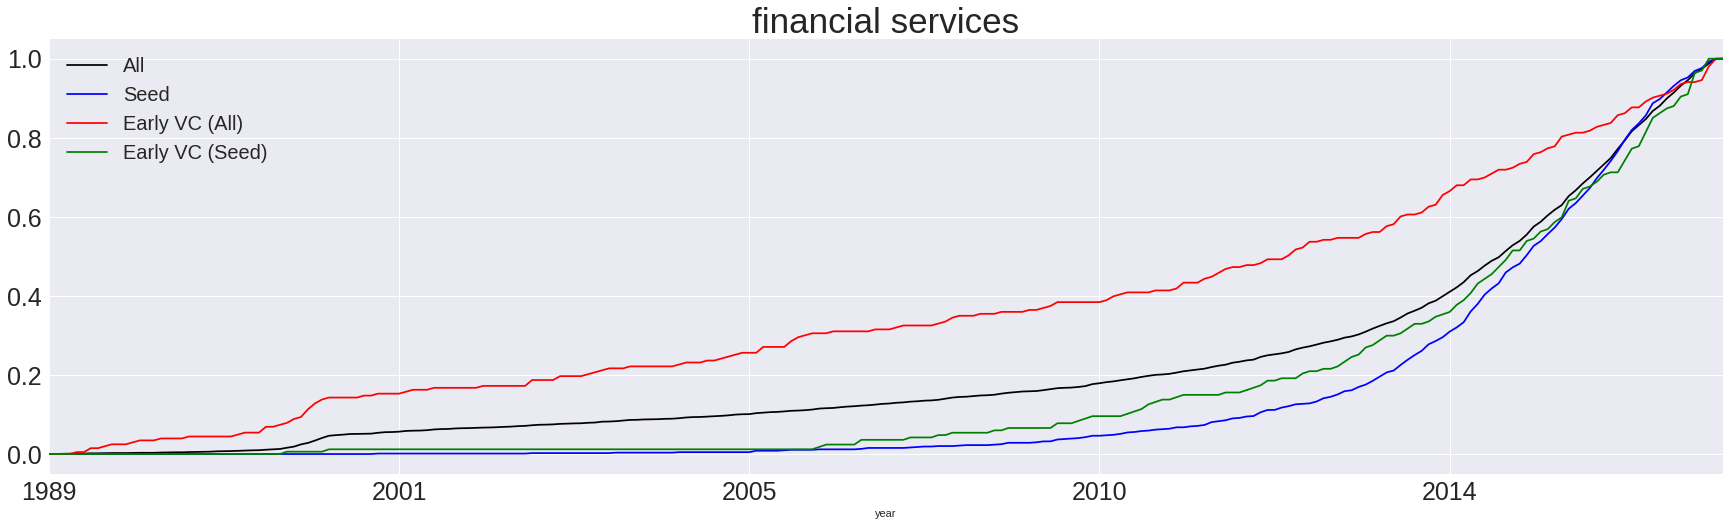

Category: medical device
# investment by all VC 3113
# investment by top VC 187
# investment by expert VC 189
# investment by seed expert VC 85


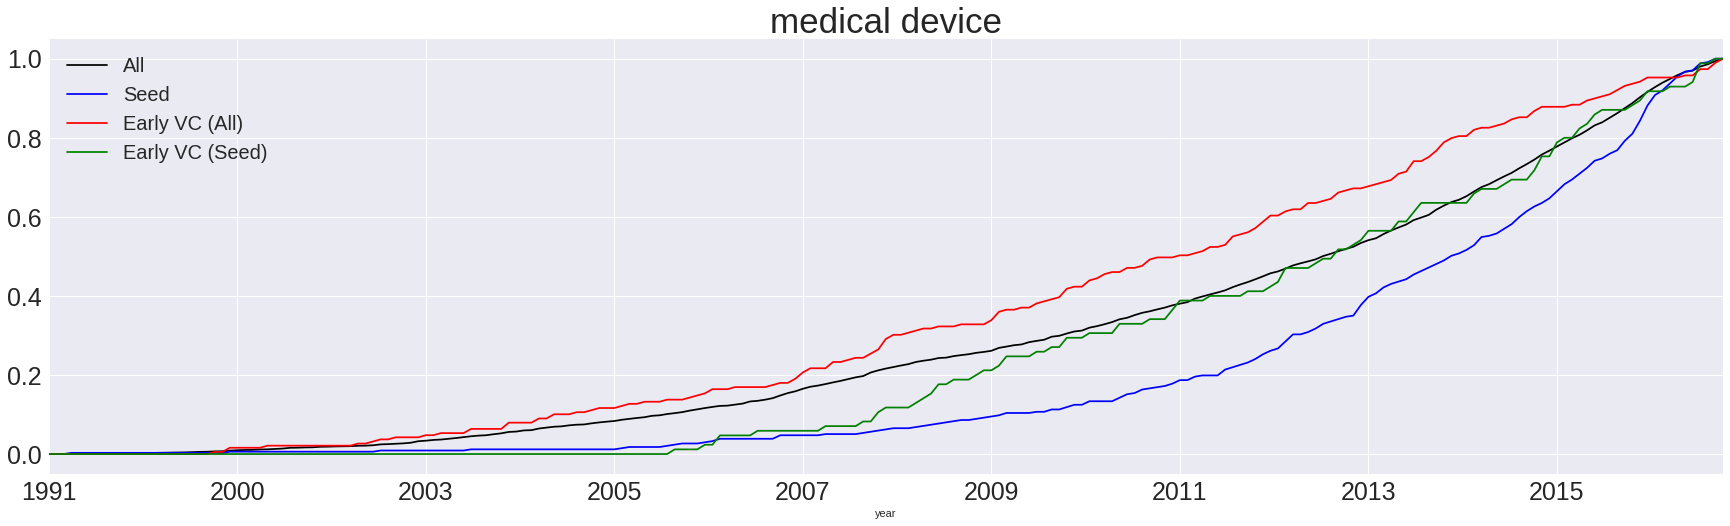

Category: security
# investment by all VC 2877
# investment by top VC 347
# investment by expert VC 374
# investment by seed expert VC 99


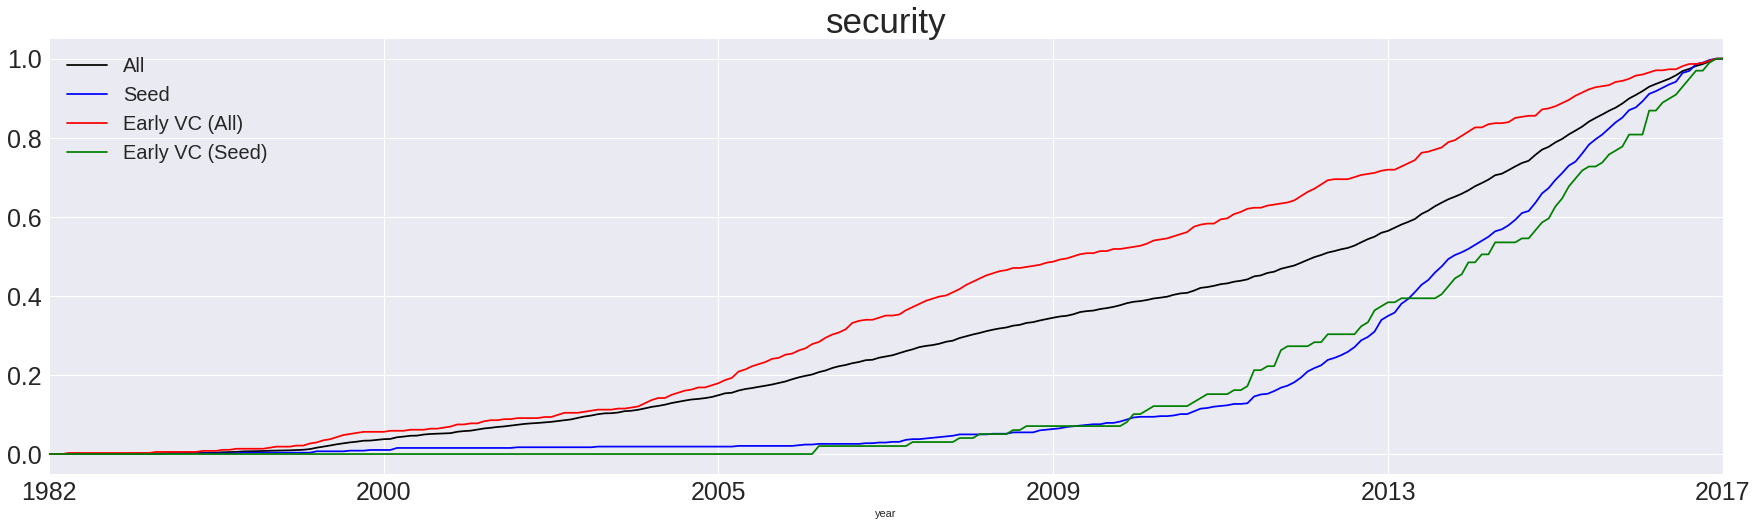

Category: cloud computing
# investment by all VC 2782
# investment by top VC 371
# investment by expert VC 355
# investment by seed expert VC 139


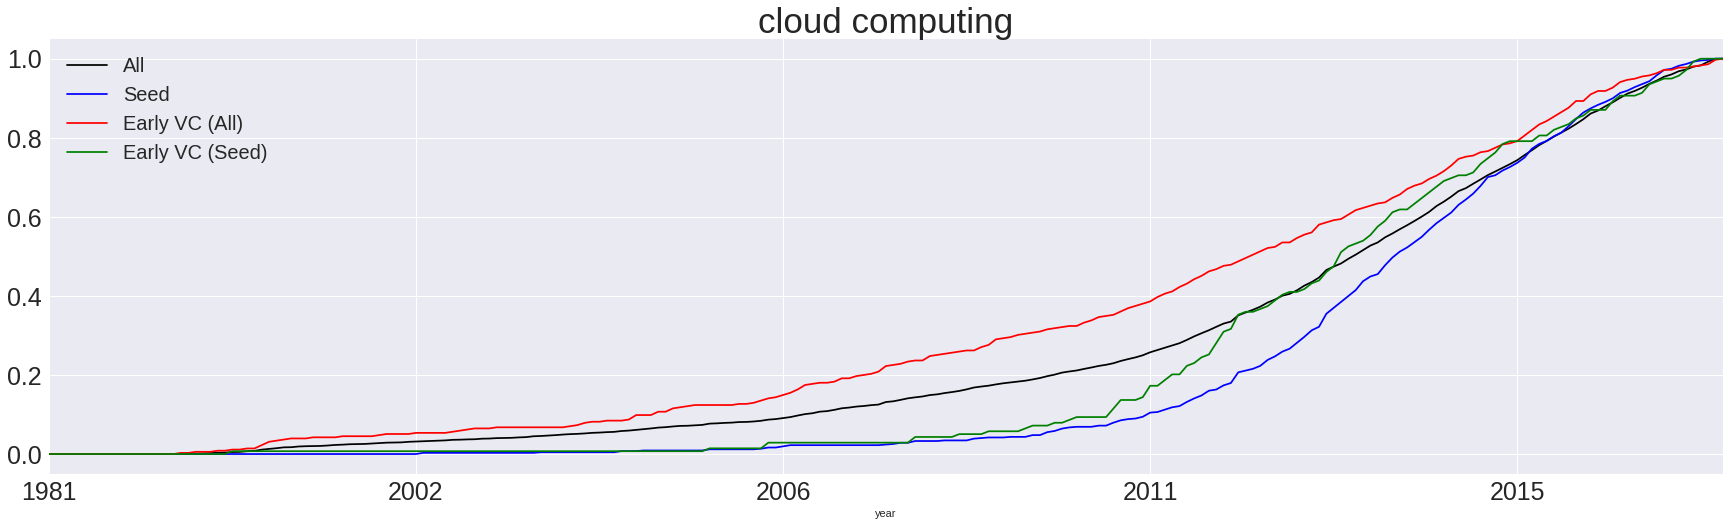

Category: video
# investment by all VC 2703
# investment by top VC 293
# investment by expert VC 229
# investment by seed expert VC 180


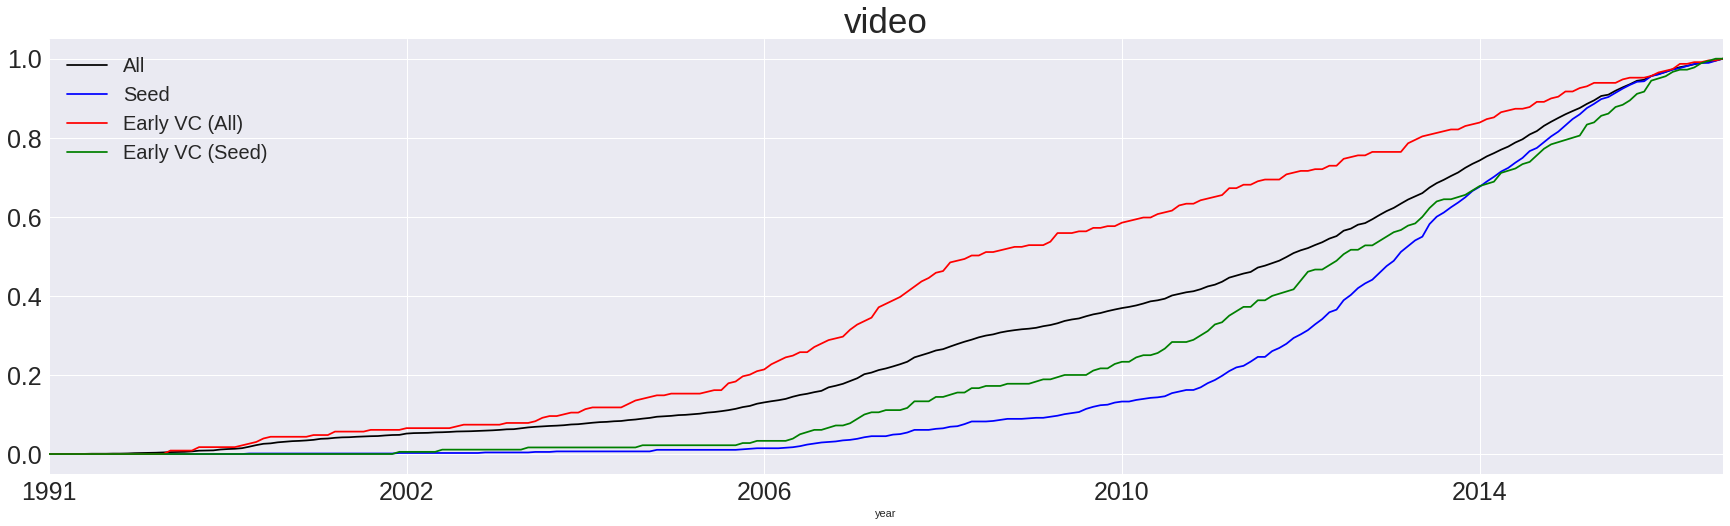

Category: retail
# investment by all VC 2509
# investment by top VC 230
# investment by expert VC 180
# investment by seed expert VC 132


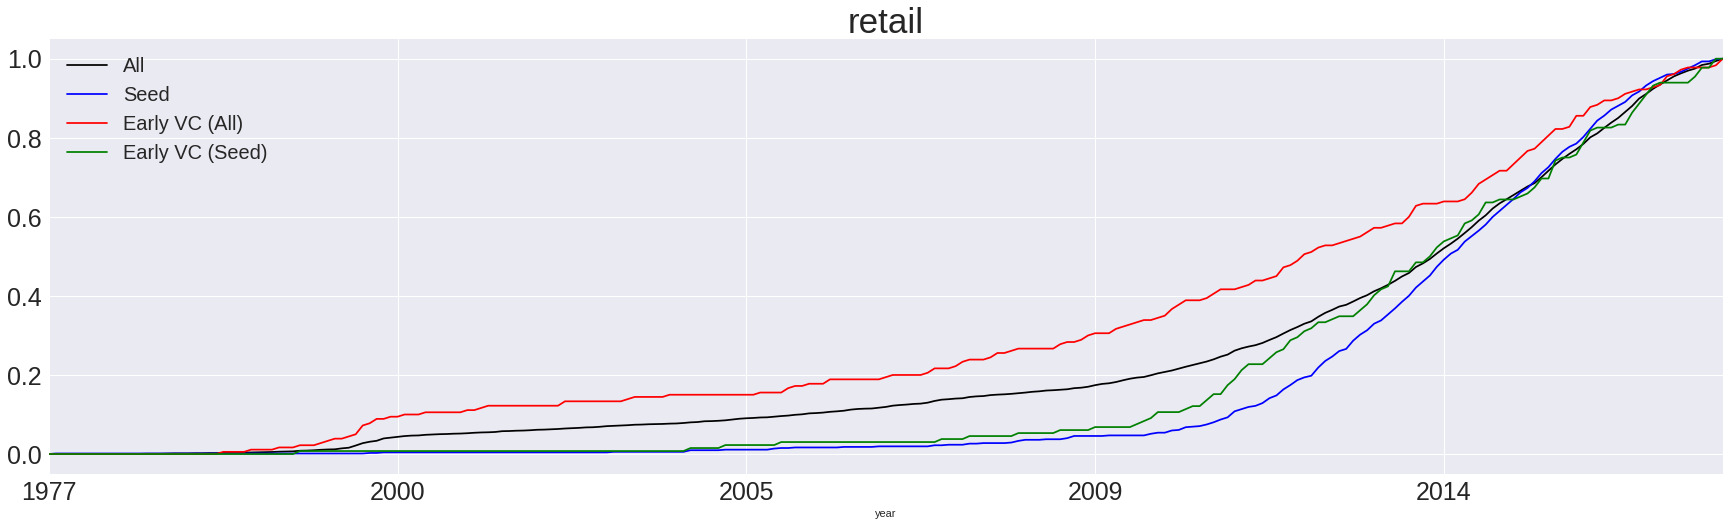

Category: telecommunications
# investment by all VC 2406
# investment by top VC 305
# investment by expert VC 353
# investment by seed expert VC 51


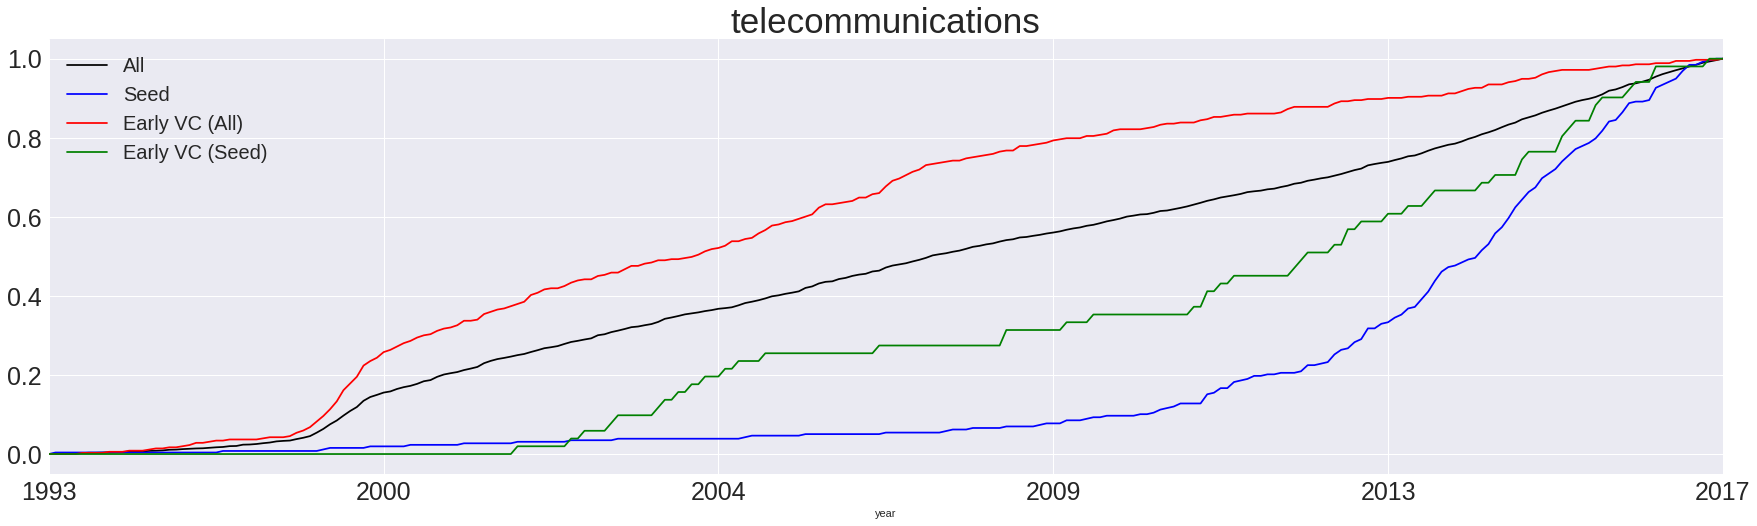

Category: wireless
# investment by all VC 2317
# investment by top VC 284
# investment by expert VC 340
# investment by seed expert VC 49


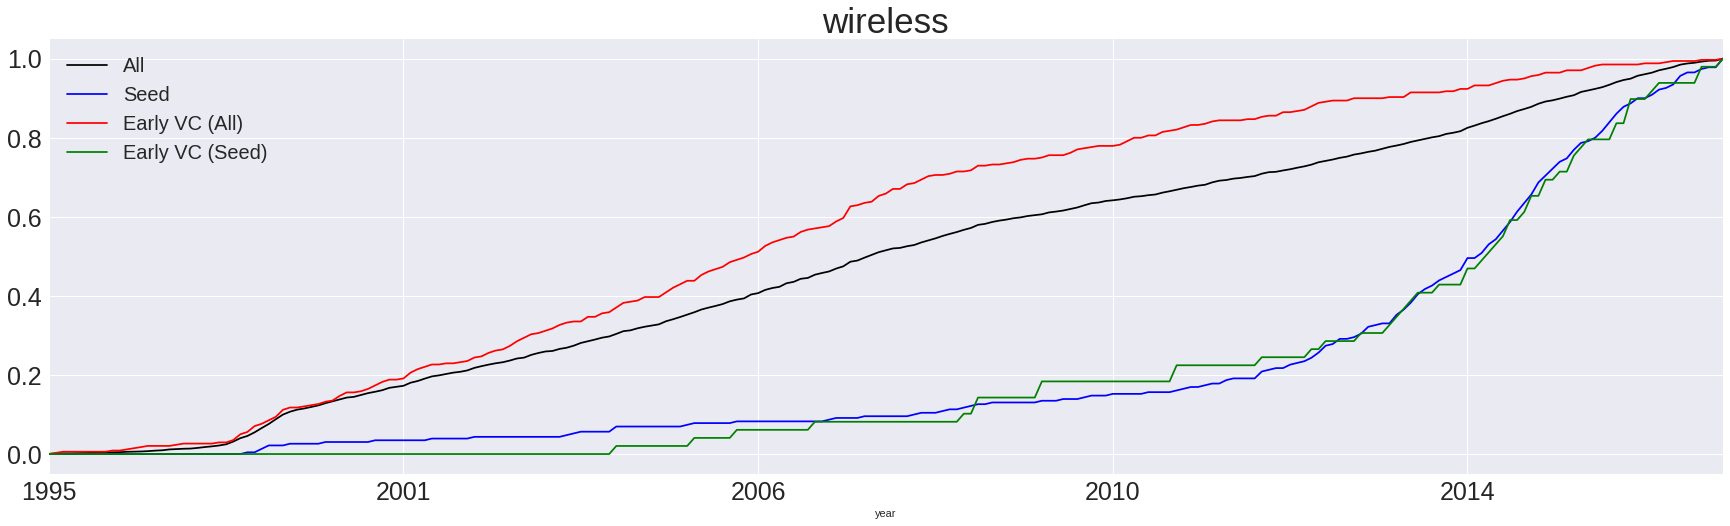

Category: travel
# investment by all VC 2249
# investment by top VC 187
# investment by expert VC 106
# investment by seed expert VC 138


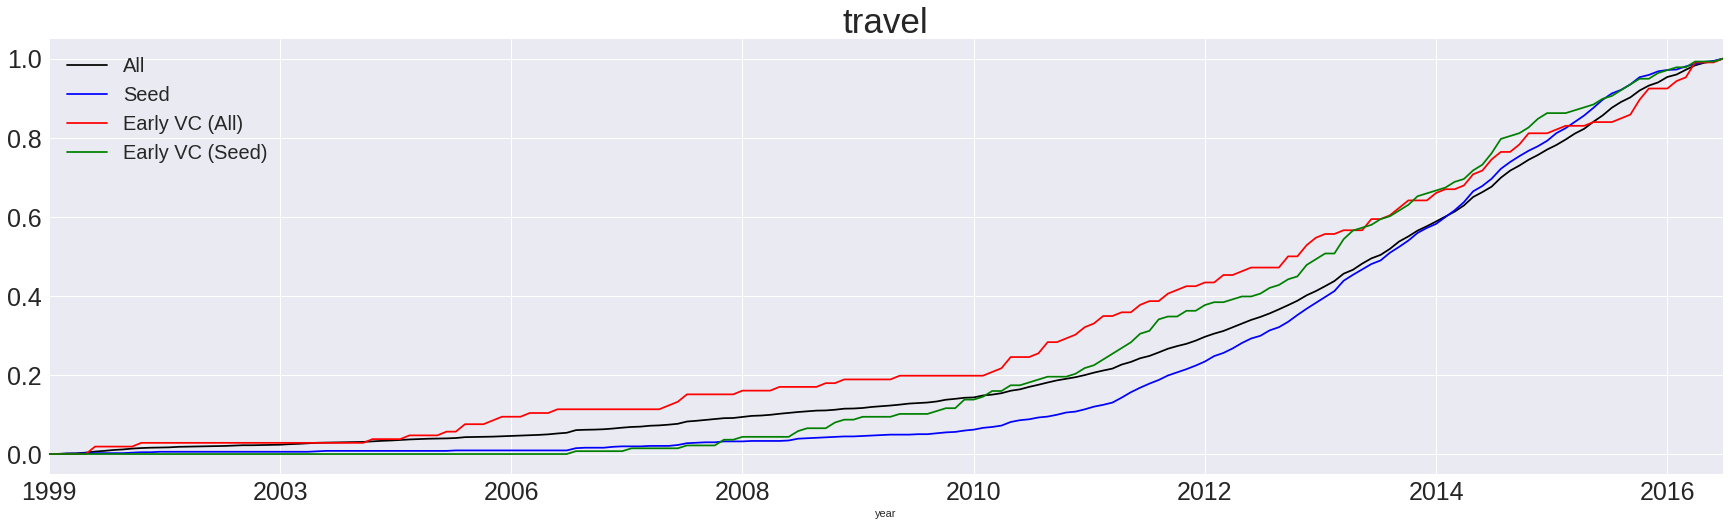

Category: pharmaceutical
# investment by all VC 2217
# investment by top VC 119
# investment by expert VC 113
# investment by seed expert VC 28


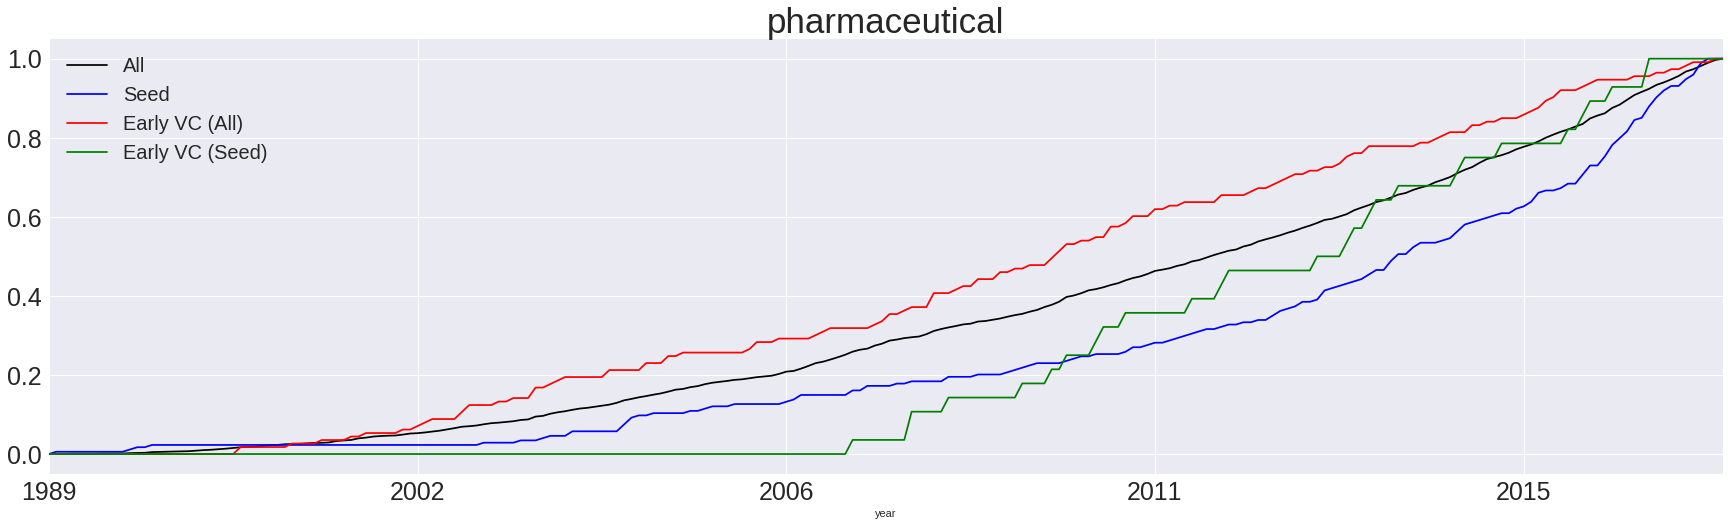

In [45]:
for category in df_category_count['category'].head(30).values:
    plot_early_investors(category = category, weight_scheme = 'log', TOP_K = 10, verbose = False)

['deep_learning']
Category: deep_learning
# investment by all VC 196
# investment by top VC 33
# investment by expert VC 13
# investment by seed expert VC 22


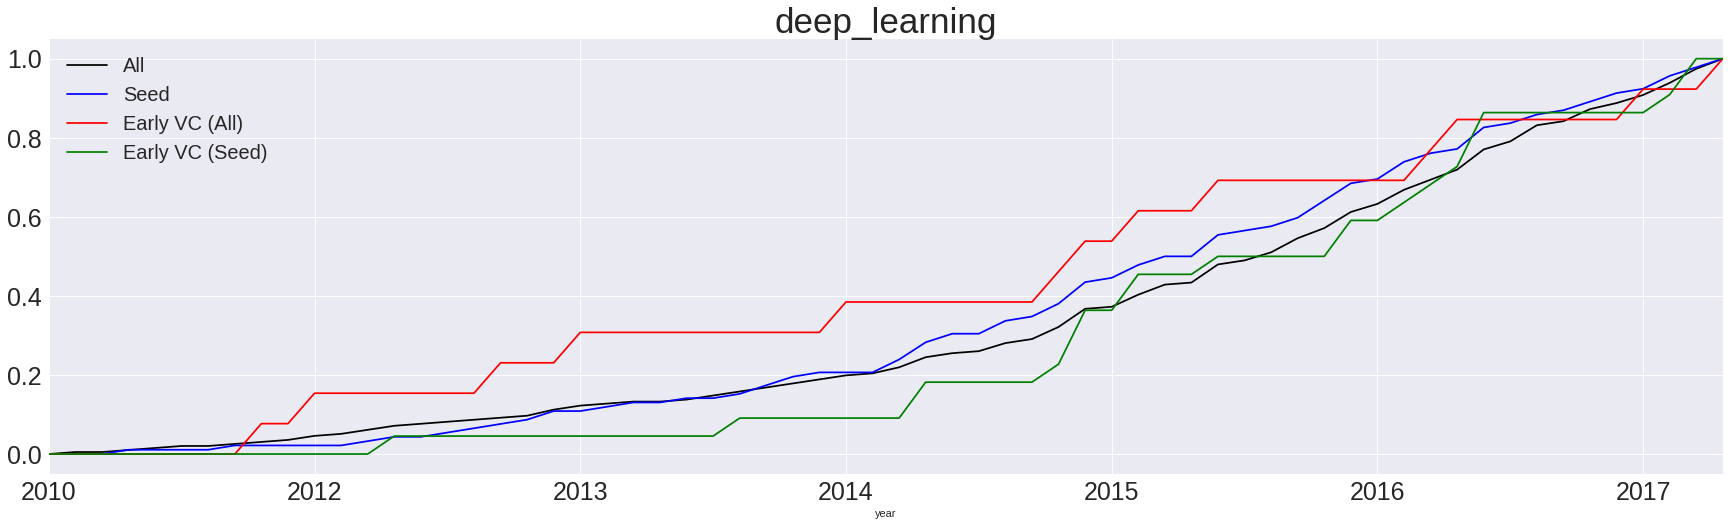

['neural_network', 'computer_vision', 'big_data', 'ai', 'reinforcement_learning', 'cognitive_computing', 'pattern_recognition', 'neural_networks', 'machine_learning', 'artificial_intelligence', 'deep_learning']
Category: deep_learning
# investment by all VC 4162
# investment by top VC 698
# investment by expert VC 527
# investment by seed expert VC 465


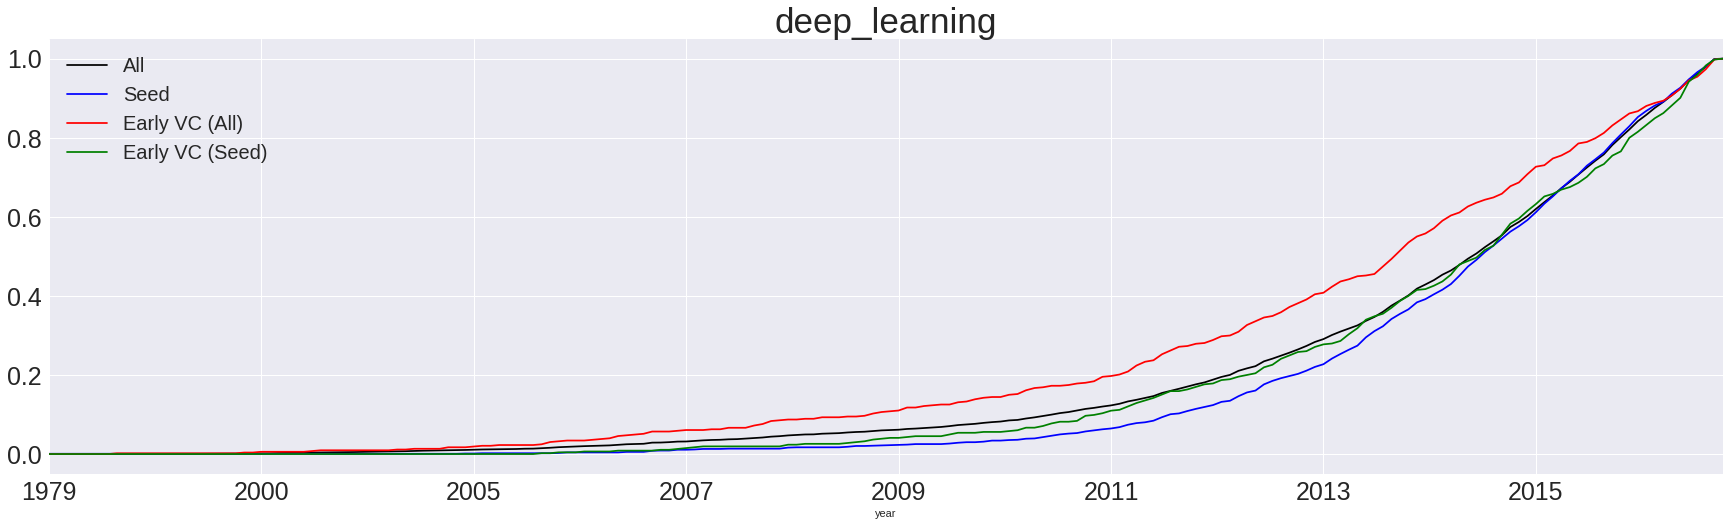

['fintech']
Category: fintech
# investment by all VC 268
# investment by top VC 37
# investment by expert VC 8
# investment by seed expert VC 31


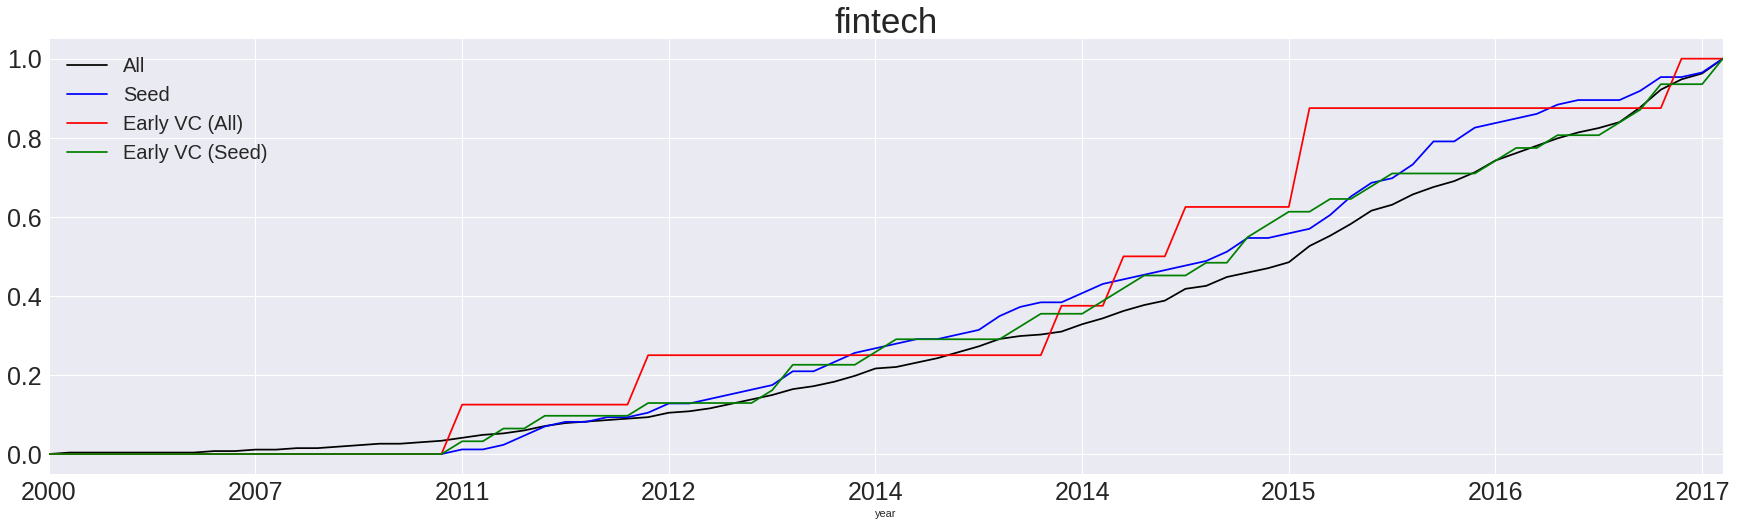

['agtech', 'fintech', 'regtech', 'insurtech', 'edtech', 'cleantech', 'tech', 'fin_tech', 'ad_tech', 'healthtech', 'adtech']
Category: fintech
# investment by all VC 1904
# investment by top VC 257
# investment by expert VC 134
# investment by seed expert VC 233


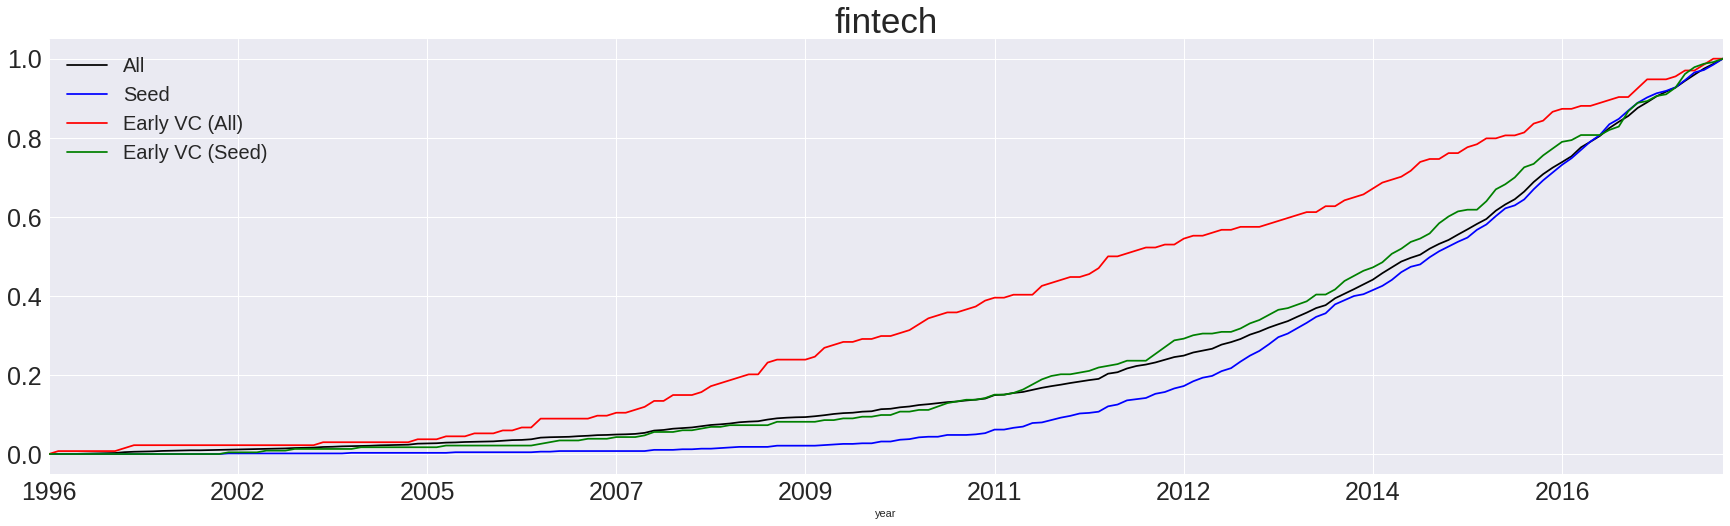

['drone']
Category: drone
# investment by all VC 180
# investment by top VC 31
# investment by expert VC 14
# investment by seed expert VC 34


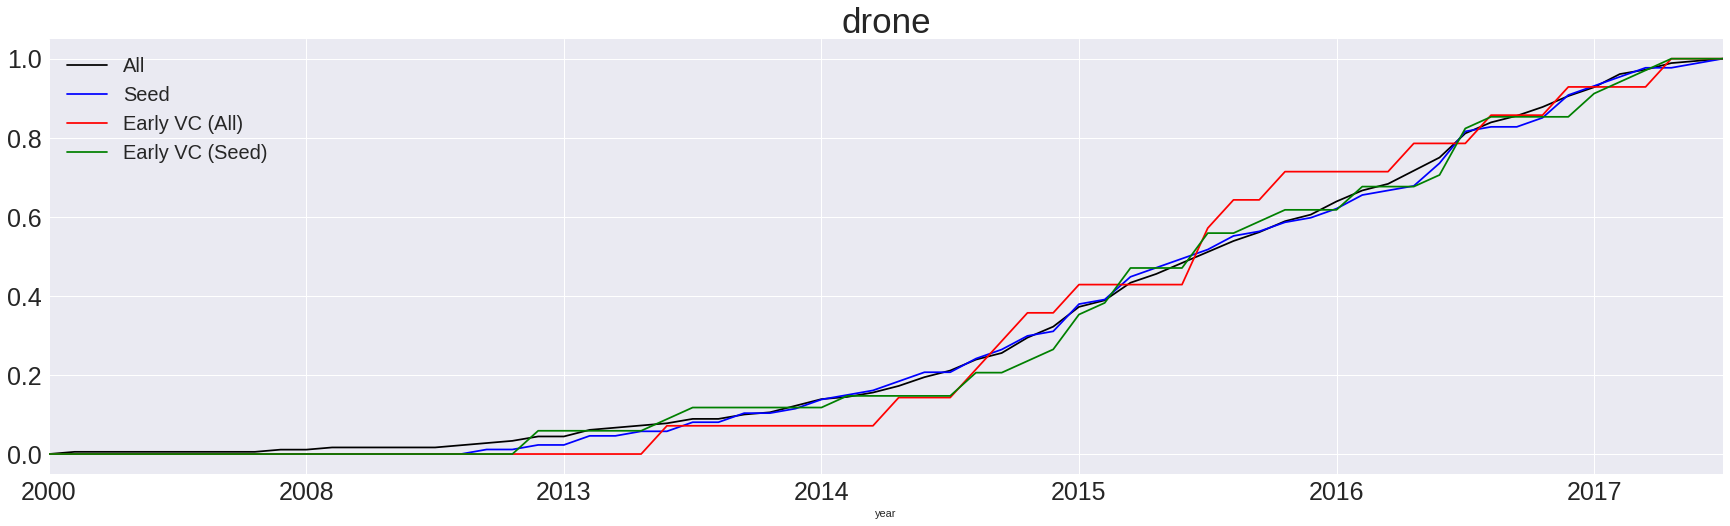

['remotely_operated', 'drone', 'uas', 'unmanned_aerial', 'uav', 'unmanned', 'uavs', 'drones', 'unmanned_aircraft', 'vtol', 'fixed_wing']
Category: drone
# investment by all VC 363
# investment by top VC 63
# investment by expert VC 43
# investment by seed expert VC 50


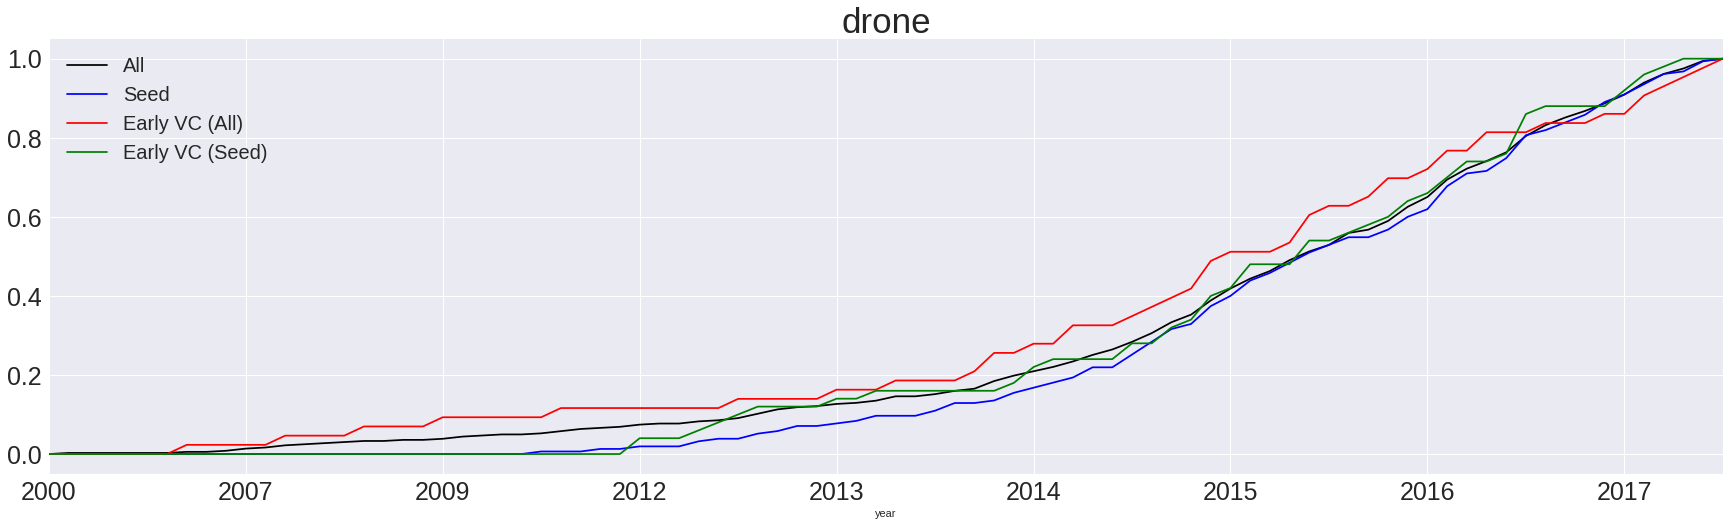

['wearable']
Category: wearable
# investment by all VC 337
# investment by top VC 23
# investment by expert VC 16
# investment by seed expert VC 25


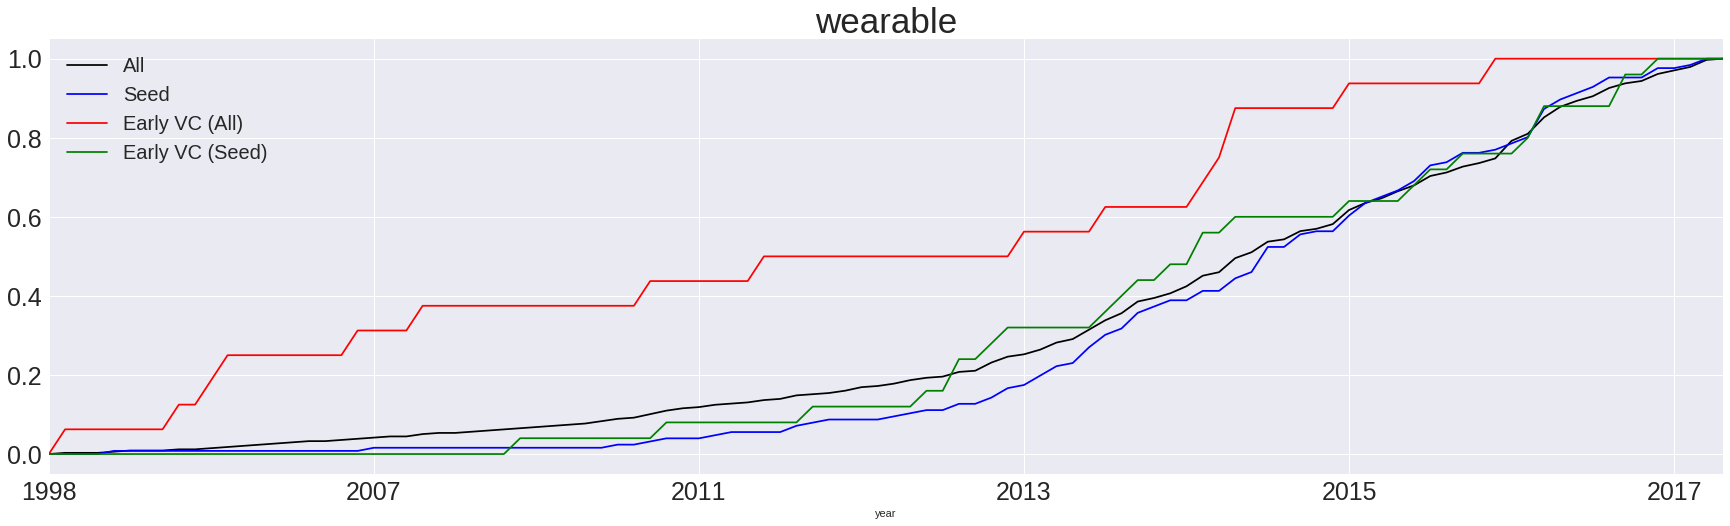

['wearables', 'smartwatch', 'smart_glasses', 'wearable_device', 'wearable', 'wrist_worn', 'bluetooth_smart', 'wearable_devices', 'sensor', 'wearable_tech', 'wearable_technology']
Category: wearable
# investment by all VC 1473
# investment by top VC 171
# investment by expert VC 142
# investment by seed expert VC 139


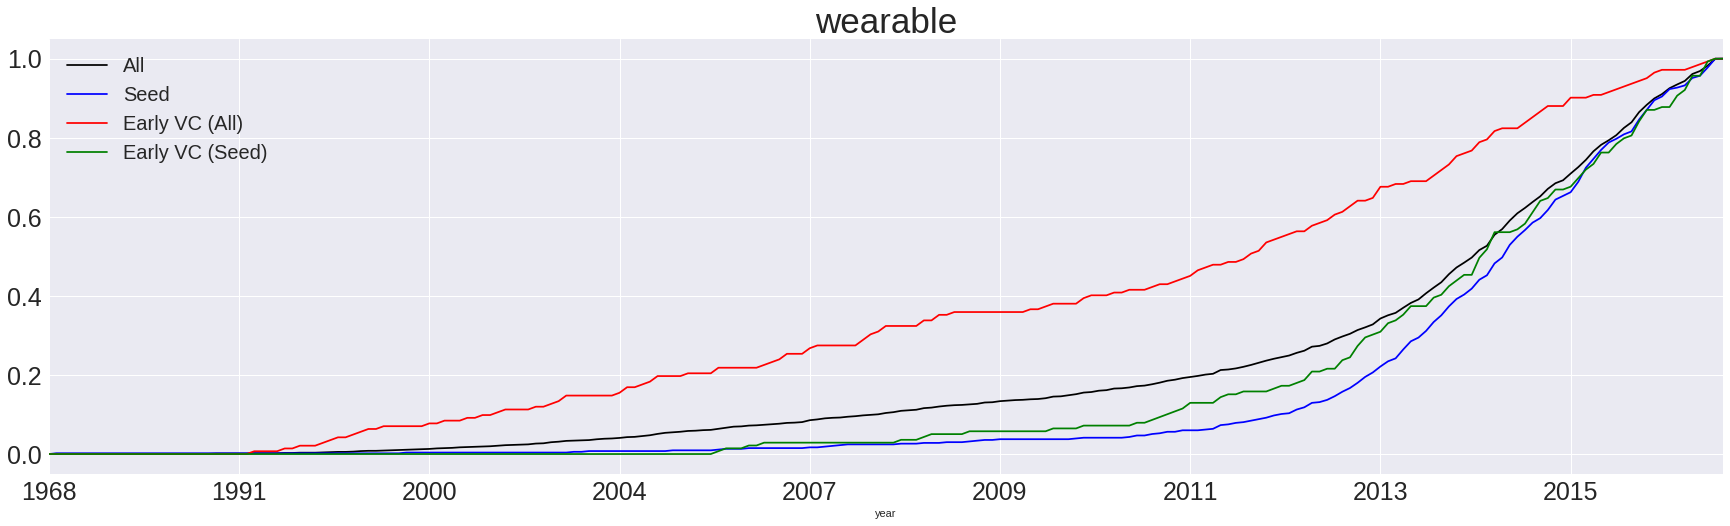

['3d_printing']
Category: 3d printing
# investment by all VC 0
# investment by top VC 0
# investment by expert VC 0
# investment by seed expert VC 0
no data
[]
Category: 3d printing
# investment by all VC 0
# investment by top VC 0
# investment by expert VC 0
# investment by seed expert VC 0
no data
['virtual_reality']
Category: virtual reality
# investment by all VC 310
# investment by top VC 53
# investment by expert VC 33
# investment by seed expert VC 29


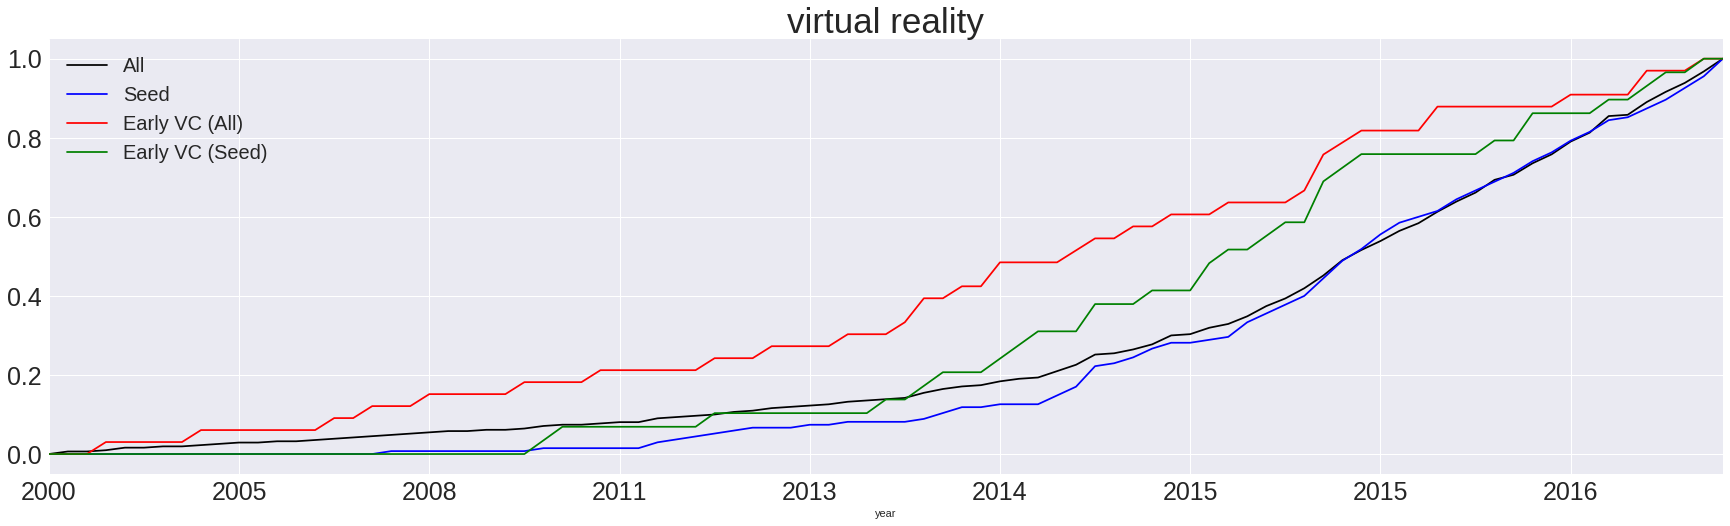

['ar_vr', 'htc_vive', 'virtual_reality', 'cinematic_vr', 'augmented_reality', 'vr_ar', 'vr', 'ar', 'immersive', 'oculus_rift', 'mixed_reality']
Category: virtual reality
# investment by all VC 981
# investment by top VC 160
# investment by expert VC 98
# investment by seed expert VC 102


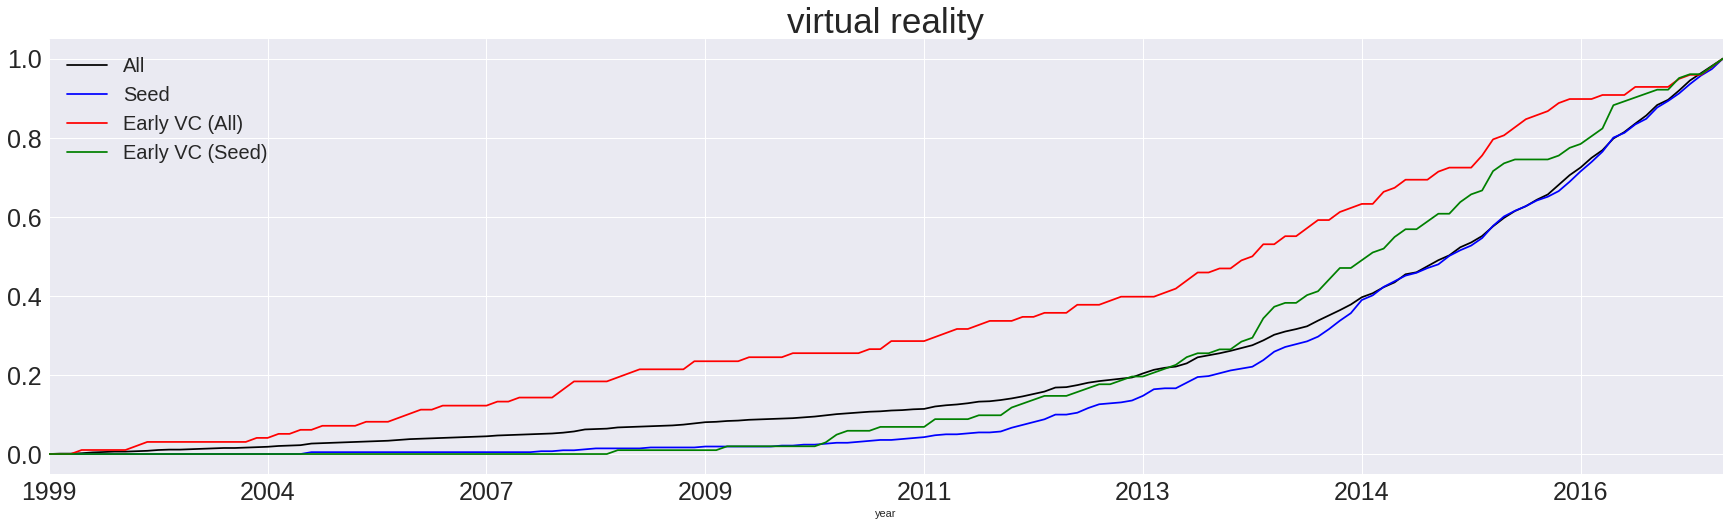

In [46]:
word_list = ['deep_learning', 'fintech', 'drone', 'wearable', '3d printing', 'virtual reality']
for word in word_list:
    plot_early_investors(category = word, weight_scheme = 'log', TOP_K = 30, verbose = False, this_is_word = True, expand = False)
    plot_early_investors(category = word, weight_scheme = 'log', TOP_K = 30, verbose = False, this_is_word = True, expand = True)